# SUMMARIZING IMMUNE CELLS

In [ ]:
# source("/data/srlab/ssg34/SLE_kidney_v2/scripts/libs/kidney_utils.r")

In [1]:
library(parallel)
library(patchwork)
library(purrr)
library(dplyr) 
library(tidyr)
library(cowplot)
library(singlecellmethods)
library(ggplot2)
library(ggbeeswarm)
library(stringr)
library(viridis)
library(tidyverse)

source("/data/srlab/anathan/scripts/scseq_utils.R")


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘cowplot’


The following object is masked from ‘package:patchwork’:

    align_plots


Loading required package: data.table


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose



Attaching package: ‘singlecellmethods’


The following object is masked from ‘package:base’:

    rowMeans


Loading required package: viridisLite

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.5
✔ lubridate 1.9.3     ✔ tibble    3.2.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ data.table::between()   masks dplyr::between()
✖ dplyr::filter()        

In [2]:
labelfontsize = 20
tickfontsize = 16

figdir = '../../figures/components/'
outdir = '../../data/tissue/'

# CLINICAL PREP

In [ ]:
clinical <- read.table('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/final_clinical_data_01-19-23_ResponderNA.txt', sep = '\t')
clinical <- clinical %>% 
                        filter(Type %in% c("LN", "Control")) %>% 
                        mutate(individual = str_split(AMP.ID, '-')) %>% 
                        rowwise() %>% 
                        mutate(individual = unlist(individual)[2]) %>% 
                        mutate(AMP.Subject_ID = str_split(AMP.ID, '-')) %>% 
                        rowwise() %>% 
                        mutate(AMP.Subject_ID = paste0(unlist(AMP.Subject_ID)[1], '-', unlist(AMP.Subject_ID)[2])) %>% unique()
central_scores <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/AMP_central_path.csv') %>% 
            mutate(ISN = ifelse(AMP.Subject_ID == "200-0138", NA, ISN))

clinical <- clinical %>% left_join(central_scores %>% 
                           select(AMP.Subject_ID, ISN, Activity, Chronicity) %>% 
                           rename(Central_ISN = ISN, 
                                  Central_Activity = Activity,
                                  Central_Chronicity = Chronicity)) %>% 
            mutate(Final_ISN = ifelse(is.na(Central_ISN), ISN, Central_ISN),
                   Final_Chronicity = ifelse(is.na(Central_Chronicity), Chronicity, Central_Chronicity),
                   Final_Activity = ifelse(is.na(Central_Activity), Activity, Central_Activity)) %>% 
            mutate(Final_ISN = ifelse(AMP.Subject_ID == "200-0138", ISN, Final_ISN))
clinical <- clinical[-c(15, 17), ]
# saveRDS(clinical, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/clinical_data_05042023.rds')

In [3]:
clinical <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/clinical_data_05042023.rds') %>% 
                        rename(Final_Site = Site) %>% select(-sample)

# INJURED PT %

In [4]:
lateinjury_high_prop <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/injured_pt_highprop_singlecell_05102024.rds')
lateinjury_low_prop <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/injured_pt_lowprop_singlecell_05102024.rds')

clinical <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/clinical_data_05042023.rds') %>% 
                        rename(Final_Site = Site) %>% select(-sample)

lateinjury_high_prop <- lateinjury_high_prop %>% 
                            rowwise() %>%
                            mutate(individual = str_remove(as.character(sample), "AMPSLEkid_cells_"))
lateinjury_low_prop <- lateinjury_low_prop %>% 
                            rowwise() %>%
                            mutate(individual = str_remove(as.character(sample), "AMPSLEkid_cells_"))

pt_clinical <- clinical %>% 
                    select(individual, Final_ISN, Responder.Status, Final_Chronicity, Final_Activity) %>% 
                    left_join(data.frame(Responder.Status = c('NR', 'PR', 'CR'),
                                         Responder_Status = c(0, 1, 2))) %>% 
                    left_join(lateinjury_high_prop %>% ungroup() %>% 
                                  select(individual, Prop) %>% 
                                  rename(LateInjuryHigh = Prop)) %>% 
                    left_join(lateinjury_low_prop %>% ungroup() %>% 
                                  select(individual, Prop) %>% 
                                  rename(LateInjuryLow = Prop))

Joining with `by = join_by(Responder.Status)`
Joining with `by = join_by(individual)`
Joining with `by = join_by(individual)`


In [5]:
pt_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/pt_meta_qcd_harmony_umap_clusternames_11302023.rds')

In [4]:
pt_meta %>% head(2)

,cell,sample,dataset,Site,Type,processing.batch,nCount_RNA,nFeature_RNA,broad.type,doublet_score,⋯,hres.0.2,hres.0.3,hres.0.4,hres.0.6,hres.0.8,hres.1.2,hres.1.6,hres.2.0,final_annotation,percent.mt
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>,<chr>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<chr>,<dbl>
1,AAGTGAAGTTACACTG-1-AMPSLEkid_cells_0142,AMPSLEkid_cells_0142,scRNAseq,Rochester,LN,29,1597,866,PT,0.0763325319548965,⋯,0,0,0,5,10,8,8,10,PT0. Late Injuryhigh,0.9392611
2,AGGTTGTGTACTCCCT-1-AMPSLEkid_cells_0366,AMPSLEkid_cells_0366,scRNAseq,UCSF,LN,34,1214,609,PT,0.132924561318671,⋯,0,0,0,5,2,14,19,27,PT0. Late Injuryhigh,1.8945634


In [5]:
pt_clinical %>% head(2)

individual,Final_ISN,Responder.Status,Final_Chronicity,Final_Activity,Responder_Status,LateInjuryHigh,LateInjuryLow
<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>
0134,[III],NR,6,4,0,0.3170732,0.07073171
0135,[III][V],PR,3,1,1,NA,NA


Joining, by = "hres.0.4"



	Pearson's product-moment correlation

data:  plot_df$scRNAseq and plot_df$snRNAseq
t = 6.1665, df = 48, p-value = 1.395e-07
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.4742731 0.7959087
sample estimates:
      cor 
0.6648519 



	Pearson's product-moment correlation

data:  plot_df$scRNAseq and plot_df$snRNAseq
t = 3.3023, df = 48, p-value = 0.001816
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.1725879 0.6328243
sample estimates:
      cor 
0.4302659 


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


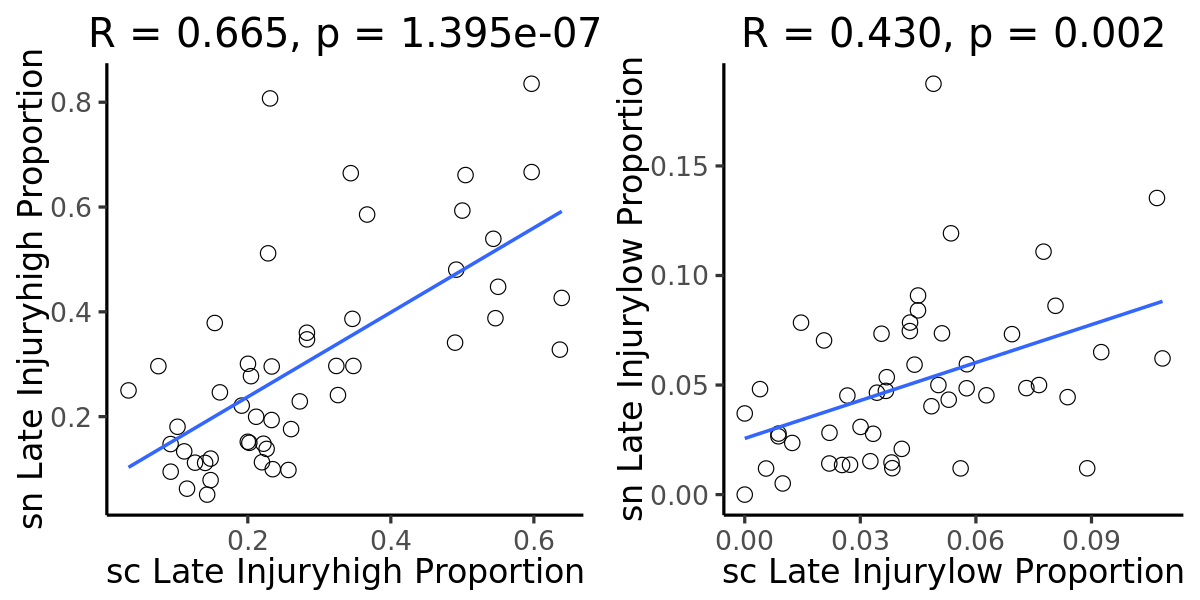

In [3]:
options(warn=-1)
fig.size(5, 10)
pt_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/pt_meta_qcd_harmony_umap_clusternames_11302023.rds')
final_annotation <- data.frame(hres.0.4 = as.factor(seq(0, 7)),
                               final_annotation = c("PT0. Late Injuryhigh",
                                                    "PT1. SLC7A7high ALBhigh S1/S2",
                                                    "PT2. Low Quality",
                                                    "PT3. PCK1high DXCRhigh S2/S3",
                                                    "PT4. ANPEPhigh APOMhigh S1/S2",
                                                    "PT5. Late Injurylow S1/S2",
                                                    "PT6. PKHD1high SLC3A1high S2/S3",
                                                    "PT7. DTL"))

pt_meta <- pt_meta  %>% left_join(final_annotation) %>% 
                mutate(individual = str_split(sample, '_')) %>% 
                rowwise() %>% 
                mutate(individual = unlist(individual)[3]) 

sn_list <- pt_meta %>% 
                filter(dataset == 'snRNAseq') %>% 
                pull(individual) %>% unique()
plot_df <- pt_meta %>% 
                select(individual, dataset, final_annotation) %>% 
                table() %>% data.frame() %>% 
                group_by(individual, dataset) %>% 
                mutate(Prop = Freq / sum(Freq)) %>% 
                filter(final_annotation == 'PT0. Late Injuryhigh') %>% 
                mutate(Prop = ifelse(is.na(Prop), 0, Prop)) %>% 
                select(individual, dataset, Prop) %>% 
                pivot_wider(names_from = 'dataset',
                            values_from = 'Prop')  %>% 
                filter(individual %in% sn_list)

cor.test(plot_df$scRNAseq, plot_df$snRNAseq)

p1 <- ggplot(plot_df, 
           aes(x = scRNAseq, y = snRNAseq)) +
    geom_point(shape = 21, size = 4) + 
    theme_classic(base_size = 20) + 
    geom_smooth(method = 'lm', se = FALSE) + 
    labs(x = 'sc Late Injuryhigh Proportion', 
         y = 'sn Late Injuryhigh Proportion',
         title = 'R = 0.665, p = 1.395e-07') + 
    theme(plot.title = element_text(hjust = 0.5),
          text=element_text(family="Arial"))


plot_df <- pt_meta %>% 
                select(individual, dataset, final_annotation) %>% 
                table() %>% data.frame() %>% 
                group_by(individual, dataset) %>% 
                mutate(Prop = Freq / sum(Freq)) %>% 
                filter(final_annotation == "PT5. Late Injurylow S1/S2") %>% 
                mutate(Prop = ifelse(is.na(Prop), 0, Prop)) %>% 
                select(individual, dataset, Prop) %>% 
                pivot_wider(names_from = 'dataset',
                            values_from = 'Prop')  %>% 
                filter(individual %in% sn_list)

cor.test(plot_df$scRNAseq, plot_df$snRNAseq)

p2 <- ggplot(plot_df, 
           aes(x = scRNAseq, y = snRNAseq)) +
    geom_point(shape = 21, size = 4) + 
    theme_classic(base_size = 20) + 
    geom_smooth(method = 'lm', se = FALSE) + 
    labs(x = 'sc Late Injurylow Proportion', 
         y = 'sn Late Injurylow Proportion',
         title = 'R = 0.430, p = 0.002') + 
    theme(plot.title = element_text(hjust = 0.5),
          text=element_text(family="Arial"))
p3 <- cowplot::plot_grid(p1, p2)
cowplot::save_plot("/data/srlab/ssg34/SLE_kidney_v2/figures/extended_data/figure9/figure9a.png",
       p3,
       base_height = 5,
       base_width = 10)
p3
options(warn=0)

[1] FALSE


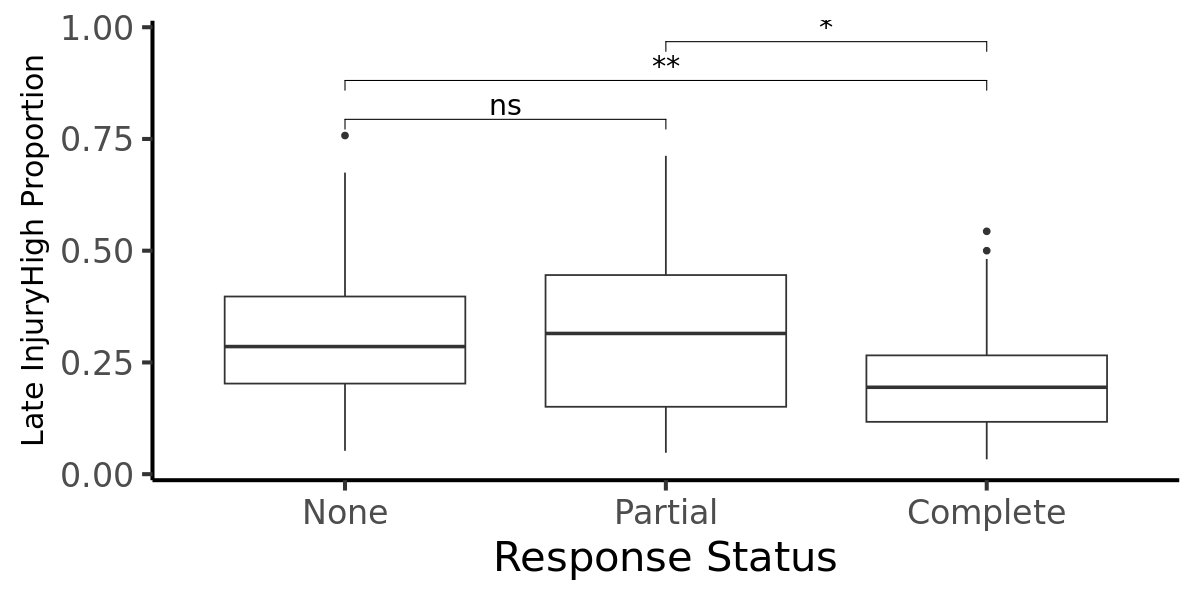

In [7]:
my_comparisons <- list(
                        c("NR", "PR"),
                        c("NR", "CR"),
                        c("PR", "CR"))

plot_df <- pt_clinical %>% 
                select(Responder.Status, Responder_Status, LateInjuryHigh) %>% 
                na.omit()
p1 <- ggplot(plot_df, aes(x = as.factor(Responder.Status), 
                    y = LateInjuryHigh)) + 
            geom_boxplot(position = 'dodge') + 
            theme_classic(base_size = 25) + 
            labs(x = 'Response Status',
                 y = 'Late InjuryHigh Proportion') + 
            theme(legend.position = "none",
                  axis.title.y = element_text(size = 18),
                  text=element_text(family="Arial")) + 
            scale_x_discrete(limits = c("NR", "PR", "CR"), labels = c("None", "Partial", "Complete")) + 
            ggpubr::stat_compare_means(label = "p.signif", method = "t.test", 
                                       comparisons = my_comparisons, size = 6)
p1


	Pearson's product-moment correlation

data:  plot_df$Final_Chronicity and plot_df$LateInjuryHigh
t = 7.5978, df = 139, p-value = 4.025e-12
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.4134074 0.6489024
sample estimates:
      cor 
0.5416991 



	Pearson's product-moment correlation

data:  plot_df$Final_Activity and plot_df$LateInjuryHigh
t = -0.79152, df = 139, p-value = 0.43
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.22975338  0.09942774
sample estimates:
        cor 
-0.06698541 


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


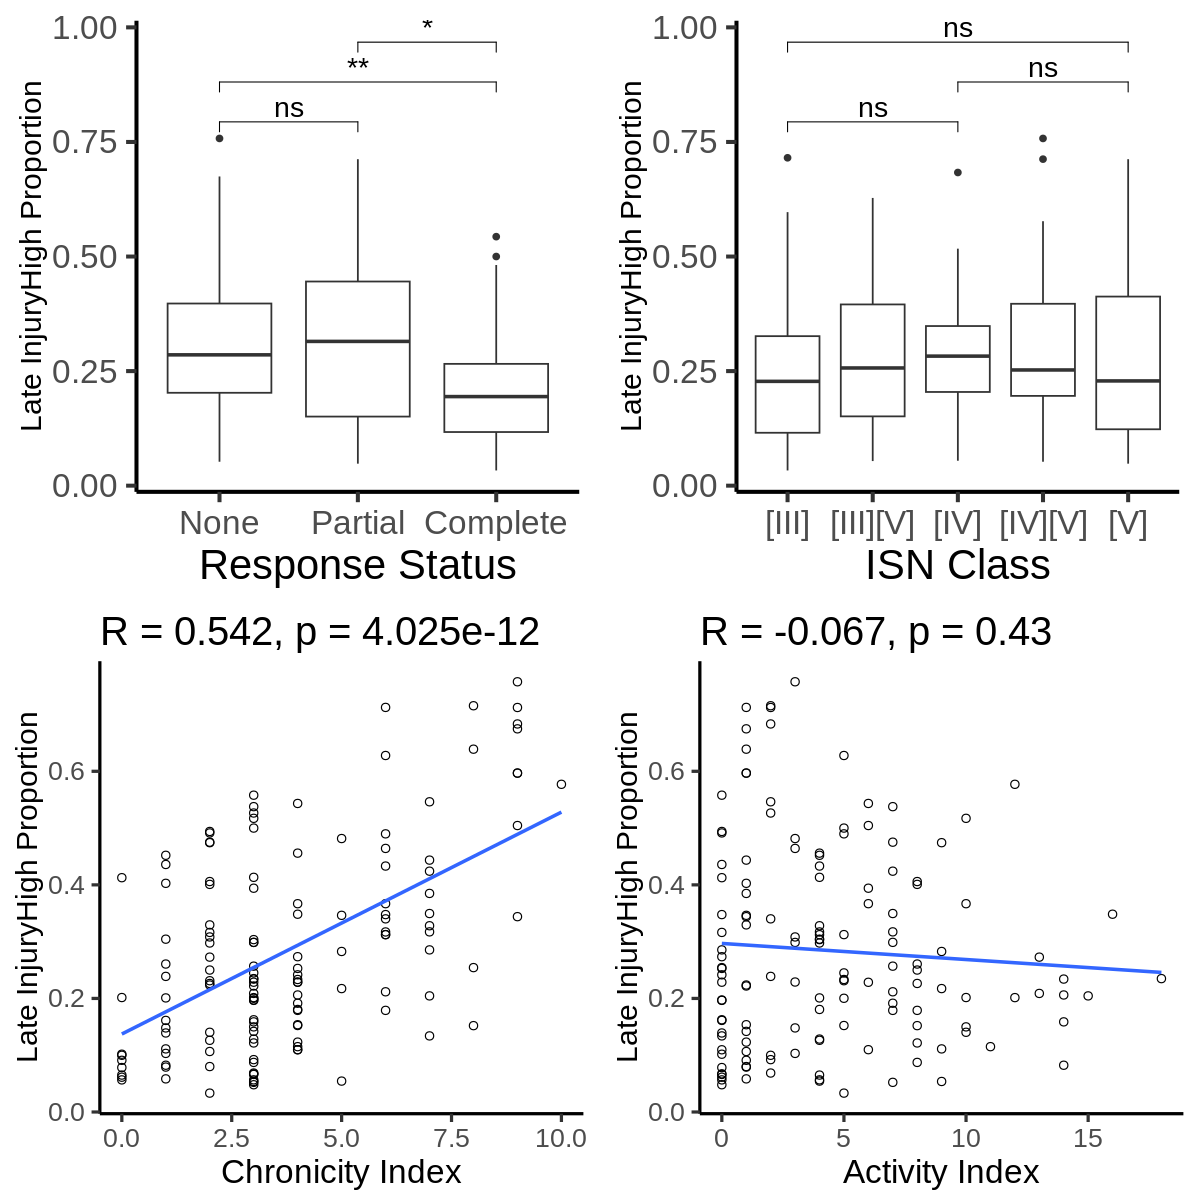

In [8]:
options(warn=-1)
fig.size(10, 10)
par(mfrow = c(2, 2))
par(mfrow = c(2, 2))
my_comparisons <- list(
                        c("NR", "PR"),
                        c("NR", "CR"),
                        c("PR", "CR"))

plot_df <- pt_clinical %>% 
                select(Responder.Status, Responder_Status, LateInjuryHigh) %>% 
                na.omit()
p1 <- ggplot(plot_df, aes(x = as.factor(Responder.Status), 
                    y = LateInjuryHigh)) + 
            geom_boxplot(position = 'dodge') + 
            theme_classic(base_size = 25) + 
            labs(x = 'Response Status',
                 y = 'Late InjuryHigh Proportion') + 
            theme(legend.position = "none",
                  axis.title.y = element_text(size = 18),
                  text=element_text(family="Arial")) + 
            scale_x_discrete(limits = c("NR", "PR", "CR"), labels = c("None", "Partial", "Complete")) + 
            ggpubr::stat_compare_means(label = "p.signif", method = "t.test", 
                                       comparisons = my_comparisons, size = 6)

my_comparisons <- list(
                        c("[III]", "[IV]"),
                        c("[IV]", "[V]"),
                        c("[III]", "[V]"))

plot_df <- pt_clinical %>% 
                select(Final_ISN, LateInjuryHigh) %>% 
                na.omit()
p2 <- ggplot(plot_df, aes(x = as.factor(Final_ISN), 
                    y = LateInjuryHigh)) + 
            geom_boxplot(position = 'dodge') + 
            theme_classic(base_size = 25) + 
            labs(x = 'ISN Class',
                 y = 'Late InjuryHigh Proportion') + 
            theme(legend.position = "none",
                  axis.title.y = element_text(size = 18),
                  text=element_text(family="Arial")) + 
            ggpubr::stat_compare_means(label = "p.signif", method = "t.test", 
                                       comparisons = my_comparisons, size = 6)

plot_df <- pt_clinical %>% 
                select(Final_Chronicity, LateInjuryHigh) %>% 
                na.omit()
cor.test(plot_df$Final_Chronicity, plot_df$LateInjuryHigh)
p3 <- ggplot(plot_df, aes(x = Final_Chronicity, 
                    y = LateInjuryHigh)) + 
            geom_point(shape = 21, size = 2) + 
            theme_classic(base_size = 20) + 
            theme(axis.title.y = element_text(size = 18),
                  text=element_text(family="Arial")) + 
            labs(x = 'Chronicity Index',
                 y = 'Late InjuryHigh Proportion',
                 title = "R = 0.542, p = 4.025e-12") + 
            geom_smooth(method = 'lm', se = FALSE)

plot_df <- pt_clinical %>% 
                select(Final_Activity, LateInjuryHigh) %>% 
                na.omit()
cor.test(plot_df$Final_Activity, plot_df$LateInjuryHigh)
p4 <- ggplot(plot_df, aes(x = Final_Activity, 
                    y = LateInjuryHigh)) + 
            geom_point(shape = 21, size = 2) + 
            theme_classic(base_size = 20) + 
            theme(axis.title.y = element_text(size = 18),
                  text=element_text(family="Arial")) + 
            labs(x = 'Activity Index',
                 y = 'Late InjuryHigh Proportion',
                 title = "R = -0.067, p = 0.43") + 
            geom_smooth(method = 'lm', se = FALSE)




p4 <- cowplot::plot_grid(p1, p2, p3, p4, label_size = 12)
# cowplot::save_plot("/data/srlab/ssg34/SLE_kidney_v2/figures/extended_data/figure9/figure9b.png",
#        p4,
#        base_height = 10,
#        base_width = 10)
p4
options(warn=0)

In [18]:
tickfontsize

[1] 16


	Pearson's product-moment correlation

data:  plot_df$Final_Chronicity and plot_df$LateInjuryHigh
t = 7.5978, df = 139, p-value = 4.025e-12
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.4134074 0.6489024
sample estimates:
      cor 
0.5416991 


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


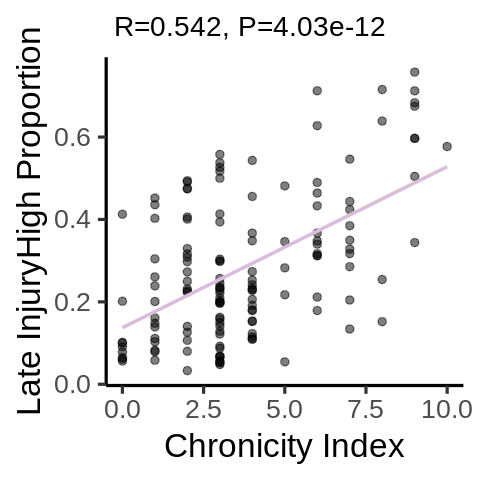

In [46]:
plot_df <- pt_clinical %>% 
                select(Final_Chronicity, LateInjuryHigh) %>% 
                na.omit()
cor.test(plot_df$Final_Chronicity, plot_df$LateInjuryHigh)
p3 <- ggplot(plot_df, aes(x = Final_Chronicity, 
                    y = LateInjuryHigh)) + 
            geom_jitter(size = 2, alpha = .5, height = 0, width = 0) + 
            theme_classic(base_size = 20) + 
            theme(axis.title = element_text(size = labelfontsize), 
                  axis.text = element_text(size = tickfontsize), 
                  title = element_text(size = tickfontsize-2),
                  text=element_text(family="Arial")) + 
            labs(x = 'Chronicity Index',
                 y = 'Late InjuryHigh Proportion',
                 title = " R=0.542, P=4.03e-12") + 
            geom_smooth(method = 'lm', se = FALSE, color = 'thistle')


height = 4
width = 4
fig.size(height, width)
outplot = p3
outplot

ggsave(paste0(figdir, 'pt_chronicity_corr.png'), plot = outplot,  
       height = height, width = width, dpi = 500)
ggsave(paste0(figdir, 'pt_chronicity_corr.pdf'), plot = outplot,  
       height = height, width = width, dpi = 500, device = cairo_pdf)


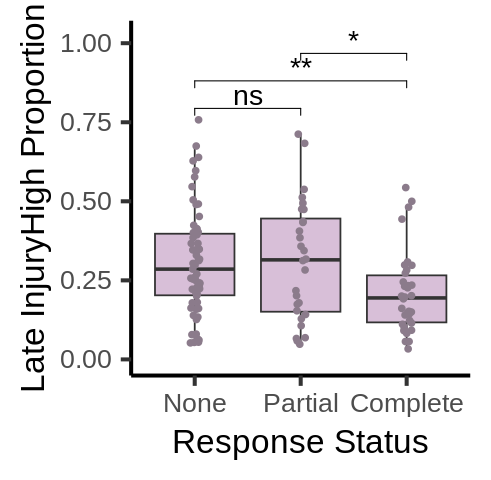

In [73]:
options(warn=-1)
fig.size(10, 10)
par(mfrow = c(2, 2))
par(mfrow = c(2, 2))
my_comparisons <- list(
                        c("NR", "PR"),
                        c("NR", "CR"),
                        c("PR", "CR"))

plot_df <- pt_clinical %>% 
                select(Responder.Status, Responder_Status, LateInjuryHigh) %>% 
                na.omit()
p1 <- ggplot(plot_df, aes(x = as.factor(Responder.Status), 
                    y = LateInjuryHigh)) + 
            geom_boxplot(fill = 'thistle', outlier.shape = NA) +
            geom_jitter(width = 0.05, height = 0, col = 'thistle4')+
            theme_classic(base_size = 25) + 
            labs(x = 'Response Status',
                 y = 'Late InjuryHigh Proportion') + 
            theme(axis.title = element_text(size = labelfontsize), 
                  axis.text = element_text(size = tickfontsize), 
                  title = element_text(size = tickfontsize-2),
                  text=element_text(family="Arial")) + 
            scale_x_discrete(limits = c("NR", "PR", "CR"), labels = c("None", "Partial", "Complete")) + 
            ggpubr::stat_compare_means(label = "p.signif", method = "t.test", 
                                       comparisons = my_comparisons, size = 6)+
            ylim(c(0, 1.02))

height = 4
width = 4.1
fig.size(height, width)
outplot = p1
outplot


ggsave(paste0(figdir, 'pt_response_boxplot.png'), plot = outplot,  
       height = height, width = width, dpi = 500)
ggsave(paste0(figdir, 'pt_response_boxplot.pdf'), plot = outplot,  
       height = height, width = width, dpi = 500, device = cairo_pdf)


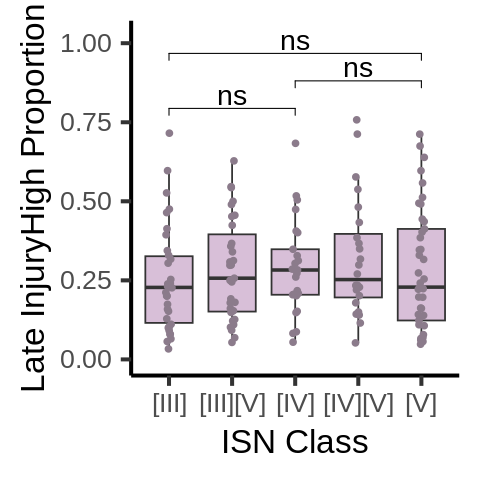

In [80]:
my_comparisons <- list(
                        c("[III]", "[IV]"),
                        c("[IV]", "[V]"),
                        c("[III]", "[V]"))

plot_df <- pt_clinical %>% 
                select(Final_ISN, LateInjuryHigh) %>% 
                na.omit()
p2 <- ggplot(plot_df, aes(x = as.factor(Final_ISN), 
                    y = LateInjuryHigh)) + 
            geom_boxplot(fill = 'thistle', outlier.shape = NA) +
            geom_jitter(width = 0.05, height = 0, col = 'thistle4')+
            theme_classic(base_size = 25) + 
            labs(x = 'ISN Class',
                 y = 'Late InjuryHigh Proportion') + 
            theme(axis.title = element_text(size = labelfontsize), 
                  axis.text = element_text(size = tickfontsize), 
                  title = element_text(size = tickfontsize-2),
                  text=element_text(family="Arial")) + 
            ggpubr::stat_compare_means(label = "p.signif", method = "t.test", 
                                       comparisons = my_comparisons, size = 6)+
            ylim(c(0, 1.02))


height = 4
width = 4
fig.size(height, width)
outplot = p2
outplot


ggsave(paste0(figdir, 'pt_isn_boxplot.png'), plot = outplot,  
       height = height, width = width, dpi = 500)
ggsave(paste0(figdir, 'pt_isn_boxplot.pdf'), plot = outplot,  
       height = height, width = width, dpi = 500, device = cairo_pdf)


[1] FALSE
[1] FALSE



	Pearson's product-moment correlation

data:  plot_df$Final_Chronicity and plot_df$LateInjuryLow
t = 2.1466, df = 139, p-value = 0.03356
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.01423388 0.33453073
sample estimates:
      cor 
0.1791245 



	Pearson's product-moment correlation

data:  plot_df$Final_Activity and plot_df$LateInjuryLow
t = 1.8978, df = 139, p-value = 0.0598
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.00656353  0.31593312
sample estimates:
     cor 
0.158921 


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


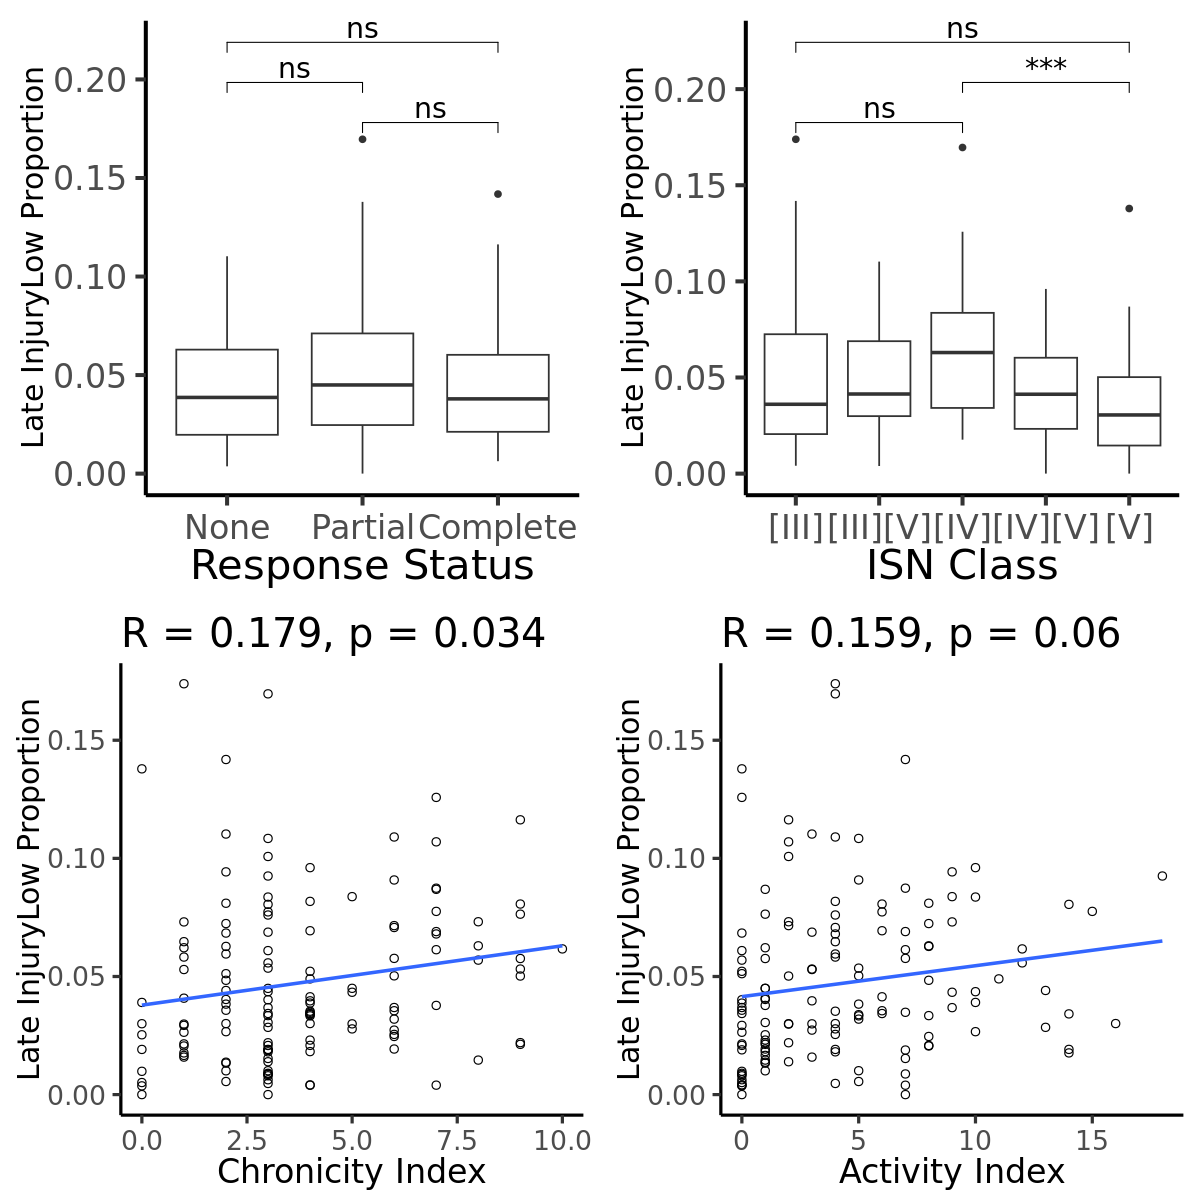

In [10]:
options(warn = -1)
fig.size(10, 10)
par(mfrow = c(2, 2))
my_comparisons <- list(
                        c("NR", "PR"),
                        c("NR", "CR"),
                        c("PR", "CR"))

plot_df <- pt_clinical %>% 
                select(Responder.Status, Responder_Status, LateInjuryLow) %>% 
                na.omit()
p1 <- ggplot(plot_df, aes(x = as.factor(Responder.Status), 
                    y = LateInjuryLow)) + 
            geom_boxplot(position = 'dodge') + 
            theme_classic(base_size = 25) + 
            labs(x = 'Response Status',
                 y = 'Late InjuryLow Proportion') + 
            theme(legend.position = "none",
                  axis.title.y = element_text(size = 18),
                  text=element_text(family="Arial")) + 
            scale_x_discrete(labels = c("None", "Partial", "Complete")) + 
            ggpubr::stat_compare_means(label = "p.signif", method = "t.test", 
                                       comparisons = my_comparisons, size = 6)

my_comparisons <- list(
                        c("[III]", "[IV]"),
                        c("[IV]", "[V]"),
                        c("[III]", "[V]"))

plot_df <- pt_clinical %>% 
                select(Final_ISN, LateInjuryLow) %>% 
                na.omit()
p2 <- ggplot(plot_df, aes(x = as.factor(Final_ISN), 
                    y = LateInjuryLow)) + 
            geom_boxplot(position = 'dodge') + 
            theme_classic(base_size = 25) + 
            labs(x = 'ISN Class',
                 y = 'Late InjuryLow Proportion') + 
            theme(legend.position = "none",
                  axis.title.y = element_text(size = 18),
                  text=element_text(family="Arial")) + 
            ggpubr::stat_compare_means(label = "p.signif", method = "t.test", 
                                       comparisons = my_comparisons, size = 6)

plot_df <- pt_clinical %>% 
                select(Final_Chronicity, LateInjuryLow) %>% 
                na.omit()
cor.test(plot_df$Final_Chronicity, plot_df$LateInjuryLow)
p3 <- ggplot(plot_df, aes(x = Final_Chronicity, 
                    y = LateInjuryLow)) + 
            geom_point(shape = 21, size = 2) + 
            theme_classic(base_size = 20) + 
            theme(axis.title.y = element_text(size = 18),
                  text=element_text(family="Arial")) + 
            labs(x = 'Chronicity Index',
                 y = 'Late InjuryLow Proportion',
                 title = "R = 0.179, p = 0.034") + 
            geom_smooth(method = 'lm', se = FALSE)

plot_df <- pt_clinical %>% 
                select(Final_Activity, LateInjuryLow) %>% 
                na.omit()
cor.test(plot_df$Final_Activity, plot_df$LateInjuryLow)

p4 <- ggplot(plot_df, aes(x = Final_Activity, 
                    y = LateInjuryLow)) + 
            geom_point(shape = 21, size = 2) + 
            theme_classic(base_size = 20) + 
            theme(axis.title.y = element_text(size = 18),
                  text=element_text(family="Arial")) + 
            labs(x = 'Activity Index',
                 y = 'Late InjuryLow Proportion',
                 title = 'R = 0.159, p = 0.06') + 
            geom_smooth(method = 'lm', se = FALSE)




p4 <- cowplot::plot_grid(p1, p2, p3, p4, label_size = 12)
cowplot::save_plot("/data/srlab/ssg34/SLE_kidney_v2/figures/extended_data/figure9/figure9c.png",
       p4,
       base_height = 10,
       base_width = 10)
p4
options(warn = 0)

In [11]:
first_biop_pred <- readRDS("/data/srlab2/qxiao/AMP-SLE/data/clinical/df_pred_biop.rds") %>% 
                        mutate(individual = str_split(Subject_ID, '-')) %>% 
                        rowwise() %>% 
                        mutate(individual = unlist(individual)[2])

pt_clinical <- clinical %>% filter(Type == "LN") %>% 
                    left_join(first_biop_pred) %>% 
                    left_join(data.frame(Responder.Status = c('NR', 'PR', 'CR'),
                                         Responder_Status = c(0, 1, 2))) %>% 
                    left_join(lateinjury_high_prop %>% ungroup() %>% 
                                  select(individual, Prop) %>% 
                                  rename(LateInjuryHigh = Prop)) %>% 
                    select(LateInjuryHigh, Final_Activity, Final_Chronicity, Responder_Status, 
                           Final_Site, Final_ISN, Race, First_biop, Pred_use, Age, Sex)

pt_clin_sub <- pt_clinical %>% select(is.numeric)

cor_df <- data.frame()
for (i in colnames(pt_clin_sub)[2:ncol(pt_clin_sub)]) {
    df <- pt_clin_sub[, c("LateInjuryHigh", i)] %>% na.omit()
    est <- cor.test(unlist(df[, "LateInjuryHigh"]), unlist(df[, i]))$estimate ^ 2
    pval <- cor.test(unlist(df[, "LateInjuryHigh"]), unlist(df[, i]))$p.value
    cor_df <- rbind(cor_df, 
                    data.frame("LateInjuryHigh", i, est, pval))
}
colnames(cor_df) <- c("Variable1", "Variable2", "correlation", "pvalue")
pt_clinical <- fastDummies::dummy_cols(pt_clinical, "Race")
pt_clinical <- fastDummies::dummy_cols(pt_clinical, "Final_ISN")
pt_clinical <- fastDummies::dummy_cols(pt_clinical, "Final_Site")
model_df <- pt_clinical[, c("LateInjuryHigh", "Final_ISN", "Race", "Sex", "Final_Site")] %>% na.omit()
cor_df <- cor_df %>% rbind(data.frame(Variable1 = "LateInjuryHigh",
                            Variable2 = "ISN Class",
                            correlation = -0.01134,
                            pvalue = 0.686))
cor_df <- cor_df %>% rbind(data.frame(Variable1 = "LateInjuryHigh",
                            Variable2 = "Final_Site",
                            correlation = 0.0854,
                            pvalue = 0.01241))
cor_df <- cor_df %>% rbind(data.frame(Variable1 = "LateInjuryHigh",
                            Variable2 = "Race",
                            correlation = -0.02755,
                            pvalue = 0.93))
cor_df <- cor_df %>% rbind(data.frame(Variable1 = "LateInjuryHigh",
                            Variable2 = "Sex",
                            correlation = 0.003944,
                            pvalue = 0.2065))

cor_df$bfpval <- p.adjust(cor_df$pvalue, method = "bonferroni")

Joining, by = "individual"
Joining, by = "Responder.Status"
Joining, by = "individual"
Warning message:
“Use of bare predicate functions was deprecated in tidyselect 1.1.0.
ℹ Please use wrap predicates in `where()` instead.
  # Was:
  data %>% select(is.numeric)

  # Now:
  data %>% select(where(is.numeric))”


Warning message:
“Removed 9 rows containing missing values (`geom_text()`).”
Warning message:
“Removed 9 rows containing missing values (`geom_text()`).”


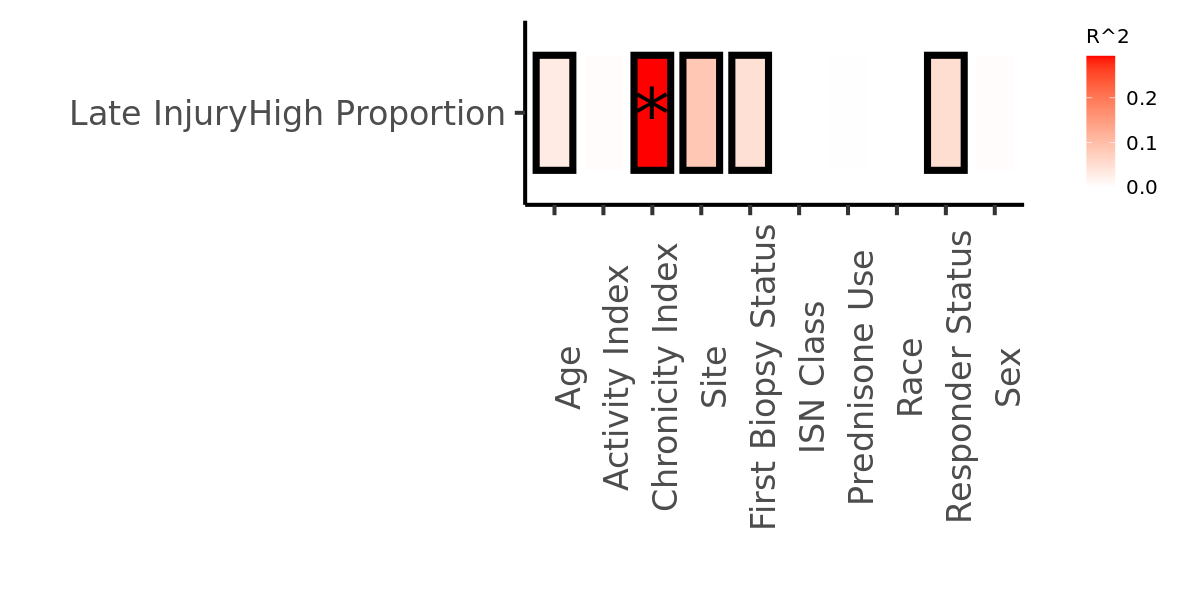

In [12]:
fig.size(5, 10)
p <- ggplot(data = cor_df %>% mutate(label = ifelse(bfpval < 0.05, '*', NA)),
               aes(y = Variable1, x = Variable2, fill = as.numeric(correlation))) + 
    geom_tile(width = 0.75, height = 0.75) +
    geom_tile(data = cor_df %>% filter(pvalue < 0.05),
              color = "black", 
              width = 0.75, 
              height = 0.75,
              linewidth = 2) +
    geom_text(aes(label = label), size = 15) +  
    scale_fill_gradient2(low = "white",
                         high = "red") + 
    theme_classic(base_size = 25) + 
    labs(x = "", y = "", fill = "R^2") + 
    theme(legend.title = element_text(size = 12),
          legend.text = element_text(size = 12),
          axis.text.x = element_text(angle = 90),
          text=element_text(family="Arial")) + 
    scale_y_discrete(labels = c("Late InjuryHigh Proportion")) + 
    scale_x_discrete(labels = c("Age", 
                                'Activity Index', 
                                'Chronicity Index',
                                'Site',
                                'First Biopsy Status', 
                                'ISN Class',
                                'Prednisone Use',
                                'Race',
                                'Responder Status', 
                                'Sex'))
cowplot::save_plot("/data/srlab/ssg34/SLE_kidney_v2/figures/extended_data/figure9/figure9d.png",
                   p,
                   base_height = 5,
                   base_width = 10)
p

## All cell type/state proportions

In [6]:
all_meta <- read.csv('/data/srlab/ssg34/share/for_Roopa/QC_Annotated_Full_Kidney_Meta_sc_sn_03292024.csv')

In [9]:
all_meta %>% dim

[1] 681075     10

In [11]:
all_meta$dataset %>% table

.
scRNAseq snRNAseq 
  538194   142881 

In [10]:
all_meta %>% colnames
all_meta %>% head(2)

[1] "cell"             "sample"           "dataset"          "Site"            
 [5] "processing.batch" "Type"             "nFeature_RNA"     "nCount_RNA"      
 [9] "annotation"       "cell.type"

,cell,sample,dataset,Site,processing.batch,Type,nFeature_RNA,nCount_RNA,annotation,cell.type
,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<chr>
1,AAGTGAAGTTACACTG-1-AMPSLEkid_cells_0142,AMPSLEkid_cells_0142,scRNAseq,Rochester,29,LN,866,1597,PT0. Late Injuryhigh,Proximal Tubule
2,AGGTTGTGTACTCCCT-1-AMPSLEkid_cells_0366,AMPSLEkid_cells_0366,scRNAseq,UCSF,34,LN,609,1214,PT0. Late Injuryhigh,Proximal Tubule


In [7]:
all_meta = all_meta %>% mutate(individual = str_split(sample, '_') %>% map(3) %>% unlist)

In [8]:
ct_props = all_meta %>%
    group_by(individual, dataset, cell.type) %>%
    summarise(count = n(), .groups = "drop") %>%
    group_by(individual, dataset) %>%
    mutate(proportion = count / sum(count))

ct_props = ct_props %>% merge(clinical %>% select(individual, Final_Chronicity), all= TRUE)

In [9]:
# State props within celltype 
cstate_props = all_meta %>%
    group_by(individual, dataset, cell.type, annotation) %>%
    summarise(count = n(), .groups = "drop") %>%
    group_by(individual, dataset, cell.type) %>%
    mutate(proportion = count / sum(count))

cstate_props = cstate_props %>% merge(clinical %>% select(individual, Final_Chronicity), all= TRUE)

In [24]:
cstate_props %>% filter(`cell.type` == 'Proximal Tubule') %>% 
    write_delim('../../tables/SupplementaryTablePTProps.csv', delim = ',')

In [10]:
# State props compared to all 
cstate_all_props = all_meta %>%
    group_by(individual, dataset, annotation) %>%
    summarise(count = n(), .groups = "drop") %>%
    group_by(individual, dataset) %>%
    mutate(proportion = count / sum(count))

cstate_all_props = cstate_all_props %>% merge(clinical %>% select(individual, Final_Chronicity), all= TRUE)

In [11]:
ct_corrs = ct_props %>% na.omit %>%
    group_by(dataset, cell.type) %>%
    summarise(correlation = cor(proportion, Final_Chronicity, use = "complete.obs"), .groups = "drop") %>% arrange(dataset, correlation)

In [12]:
ct_corrs %>% filter(dataset == 'scRNAseq') %>% arrange(desc(correlation))

dataset,cell.type,correlation
<chr>,<chr>,<dbl>
scRNAseq,T/NK,0.340360615
scRNAseq,B/Plasma,0.264376588
scRNAseq,Myeloid,0.119267853
scRNAseq,Glomerular,0.046116127
scRNAseq,Loop of Henle,0.002169240
scRNAseq,Interstitial,-0.003191578
scRNAseq,Proximal Tubule,-0.119589061
scRNAseq,Distal Nephron,-0.185154467


In [ ]:
ct_corrs

dataset,cell.type,correlation
<chr>,<chr>,<dbl>
scRNAseq,Distal Nephron,-0.185154467
scRNAseq,Proximal Tubule,-0.119589061
scRNAseq,Interstitial,-0.003191578
scRNAseq,Loop of Henle,0.002169240
scRNAseq,Glomerular,0.046116127
scRNAseq,Myeloid,0.119267853
scRNAseq,B/Plasma,0.264376588
scRNAseq,T/NK,0.340360615
snRNAseq,Glomerular,-0.312397932


In [13]:
cstate_corrs = cstate_props %>% na.omit %>%
    group_by(dataset, cell.type, annotation) %>%
    summarise(correlation = cor(proportion, Final_Chronicity, use = "complete.obs"), .groups = "drop") %>% arrange(dataset, correlation)

In [69]:
all_meta %>% nrow
all_meta %>% filter(annotation == 'LOH1. DTL/ATL') %>% nrow
all_meta %>% filter(annotation == 'DN4. SPP1high CNT') %>% nrow
all_meta %>% filter(annotation == 'PT0. Late Injuryhigh') %>% nrow

[1] 681075

[1] 45486

[1] 13026

[1] 54202

In [14]:
cstate_corrs %>% filter(dataset == 'scRNAseq') %>% arrange(desc(correlation))

dataset,cell.type,annotation,correlation
<chr>,<chr>,<chr>,<dbl>
scRNAseq,Loop of Henle,LOH1. DTL/ATL,0.630082126
scRNAseq,Distal Nephron,DN4. SPP1high CNT,0.548557225
scRNAseq,Proximal Tubule,PT0. Late Injuryhigh,0.541699104
scRNAseq,Proximal Tubule,PT7. DTL,0.451693051
scRNAseq,Myeloid,5. C1Qlo NUPR1hi Mac,0.421650459
scRNAseq,Loop of Henle,LOH4. Macula Densa,0.380360093
scRNAseq,Myeloid,17. MHC2hi cDC2,0.340329225
scRNAseq,Glomerular,GLOM1. SDK1high HDAC9high PEC,0.338268683
scRNAseq,T/NK,3. CD56bright NK,0.252226005


In [55]:
cstate_corrs

dataset,cell.type,annotation,correlation
<chr>,<chr>,<chr>,<dbl>
scRNAseq,Loop of Henle,LOH0. TAL,-0.6312005
scRNAseq,Loop of Henle,LOH2. C-TAL,-0.4776795
scRNAseq,Proximal Tubule,PT2. Low Quality,-0.3646451
scRNAseq,Proximal Tubule,PT3. PCK1high DXCRhigh S2/S3,-0.3521925
scRNAseq,Proximal Tubule,PT1. SLC7A7high ALBhigh S1/S2,-0.3356004
scRNAseq,Proximal Tubule,PT4. ANPEPhigh APOMhigh S1/S2,-0.3320945
scRNAseq,Myeloid,3. CD14+ CCL2+ Mono,-0.3055984
scRNAseq,T/NK,1. CTL,-0.3019927
scRNAseq,T/NK,2. SYNEhi CTL,-0.2924126


In [15]:
cstate_all_corrs = cstate_all_props %>% na.omit %>%
    group_by(dataset, annotation) %>%
    summarise(correlation = cor(proportion, Final_Chronicity, use = "complete.obs"), .groups = "drop") %>% arrange(dataset, correlation)

In [16]:
cstate_all_corrs %>% filter(dataset == 'scRNAseq') %>% arrange(desc(correlation))

dataset,annotation,correlation
<chr>,<chr>,<dbl>
scRNAseq,PT7. DTL,0.5836241
scRNAseq,LOH1. DTL/ATL,0.5305424
scRNAseq,PT0. Late Injuryhigh,0.4854936
scRNAseq,17. MHC2hi cDC2,0.4059407
scRNAseq,3. CD56bright NK,0.4039495
scRNAseq,13. GZMK+ CD8+ CD69+,0.3891954
scRNAseq,18. CD4+ RORC+ KLRB1+ CCR6+,0.3861238
scRNAseq,LOH4. Macula Densa,0.3770651
scRNAseq,17. ILCs,0.3739487


In [53]:
cstate_props

individual,dataset,cell.type,annotation,count,proportion,Final_Chronicity
<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<int>
0134,scRNAseq,B/Plasma,1. MHC2+ IGHM- B,53,0.31176471,6
0134,scRNAseq,B/Plasma,10. JCHAIN+ IGA+ IGL+ Plasma,5,0.02941176,6
0134,scRNAseq,B/Plasma,11. IGHG+ IGL+ Plasma,4,0.02352941,6
0134,scRNAseq,B/Plasma,2. IGHD+ FCER2+ CD22+ B,66,0.38823529,6
0134,scRNAseq,B/Plasma,3. CD24+ CD80+ IGHM+ B,10,0.05882353,6
0134,scRNAseq,B/Plasma,4. BCL11A+ TCF4+ IGHE+ B,4,0.02352941,6
0134,scRNAseq,B/Plasma,5. ITGAX+ TBX21+ B,7,0.04117647,6
0134,scRNAseq,B/Plasma,7. IGHG+ IGL- Plasma,10,0.05882353,6
0134,scRNAseq,B/Plasma,8. JCHAIN+ IGA+ IGL- Plasma,4,0.02352941,6


# LYMPHOID MYLEOID

In [36]:
T_NK_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/qcd/T_NK_clusterQCd_meta_harmonizedPCUMAPclusters_annotations02062024.rds') %>%
                select(- c(arnon_cluster, arnon_annotations)) %>% mutate(broad_cell_type = "T_NK", immune_type = "Lymphoid")
BP_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/qcd/BP_clusterQCd_cellstate_meta_annotations_09232022.rds') %>%
            select(- c(arnon_cluster)) %>% mutate(broad_cell_type = "B_Plasma", immune_type = "Lymphoid") 
Myeloid_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/qcd/Myeloid_clusterQCd_meta_harmonizedPCUMAPCellStateClusters_10042022.rds') %>% 
                mutate(broad_cell_type = "Myeloid Cell", immune_type = "Myeloid")

In [37]:
all_immune_meta <- rbind(T_NK_meta, BP_meta, Myeloid_meta)

In [39]:
saveRDS(all_immune_meta, "/data/srlab/ssg34/SLE_kidney_v2/data/qcd/qcd_all_immune_metadata_02062024.rds")

In [93]:
all_immune_norm <- readRDS('/data/srlab2/qxiao/AMP-SLE/sc_nuc_data/normalized_data_ScNuc_500nGene_1000nUMI_3pctnontargetMTwdoubletandsampleFINAL-8-10-22.rds')

In [2]:
clinical <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/clinical_data_05042023.rds') %>% rename(Final_Site = Site)

In [99]:
lymph_myeloid <- all_immune_meta %>% 
                    mutate(kid_sample = all_immune_meta$sample) %>% 
                    rowwise() %>% mutate(individual = str_split(kid_sample, '_')) %>% 
                    rowwise() %>% mutate(individual = unlist(individual)[3]) %>% 
                    filter(dataset == "scRNAseq", Type == "LN") %>%
                    select(individual, immune_type) %>% table() %>% 
                    prop.table(margin = 1) %>% data.frame()

In [124]:
ind_keep <- all_immune_meta %>% 
                mutate(kid_sample = all_immune_meta$sample) %>% 
                rowwise() %>% mutate(individual = str_split(kid_sample, '_')) %>% 
                rowwise() %>% mutate(individual = unlist(individual)[3]) %>%
                filter(dataset == "scRNAseq", Type == "LN") %>% 
                select(individual) %>% table() %>% data.frame() %>% filter(Freq > 50) %>% 
                pull('.')

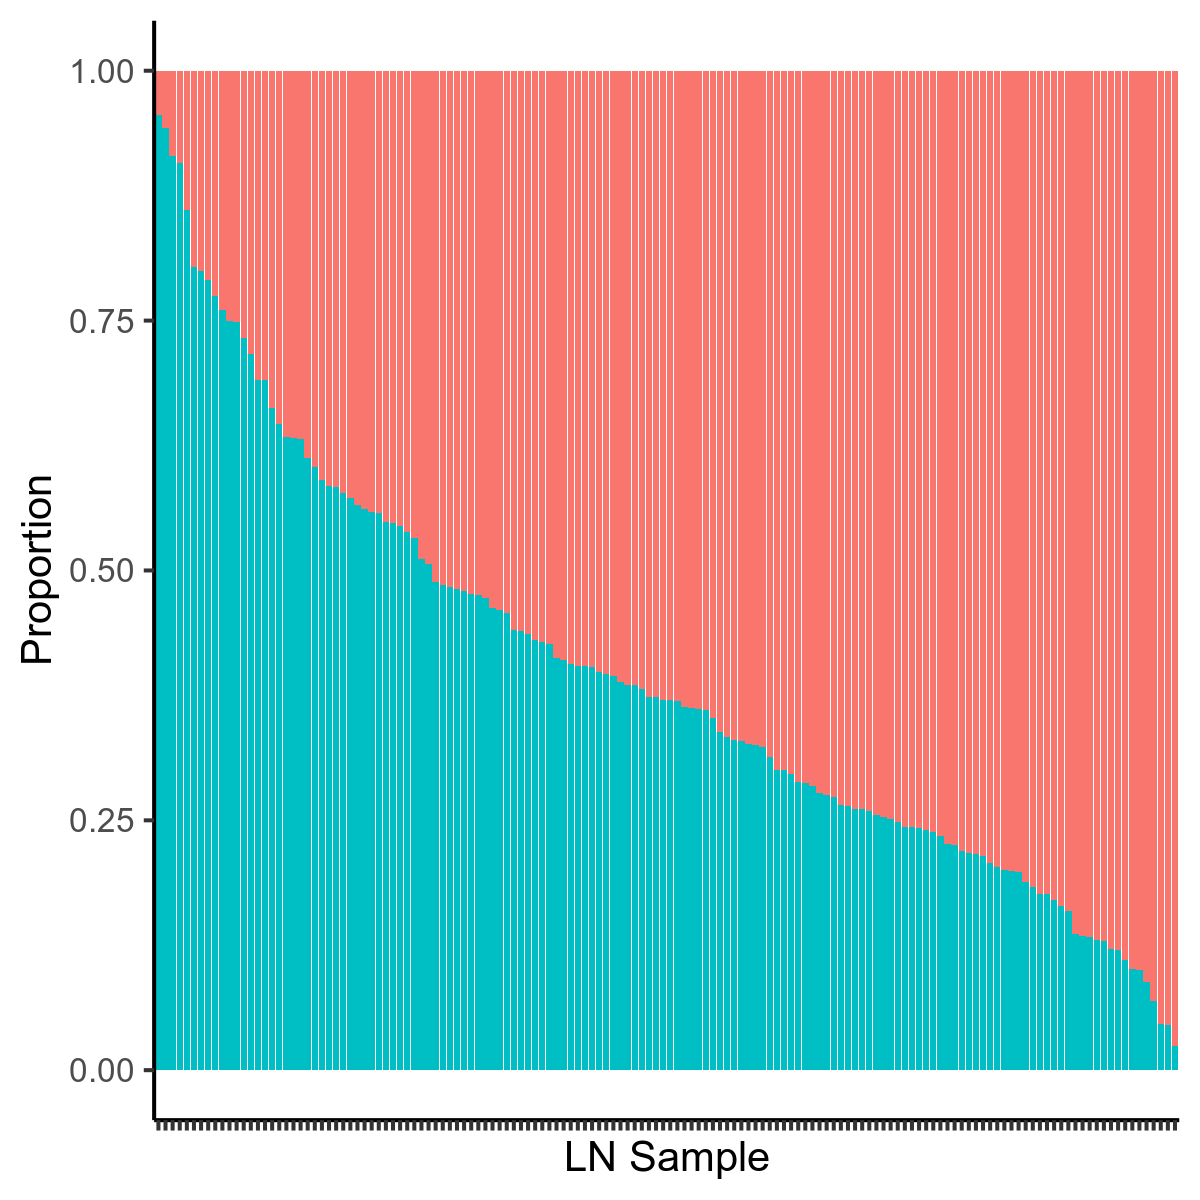

In [126]:
ggplot(lymph_myeloid %>% filter(individual %in% ind_keep), aes(x = individual, y = Freq, fill = immune_type)) + 
            geom_bar(stat = "identity", position = "stack") + 
            scale_x_discrete(limits = lymph_myeloid %>% 
                                            filter(individual %in% ind_keep,
                                                   immune_type == "Myeloid") %>% 
                                            arrange(desc(Freq)) %>% pull(individual)) + 
            theme_classic(base_size = 25) + 
            theme(axis.text.x = element_blank(),
                  legend.position = "none") + 
            labs(x = "LN Sample", y = "Proportion") 

In [129]:
lymph_myeloid <- lymph_myeloid %>% 
                    pivot_wider(names_from = "immune_type", values_from = "Freq") %>% 
                    left_join(clinical %>% select(individual, Final_Chronicity, Final_Activity, Final_ISN,
                                                  Responder.Status))

Joining, by = "individual"



	Pearson's product-moment correlation

data:  chron_df$Final_Chronicity and chron_df$Lymphoid
t = 3.764, df = 129, p-value = 0.0002528
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.151214 0.461219
sample estimates:
      cor 
0.3145802 


`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 13 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 13 rows containing missing values (`geom_point()`).”



	Pearson's product-moment correlation

data:  activity_df$Final_Activity and activity_df$Lymphoid
t = -1.8757, df = 129, p-value = 0.06295
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.325372819  0.008831297
sample estimates:
      cor 
-0.162941 


`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 13 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 13 rows containing missing values (`geom_point()`).”


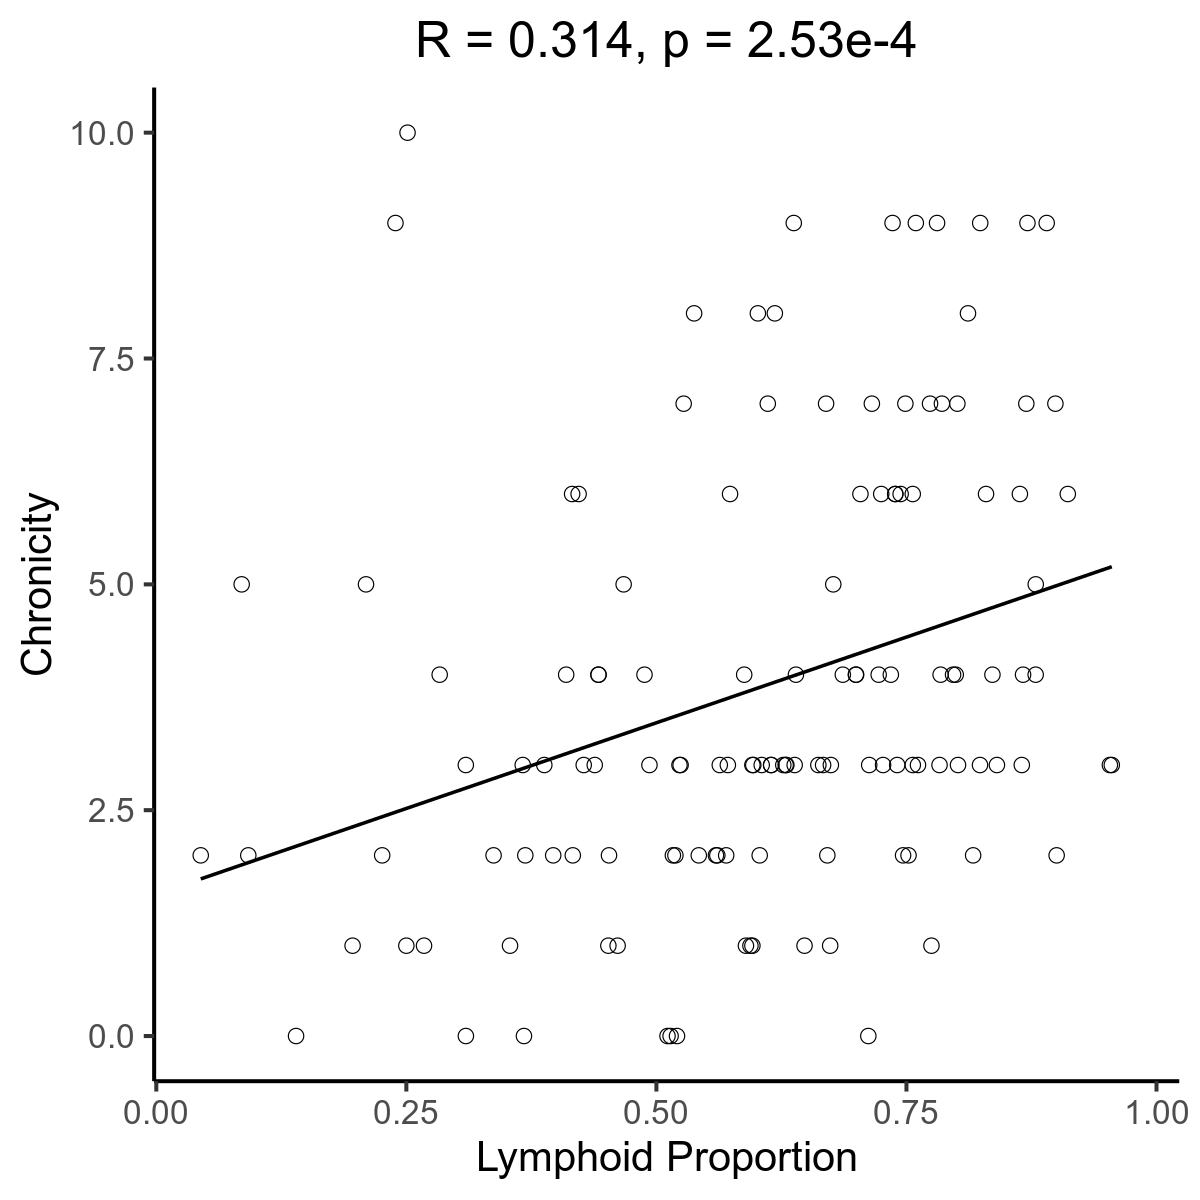

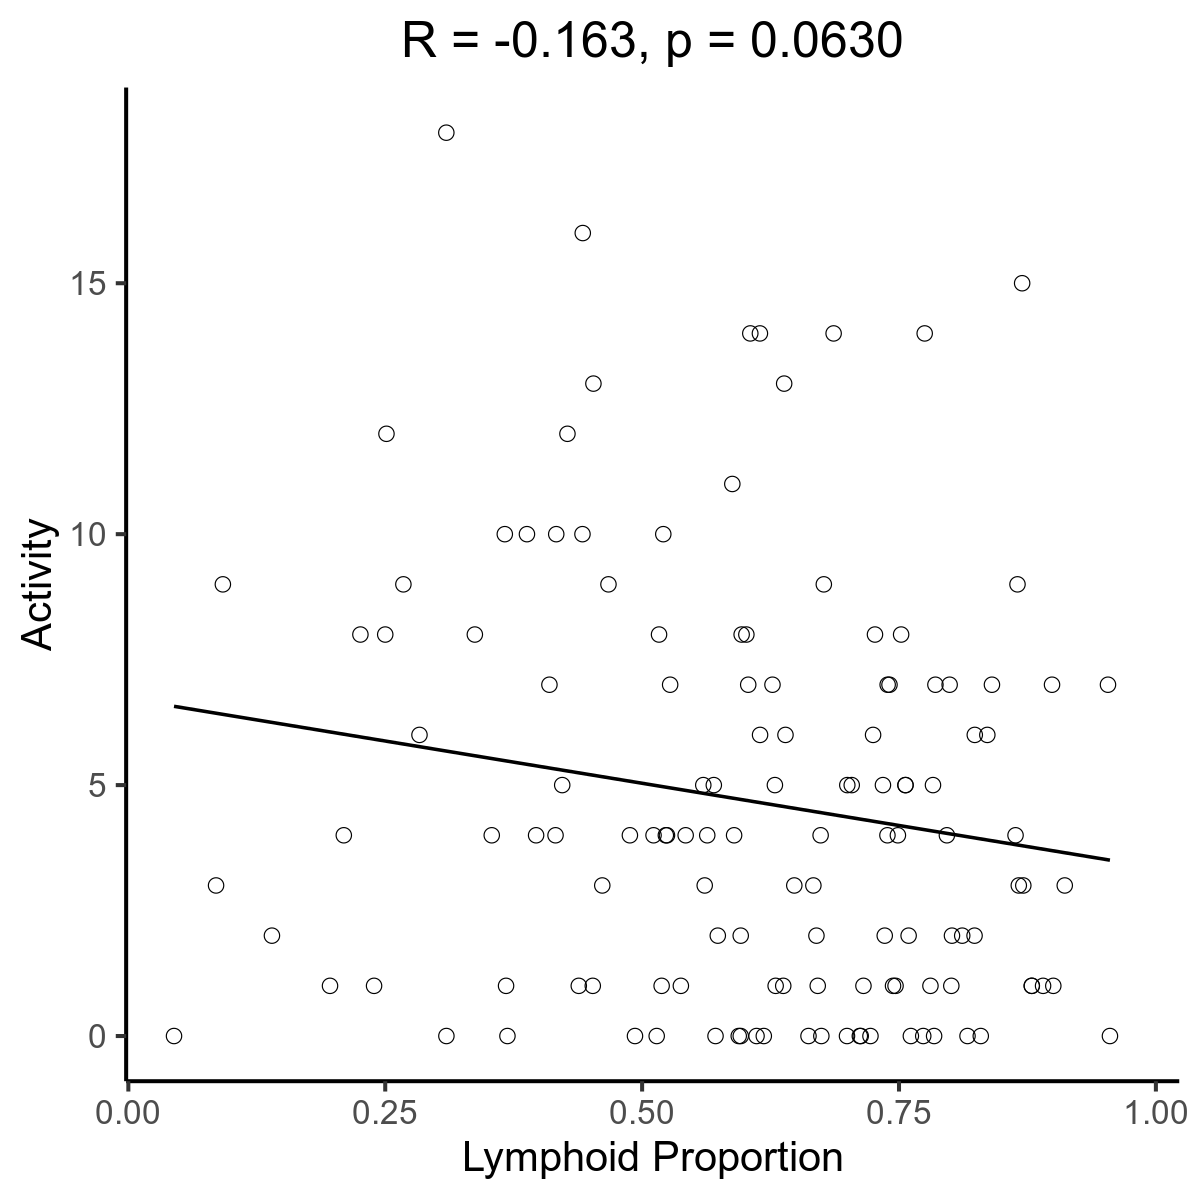

In [164]:
chron_df <- lymph_myeloid %>% 
                filter(individual %in% ind_keep) %>% 
                select(Final_Chronicity, Lymphoid) %>% na.omit()
cor.test(chron_df$Final_Chronicity, chron_df$Lymphoid)

ggplot(lymph_myeloid %>% filter(individual %in% ind_keep), 
           aes(x = Lymphoid, y = Final_Chronicity)) + 
    geom_point(shape = 1, size = 4) + 
    geom_smooth(method = "lm", se = FALSE, color = "black") + 
    theme_classic(base_size = 25) + 
    labs(x = "Lymphoid Proportion", y = "Chronicity",
         title = "R = 0.314, p = 2.53e-4") + 
    theme(plot.title = element_text(hjust = 0.5))



activity_df <- lymph_myeloid %>% 
                filter(individual %in% ind_keep) %>% 
                select(Final_Activity, Lymphoid) %>% na.omit()
cor.test(activity_df$Final_Activity, activity_df$Lymphoid)

ggplot(lymph_myeloid %>% filter(individual %in% ind_keep), 
           aes(x = Lymphoid, y = Final_Activity)) + 
    geom_point(shape = 1, size = 4) + 
    geom_smooth(method = "lm", se = FALSE, color = "black") + 
    theme_classic(base_size = 25) + 
    labs(x = "Lymphoid Proportion", y = "Activity",
         title = "R = -0.163, p = 0.0630") + 
    theme(plot.title = element_text(hjust = 0.5))


[1] FALSE


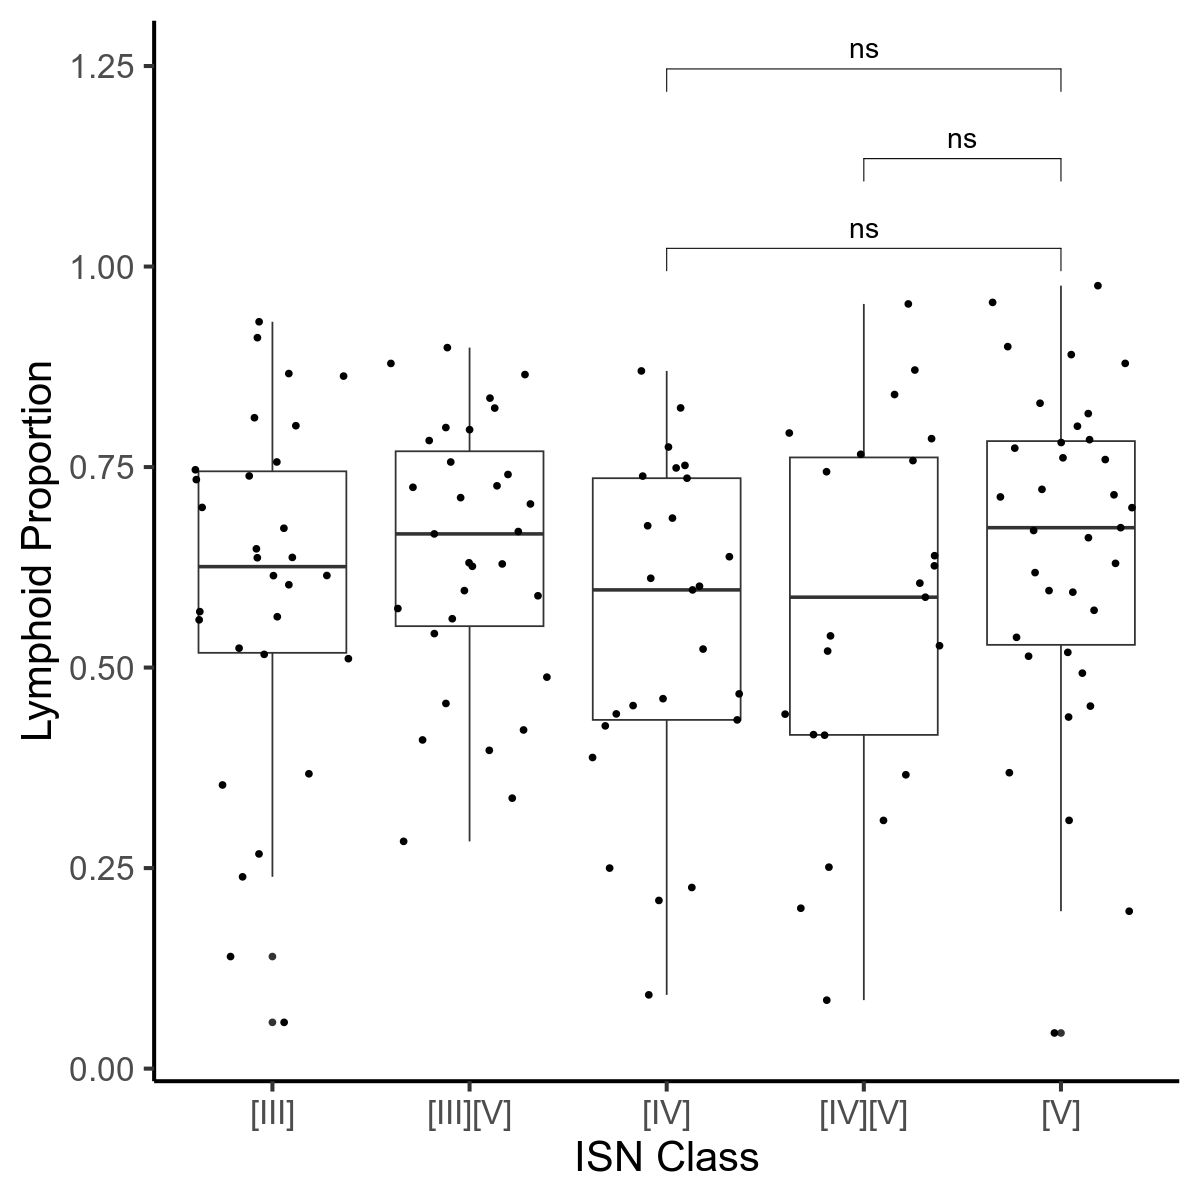

In [156]:
my_comparisons <- list(
                        c("[IV]", "[V]"),
                        c("[IV][V]", "[V]"),
                        c("[IV]", "[V]"))

ggplot(lymph_myeloid %>% filter(individual %in% ind_keep), aes(x = Final_ISN,
                                                               y = Lymphoid)) + 
    geom_boxplot() + 
    geom_jitter() + 
    theme_classic(base_size = 25) + 
    labs(x = "ISN Class", y = "Lymphoid Proportion") +
    ggpubr::stat_compare_means(label = "p.signif", method = "t.test", 
                               comparisons = my_comparisons, size = 6)

[1] FALSE


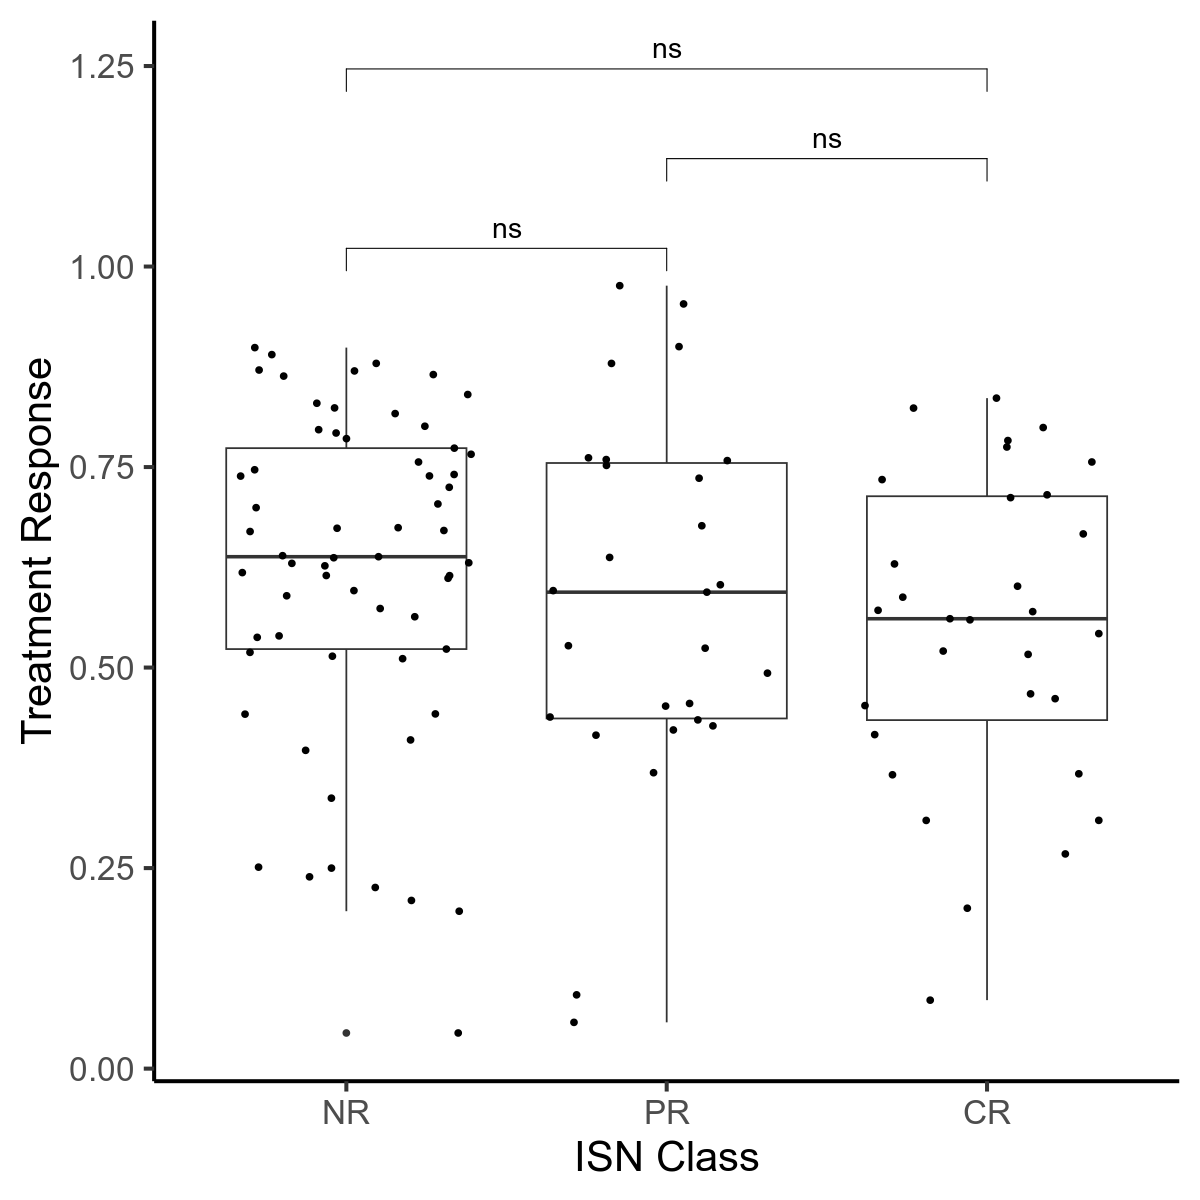

In [161]:
my_comparisons <- list(
                        c("NR", "PR"),
                        c("PR", "CR"),
                        c("NR", "CR"))

ggplot(lymph_myeloid %>% filter(individual %in% ind_keep,
                                Responder.Status %in% c("NR", "PR", "CR")), 
                                                              aes(x = Responder.Status,
                                                               y = Lymphoid)) + 
    geom_boxplot() + 
    geom_jitter() + 
    theme_classic(base_size = 25) + 
    labs(x = "ISN Class", y = "Treatment Response") +
    ggpubr::stat_compare_means(label = "p.signif", method = "t.test", 
                               comparisons = my_comparisons, size = 6) + 
    scale_x_discrete(limits = c("NR", "PR", "CR"))

# WITHIN CASE CNA RESULTS

In [1]:
tnk_univar <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/univariate_cna.csv')
myeloid_univar <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/myeloid/univariate_cna.csv')
pt_univar <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/univariate_cna.csv')


In [2]:
tnk_univar

X,Age,Sex,Responder_Status,Race,First_biopsy,Prednisone_use,Chronicity,Activity,ISN,Site
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0.07459254,0.2871713,0.00479952,0.5034497,0.00109989,0.1237876,0.00019998,0.3812619,0.2477752,0.05729427


# Chronicity correlations

In [5]:
clinical <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/clinical_data_05042023.rds') %>% rename(Final_Site = Site)

In [4]:
clinical_LN <- clinical %>% filter(Type == "LN")

In [5]:
first_biop_pred <- readRDS("/data/srlab2/qxiao/AMP-SLE/data/clinical/df_pred_biop.rds") %>% 
                        mutate(individual = str_split(Subject_ID, '-')) %>% 
                        rowwise() %>% 
                        mutate(individual = unlist(individual)[2])

In [6]:
clinical_LN <- clinical_LN %>% 
                select(Final_Chronicity, 
                       Final_Activity,
                       Final_ISN,
                       Age,
                       Sex,
                       Final_Site,
                       Race,
                       individual, 
                       Responder.Status) %>% 
                left_join(first_biop_pred %>% select(Pred_use, First_biop, individual)) %>% 
                mutate(Responder.Status = ifelse(Responder.Status %in% c("NR", "PR", "CR"), Responder.Status, NA)) %>% 
                left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                     Responder_Status = c(0, 1, 2))) %>% 
                mutate(Sex = ifelse(Sex == "Female", 0, 1))


clinical_LN <- clinical_LN %>% select(-c(Responder.Status, individual))

Joining with `by = join_by(individual)`
Joining with `by = join_by(Responder.Status)`


In [9]:
cor_df <- data.frame()

In [10]:
for (i in colnames(clinical_LN)[2:ncol(clinical_LN)]) {
    if (! i %in% c("Final_ISN", "Final_Site", "Race")) {
        df <- clinical_LN[, c("Final_Chronicity", i)] %>% na.omit()
        est <- cor.test(unlist(df[, "Final_Chronicity"]), unlist(df[, i]))$estimate ^ 2
        pval <- cor.test(unlist(df[, "Final_Chronicity"]), unlist(df[, i]))$p.value
        cor_df <- rbind(cor_df, 
                        data.frame("Final_Chronicity", i, est, pval))
    }
}
colnames(cor_df) <- c("Var1", "Var2", "Rsquared", "p.value")

In [7]:
clinical_LN <- fastDummies::dummy_cols(clinical_LN, "Final_ISN")

In [35]:
model_df <- clinical_LN[, c(1, grep('ISN', colnames(clinical_LN)))] %>% na.omit()
colnames(model_df) <- c('Final_Chronicity', 'FinalISNIII', 'FinalISNIIIV',
                        'FinalISNIV', 'FinalISNIVV', 'FinalISNV')
summary(lm(Final_Chronicity ~ FinalISNIIIV + FinalISNIV + FinalISNIVV + FinalISNV, data = model_df))
cor_df <- rbind(cor_df, data.frame("Var1" = c("Final_Chronicity"), 
                                   "Var2" = c("Final_ISN"), 
                                   "Rsquared" = 0.004995, 
                                   "p.value" = 0.3214))


Call:
lm(formula = Final_Chronicity ~ FinalISNIIIV + FinalISNIV + FinalISNIVV + 
    FinalISNV, data = model_df)

Residuals:
   Min     1Q Median     3Q    Max 
-4.632 -1.675 -0.675  1.358  5.844 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)   3.67500    0.38779   9.477   <2e-16 ***
FinalISNIIIV -0.51875    0.58169  -0.892    0.374    
FinalISNIV    0.04914    0.59817   0.082    0.935    
FinalISNIVV   0.36346    0.61786   0.588    0.557    
FinalISNV     0.95658    0.68336   1.400    0.164    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.453 on 141 degrees of freedom
Multiple R-squared:  0.03244,	Adjusted R-squared:  0.004995 
F-statistic: 1.182 on 4 and 141 DF,  p-value: 0.3214


In [8]:
clinical_LN <- fastDummies::dummy_cols(clinical_LN, "Race")

In [42]:
model_df <- clinical_LN[, c(1, grep('Race', colnames(clinical_LN)))] %>% na.omit()
colnames(model_df) <- c('Final_Chronicity', 'Race_A', 'Race_AB', 'Race_B',
                       'Race_BAI', 'Race_BW', 'Race_U', 'Race_W')
summary(lm(Final_Chronicity ~ Race_A + Race_AB + Race_B + Race_BAI + Race_BW + Race_U, data = model_df))
cor_df <- rbind(cor_df, data.frame("Var1" = c("Final_Chronicity"), 
                                   "Var2" = c("Race"), 
                                   "Rsquared" = -0.01979, 
                                   "p.value" = 0.7839))


Call:
lm(formula = Final_Chronicity ~ Race_A + Race_AB + Race_B + Race_BAI + 
    Race_BW + Race_U, data = model_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.9420 -1.7500 -0.7083  1.9463  6.2500 

Coefficients: (5 not defined because of singularities)
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)     3.3889     0.5852   5.791 4.47e-08 ***
Race_A[A][B]   -0.3889     2.5510  -0.152    0.879    
Race_A[B]       0.5531     0.6572   0.842    0.401    
Race_A[B][AI]  -3.3889     2.5510  -1.328    0.186    
Race_A[B][W]    0.6111     2.5510   0.240    0.811    
Race_A[U]       0.2778     0.9254   0.300    0.764    
Race_A[W]       0.3611     0.6947   0.520    0.604    
Race_AB             NA         NA      NA       NA    
Race_B              NA         NA      NA       NA    
Race_BAI            NA         NA      NA       NA    
Race_BW             NA         NA      NA       NA    
Race_U              NA         NA      NA       NA    
---
Signif. codes

In [9]:
clinical_LN <- fastDummies::dummy_cols(clinical_LN, "Final_Site")

In [44]:
model_df <- clinical_LN[, c(1, grep('Site', colnames(clinical_LN)))] %>% na.omit()
colnames(model_df)[2] <- "Final_Site_Cedars_Sinai"
colnames(model_df)[11] <- 'Final_Site_Texas_Tech'
summary(lm(Final_Chronicity ~ Final_Site_JHU + Final_Site_NYU, data = model_df))
cor_df <- rbind(cor_df, data.frame("Var1" = c("Final_Chronicity"), 
                                   "Var2" = c("Site"), 
                                   "Rsquared" = -0.003338, 
                                   "p.value" = 0.4701))


Call:
lm(formula = Final_Chronicity ~ Final_Site_JHU + Final_Site_NYU, 
    data = model_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.1304 -1.5849 -0.5849  1.7559  6.4151 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)     3.59574    0.35925  10.009   <2e-16 ***
Final_Site_JHU  0.53469    0.51081   1.047    0.297    
Final_Site_NYU -0.01084    0.49346  -0.022    0.983    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.463 on 143 degrees of freedom
Multiple R-squared:  0.0105,	Adjusted R-squared:  -0.003338 
F-statistic: 0.7588 on 2 and 143 DF,  p-value: 0.4701


In [45]:
colnames(cor_df) <- c("Variable1", "Variable2", "correlation", "pvalue")

In [ ]:
plot_df <- cor_df %>% mutate(correlation = as.numeric(correlation),
                             pvalue = as.numeric(pvalue))
plot_df$bfpval <- p.adjust(plot_df$pvalue, method = "bonferroni")

In [52]:
clinical_LN %>% colnames

[1] "Final_Chronicity"        "Final_Activity"         
 [3] "Final_ISN"               "Age"                    
 [5] "Sex"                     "Final_Site"             
 [7] "Race"                    "Pred_use"               
 [9] "First_biop"              "Responder_Status"       
[11] "Final_ISN_[III]"         "Final_ISN_[III][V]"     
[13] "Final_ISN_[IV]"          "Final_ISN_[IV][V]"      
[15] "Final_ISN_[V]"           "Race_[A]"               
[17] "Race_[A][B]"             "Race_[B]"               
[19] "Race_[B][AI]"            "Race_[B][W]"            
[21] "Race_[U]"                "Race_[W]"               
[23] "Final_Site_Cedars-Sinai" "Final_Site_Cincinnati"  
[25] "Final_Site_Einstein"     "Final_Site_JHU"         
[27] "Final_Site_Michigan"     "Final_Site_MUSC"        
[29] "Final_Site_Northwell"    "Final_Site_NYU"         
[31] "Final_Site_Rochester"    "Final_Site_Texas Tech"  
[33] "Final_Site_UCLA"         "Final_Site_UCSD"        
[35] "Final_Site_UCSF"

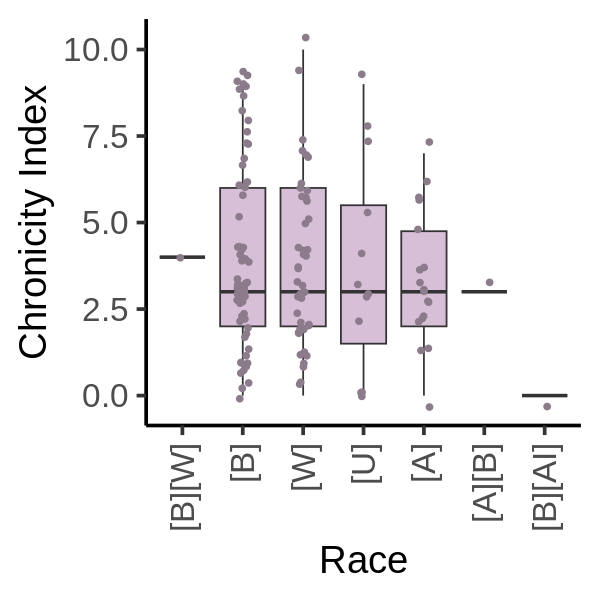

In [ ]:
x_order = (clinical_LN %>% group_by(Race) %>% summarise(Final_Chronicity = mean(Final_Chronicity, na.rm = TRUE)) %>% 
    arrange(Final_Chronicity) %>% drop_na)$Race %>% rev

fig.size(5, 5)
ggplot(clinical_LN %>% 
           select(Race, Final_Chronicity) %>% 
           na.omit(), aes(x = factor(Race), y = Final_Chronicity)) + 
    geom_boxplot(fill = 'thistle', outlier.shape = NA) +
    geom_jitter(width = .1, height = .4, , col = 'thistle4')+
    theme_classic(base_size = 23) + 
    scale_x_discrete(limits = x_order) + 
    labs(x = "Race", y = "Chronicity Index") +
    theme(text = element_text(family = "Arial"),
          axis.text.x = element_text(angle = 90, hjust = 1,  vjust = 0.5),
          axis.text = element_text(size = labelfontsize))

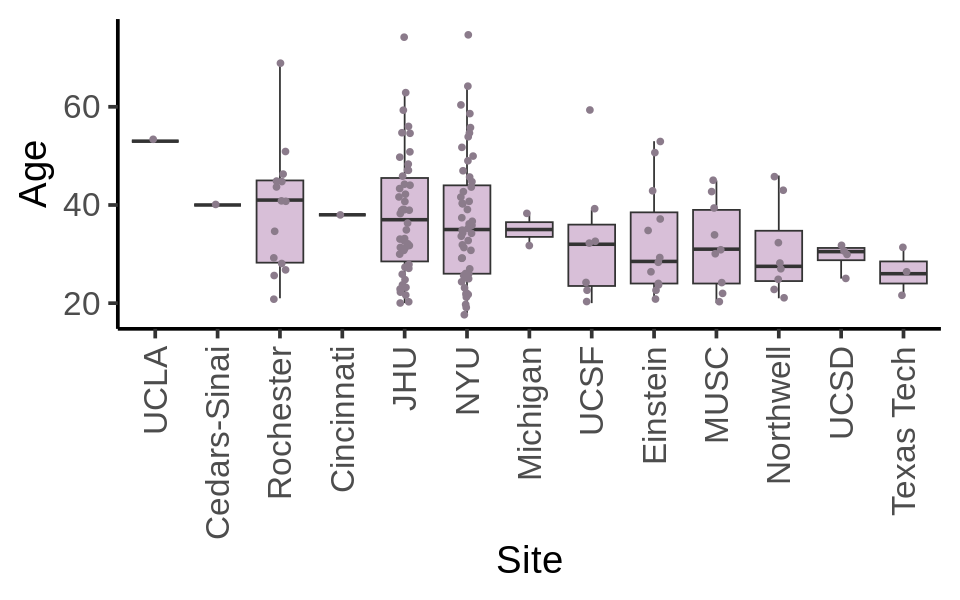

In [53]:
x_order = (clinical_LN %>% group_by(Final_Site) %>% summarise(Age = mean(Age, na.rm = TRUE)) %>% 
    arrange(Age) %>% drop_na)$Final_Site %>% rev

fig.size(5, 8)
ggplot(clinical_LN %>% 
           select(Final_Site, Age) %>% 
           na.omit(), aes(x = factor(Final_Site), y = Age)) + 
    geom_boxplot(fill = 'thistle', outlier.shape = NA) +
    geom_jitter(width = .1, height = .4, , col = 'thistle4')+
    theme_classic(base_size = 23) + 
    scale_x_discrete(limits = x_order) + 
    labs(x = "Site", y = "Age") +
    theme(text = element_text(family = "Arial"),
          axis.text.x = element_text(angle = 90, hjust = 1,  vjust = 0.5),
          axis.text = element_text(size = labelfontsize))



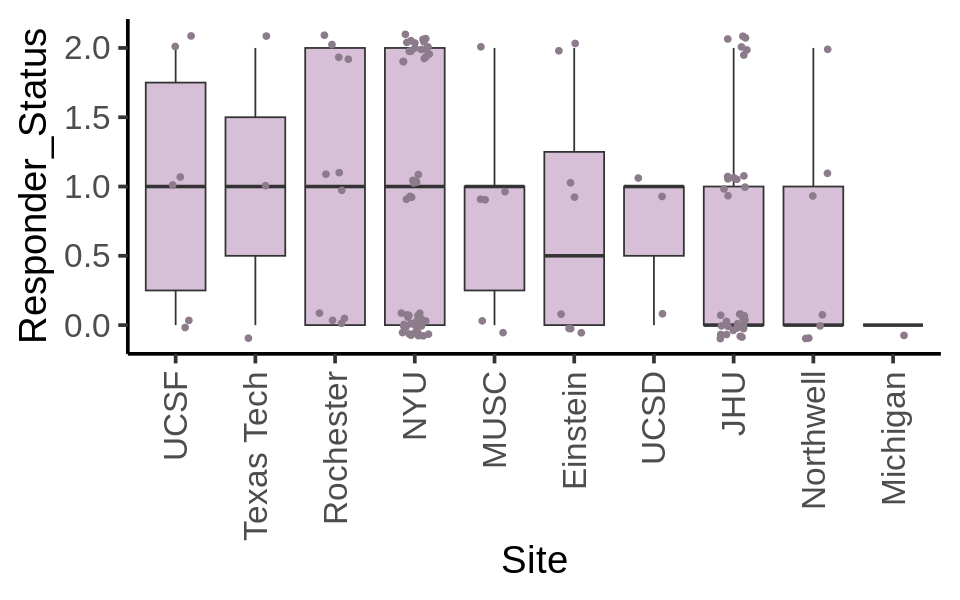

In [66]:
x_order = (clinical_LN %>% group_by(Final_Site) %>% summarise(Responder_Status = mean(Responder_Status, na.rm = TRUE)) %>% 
    arrange(Responder_Status) %>% drop_na)$Final_Site %>% rev

fig.size(5, 8)
ggplot(clinical_LN %>% 
           select(Final_Site, Responder_Status) %>% 
           na.omit(), aes(x = factor(Final_Site), y = Responder_Status)) + 
    geom_boxplot(fill = 'thistle', outlier.shape = NA) +
    geom_jitter(width = .2, height = .1, , col = 'thistle4')+
    theme_classic(base_size = 23) + 
    scale_x_discrete(limits = x_order) + 
    labs(x = "Site", y = "Responder_Status") +
    theme(text = element_text(family = "Arial"),
          axis.text.x = element_text(angle = 90, hjust = 1,  vjust = 0.5),
          axis.text = element_text(size = labelfontsize))



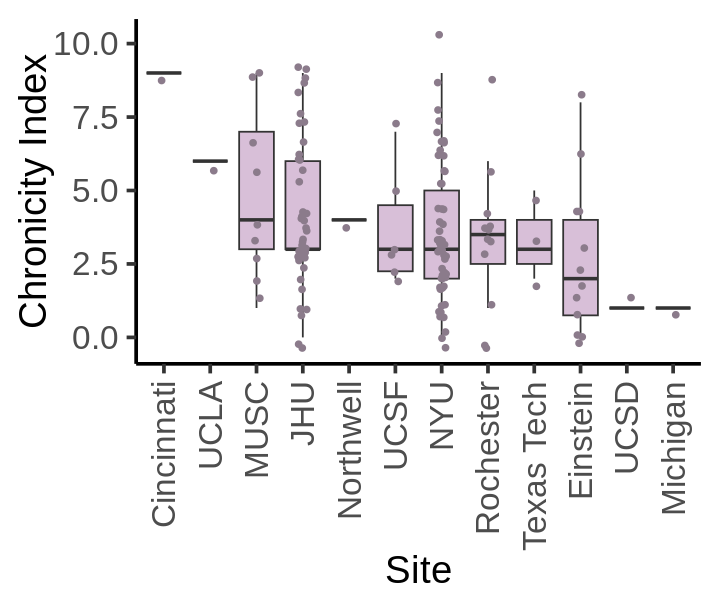

In [13]:
x_order = (clinical_LN %>% group_by(Final_Site) %>% summarise(Final_Chronicity = mean(Final_Chronicity, na.rm = TRUE)) %>% 
    arrange(Final_Chronicity) %>% drop_na)$Final_Site %>% rev

fig.size(5, 7)
p = ggplot(clinical_LN %>% 
           select(Final_Site, Final_Chronicity) %>% 
           na.omit(), aes(x = factor(Final_Site), y = Final_Chronicity)) + 
    geom_boxplot(fill = 'thistle', outlier.shape = NA) +
    geom_jitter(width = .1, height = .4, , col = 'thistle4')+
    theme_classic(base_size = 23) + 
    scale_x_discrete(limits = x_order) + 
    labs(x = "Site", y = "Chronicity Index") +
    theme(text = element_text(family = "Arial"),
          axis.text.x = element_text(angle = 90, hjust = 1,  vjust = 0.5),
          axis.text = element_text(size = labelfontsize))

height = 5
width = 6
fig.size(height, width)
outplot = p
outplot


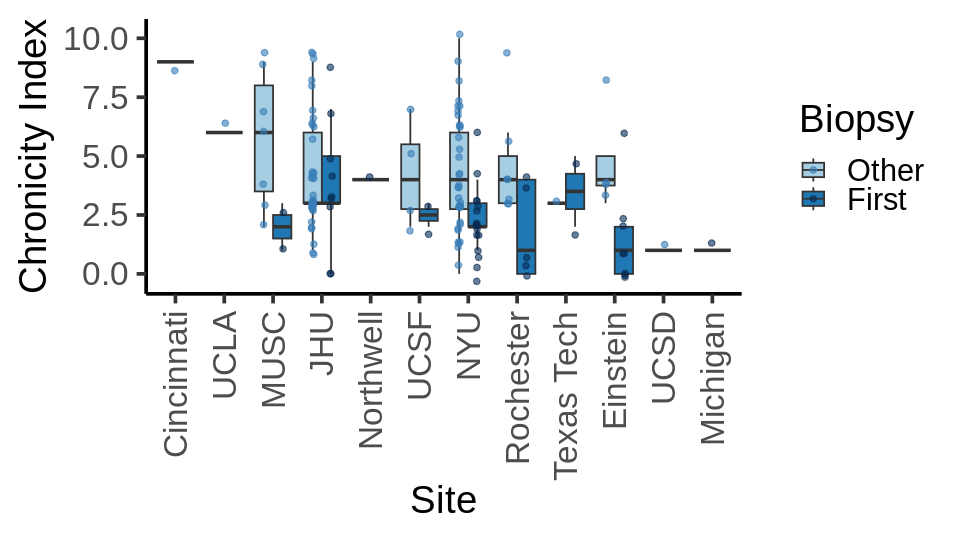

In [153]:
# Define custom colors
box_colors <- c("0" = "#A6CEE3", "1" = "#1F78B4")  # Light blue, darker blue
point_colors <- c("0" = "#377EB8", "1" = "#052b53")  # Slightly darker tones

# Custom labels
biopsy_labels <- c("0" = "Other", "1" = "First")

x_order = (clinical_LN %>% group_by(Final_Site) %>% summarise(Final_Chronicity = mean(Final_Chronicity, na.rm = TRUE)) %>% 
    arrange(Final_Chronicity) %>% drop_na)$Final_Site %>% rev

dodge_width = 0.75
p1 = ggplot(clinical_LN %>% 
           select(Final_Site, Final_Chronicity, First_biop) %>% 
           na.omit(), aes(x = factor(Final_Site), y = Final_Chronicity)) + 
    geom_boxplot(aes(fill = as.factor(First_biop)), outlier.shape = NA, 
                 position = position_dodge(width = dodge_width)) +
  geom_jitter(aes(color = as.factor(First_biop), 
                  group = interaction(Final_Site, First_biop)), 
              position = position_jitterdodge(jitter.width = 0.1, dodge.width = dodge_width, jitter.height = 0.4),
              alpha = 0.6, size = 1.5) +
    theme_classic(base_size = 23) + 
    scale_x_discrete(limits = x_order) + 
      scale_fill_manual(values = box_colors, labels = biopsy_labels, name = "Biopsy") +
      scale_color_manual(values = point_colors, labels = biopsy_labels, name = "Biopsy") +
    labs(x = "Site", y = "Chronicity Index") +
    theme(text = element_text(family = "Arial"),legend.justification = 'left',
          axis.text.x = element_text(angle = 90, hjust = 1,  vjust = 0.5),
          axis.text = element_text(size = labelfontsize))

height = 4.5
width = 8
fig.size(height, width)
outplot = p1
outplot

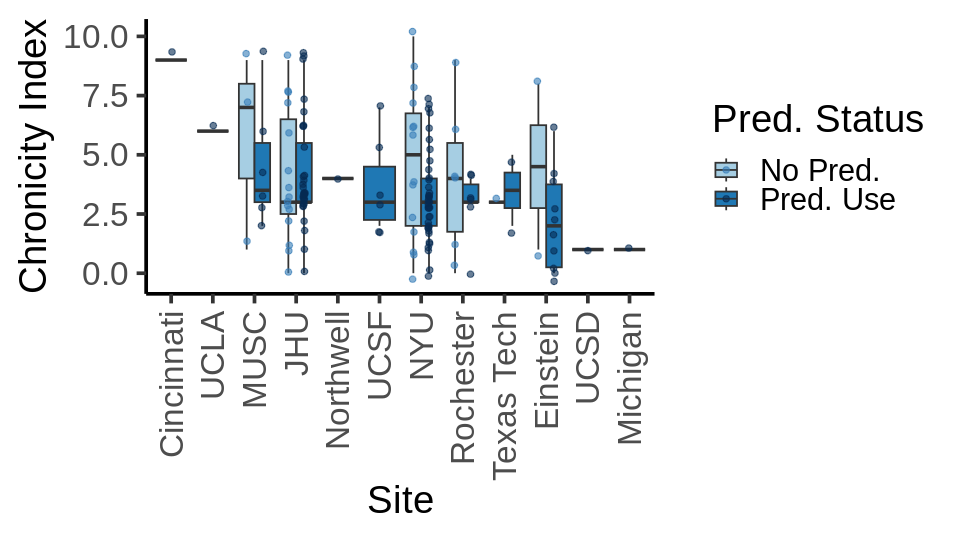

In [154]:
# Custom labels
biopsy_labels <- c("0" = "No Pred.", "1" = "Pred. Use")

x_order = (clinical_LN %>% group_by(Final_Site) %>% summarise(Final_Chronicity = mean(Final_Chronicity, na.rm = TRUE)) %>% 
    arrange(Final_Chronicity) %>% drop_na)$Final_Site %>% rev

dodge_width = 0.75
p2 = ggplot(clinical_LN %>% 
           select(Final_Site, Final_Chronicity, Pred_use) %>% 
           na.omit(), aes(x = factor(Final_Site), y = Final_Chronicity)) + 
    geom_boxplot(aes(fill = as.factor(Pred_use)), outlier.shape = NA, 
                 position = position_dodge(width = dodge_width)) +
  geom_jitter(aes(color = as.factor(Pred_use), 
                  group = interaction(Final_Site, Pred_use)), 
              position = position_jitterdodge(jitter.width = 0.1, dodge.width = dodge_width, jitter.height = 0.4),
              alpha = 0.6, size = 1.5) +
    theme_classic(base_size = 23) + 
    scale_x_discrete(limits = x_order) + 
      scale_fill_manual(values = box_colors, labels = biopsy_labels, name = "Pred. Status") +
      scale_color_manual(values = point_colors, labels = biopsy_labels, name = "Pred. Status") +
    labs(x = "Site", y = "Chronicity Index") +
    theme(text = element_text(family = "Arial"),legend.justification = 'left',
          axis.text.x = element_text(angle = 90, hjust = 1,  vjust = 0.5),
          axis.text = element_text(size = labelfontsize))

height = 4.5
width = 8
fig.size(height, width)
outplot = p2
outplot

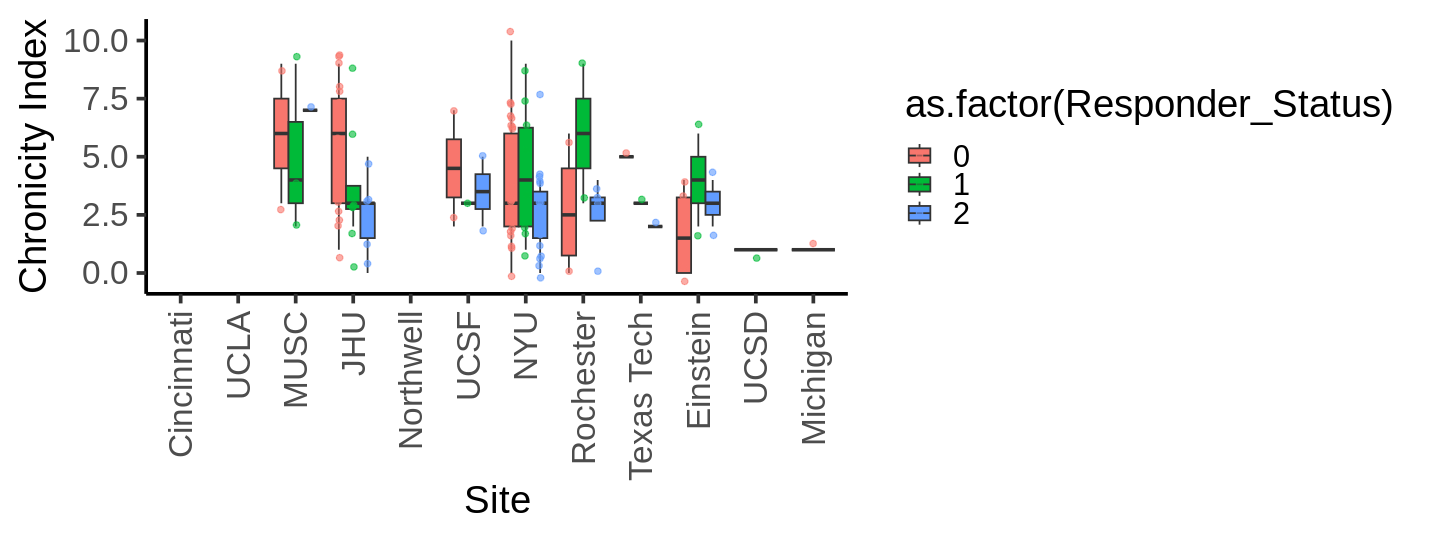

In [12]:
# Custom labels
# biopsy_labels <- c("0" = "No Pred.", "1" = "Pred. Use")

x_order = (clinical_LN %>% group_by(Final_Site) %>% summarise(Final_Chronicity = mean(Final_Chronicity, na.rm = TRUE)) %>% 
    arrange(Final_Chronicity) %>% drop_na)$Final_Site %>% rev

dodge_width = 0.75
p3 = ggplot(clinical_LN %>% 
           select(Final_Site, Final_Chronicity, Responder_Status) %>% 
           na.omit(), aes(x = factor(Final_Site), y = Final_Chronicity)) + 
    geom_boxplot(aes(fill = as.factor(Responder_Status)), outlier.shape = NA, 
                 position = position_dodge(width = dodge_width)) +
  geom_jitter(aes(color = as.factor(Responder_Status), 
                  group = interaction(Final_Site, Responder_Status)), 
              position = position_jitterdodge(jitter.width = 0.1, dodge.width = dodge_width, jitter.height = 0.4),
              alpha = 0.6, size = 1.5) +
    theme_classic(base_size = 23) + 
    scale_x_discrete(limits = x_order) + 
      # scale_fill_manual(values = box_colors, labels = biopsy_labels, name = "Pred. Status") +
      # scale_color_manual(values = point_colors, labels = biopsy_labels, name = "Pred. Status") +
    labs(x = "Site", y = "Chronicity Index") +
    theme(text = element_text(family = "Arial"),legend.justification = 'left',
          axis.text.x = element_text(angle = 90, hjust = 1,  vjust = 0.5),
          axis.text = element_text(size = labelfontsize))

height = 4.5
width = 12
fig.size(height, width)
outplot = p3
outplot

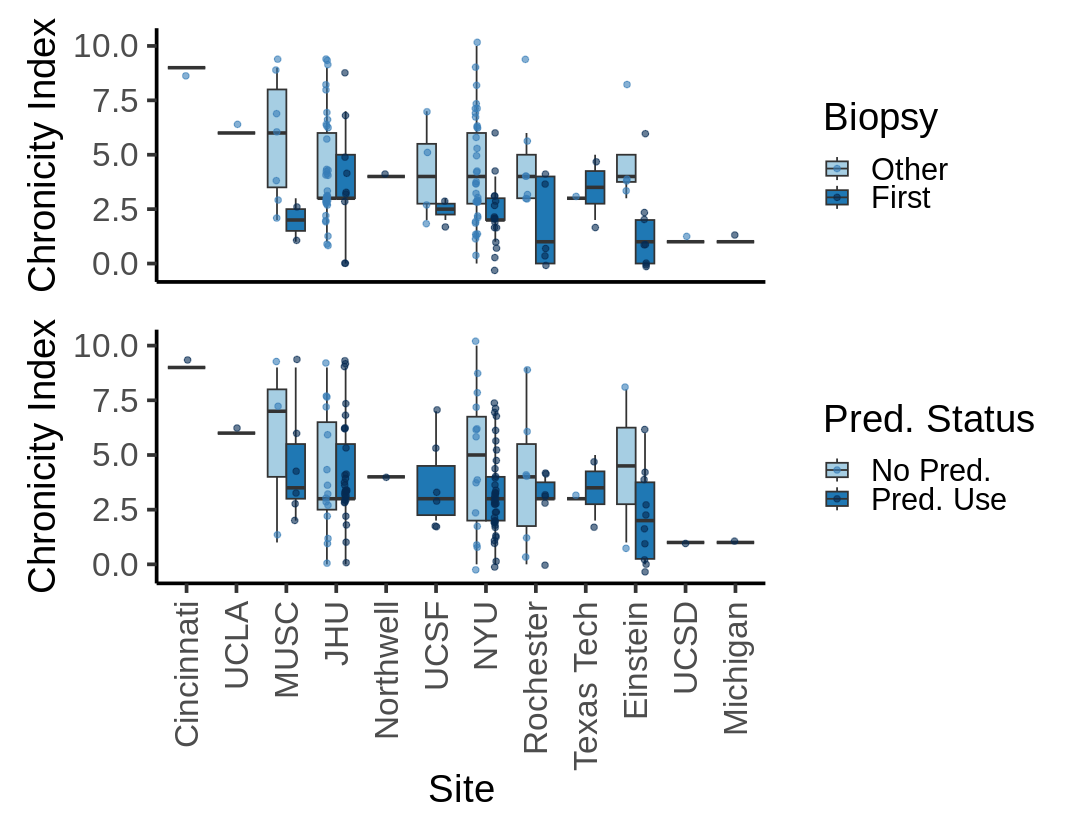

In [156]:
height = 7
width = 9
fig.size(height, width)
outplot = (p1 + theme(axis.text.x = element_blank(), axis.title.x = element_blank(),
                      axis.ticks.x = element_blank())) + p2 + plot_layout(nrow = 2)
outplot

ggsave(paste0(figdir, 'chronicity_site.png'), plot = outplot,  
       height = height, width = width, dpi = 500)
ggsave(paste0(figdir, 'chronicity_site.pdf'), plot = outplot,  
       height = height, width = width, dpi = 500, device = cairo_pdf)


In [28]:
x_order = (clinical_LN %>% group_by(Final_Site) %>% summarise(Final_Chronicity = mean(Final_Chronicity, na.rm = TRUE)) %>% 
    arrange(Final_Chronicity) %>% drop_na)$Final_Site %>% rev
x_order_filt = (clinical_LN %>% select(Final_Site, Final_Chronicity) %>% na.omit())$Final_Site %>% table
x_order_filt = x_order_filt[x_order_filt<2] %>% names
x_order = setdiff(x_order, x_order_filt)

In [30]:
clinical_LN_filt = clinical_LN %>% filter(Final_Site %in% x_order)

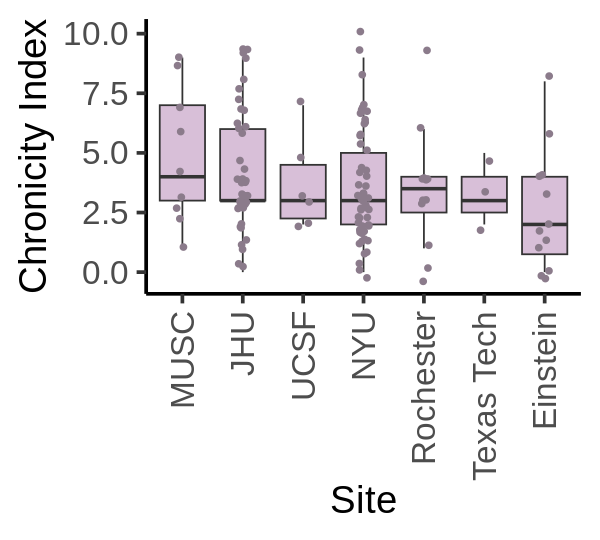

In [33]:
fig.size(5, 7)
p = ggplot(clinical_LN_filt %>% 
           select(Final_Site, Final_Chronicity) %>% 
           na.omit(), aes(x = factor(Final_Site), y = Final_Chronicity)) + 
    geom_boxplot(fill = 'thistle', outlier.shape = NA) +
    geom_jitter(width = .1, height = .4, , col = 'thistle4')+
    theme_classic(base_size = 23) + 
    scale_x_discrete(limits = x_order) + 
    labs(x = "Site", y = "Chronicity Index") +
    theme(text = element_text(family = "Arial"),
          axis.text.x = element_text(angle = 90, hjust = 1,  vjust = 0.5),
          axis.text = element_text(size = labelfontsize))

height = 4.5
width = 5
fig.size(height, width)
outplot = p
outplot


In [66]:
prop_df <- clinical_LN_filt %>%
  group_by(Final_Site) %>%
  summarise(First_biop0_Prop = sum(First_biop==0, na.rm = TRUE) / sum(!is.na(First_biop)),
            First_biop1_Prop = sum(First_biop==1, na.rm = TRUE) / sum(!is.na(First_biop)),
           Responder_Status0Prop = sum(Responder_Status==0, na.rm = TRUE) / sum(!is.na(Responder_Status)),
          Responder_Status1Prop = sum(Responder_Status==1, na.rm = TRUE) / sum(!is.na(Responder_Status)),
          Responder_Status2Prop = sum(Responder_Status==2, na.rm = TRUE) / sum(!is.na(Responder_Status))) %>%
    as.data.frame


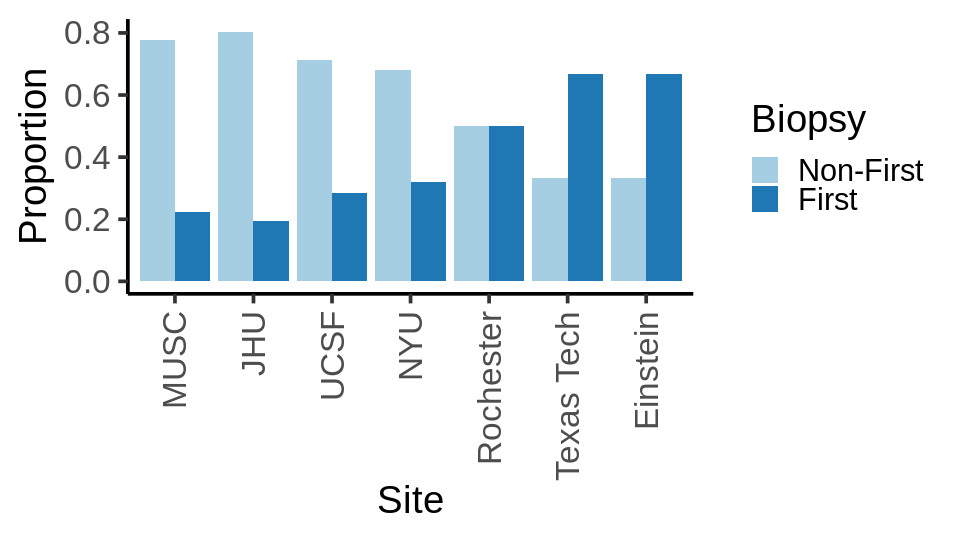

In [91]:
# Custom labels
box_colors <- c("First_biop0_Prop" = "#A6CEE3", "First_biop1_Prop" = "#1F78B4")  # Light blue, darker blue
col_labels <- c("First_biop0_Prop" = "Non-First", "First_biop1_Prop" = "First")

dat = prop_df %>% pivot_longer(cols = c('First_biop0_Prop', 'First_biop1_Prop'))

barplot = ggplot(dat)+
    geom_bar(aes(x = Final_Site, y = value, fill = name), stat="identity", position=position_dodge())+
    theme_classic(base_size = 23) + 
    scale_x_discrete(limits = x_order) + 
    labs(x = "Site", y = "Proportion") +
  scale_fill_manual(values = box_colors, labels = col_labels, name = "Biopsy") +
    theme(text = element_text(family = "Arial"),
          axis.text.x = element_text(angle = 90, hjust = 1,  vjust = 0.5),
          axis.text = element_text(size = labelfontsize))

height = 4.5
width = 8
fig.size(height, width)
outplot = barplot
outplot


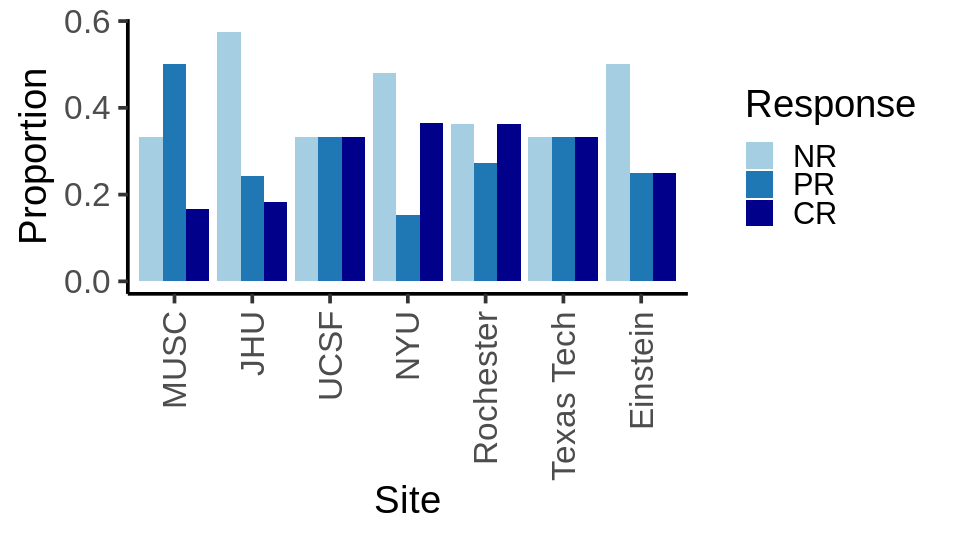

In [90]:
# # Custom labels
# box_colors <- c("Responder_Status0Prop" = "#A6CEE3", "Responder_Status1Prop" = "#1F78B4",
#                "Responder_Status2Prop" = 'darkblue')  # Light blue, darker blue
# col_labels <- c("Responder_Status0Prop" = "NR", "Responder_Status1Prop" = "PR",
#                "Responder_Status2Prop" = "CR")

# dat = prop_df %>% pivot_longer(cols = c('Responder_Status0Prop', 'Responder_Status1Prop',
#                                        'Responder_Status2Prop'))

# barplot = ggplot(dat)+
#     geom_bar(aes(x = Final_Site, y = value, fill = name), stat="identity", position=position_dodge())+
#     theme_classic(base_size = 23) + 
#     scale_x_discrete(limits = x_order) + 
#     labs(x = "Site", y = "Proportion") +
#   scale_fill_manual(values = box_colors, labels = col_labels, name = "Response") +
#     theme(text = element_text(family = "Arial"),
#           axis.text.x = element_text(angle = 90, hjust = 1,  vjust = 0.5),
#           axis.text = element_text(size = labelfontsize))

# height = 4.5
# width = 8
# fig.size(height, width)
# outplot = barplot
# outplot


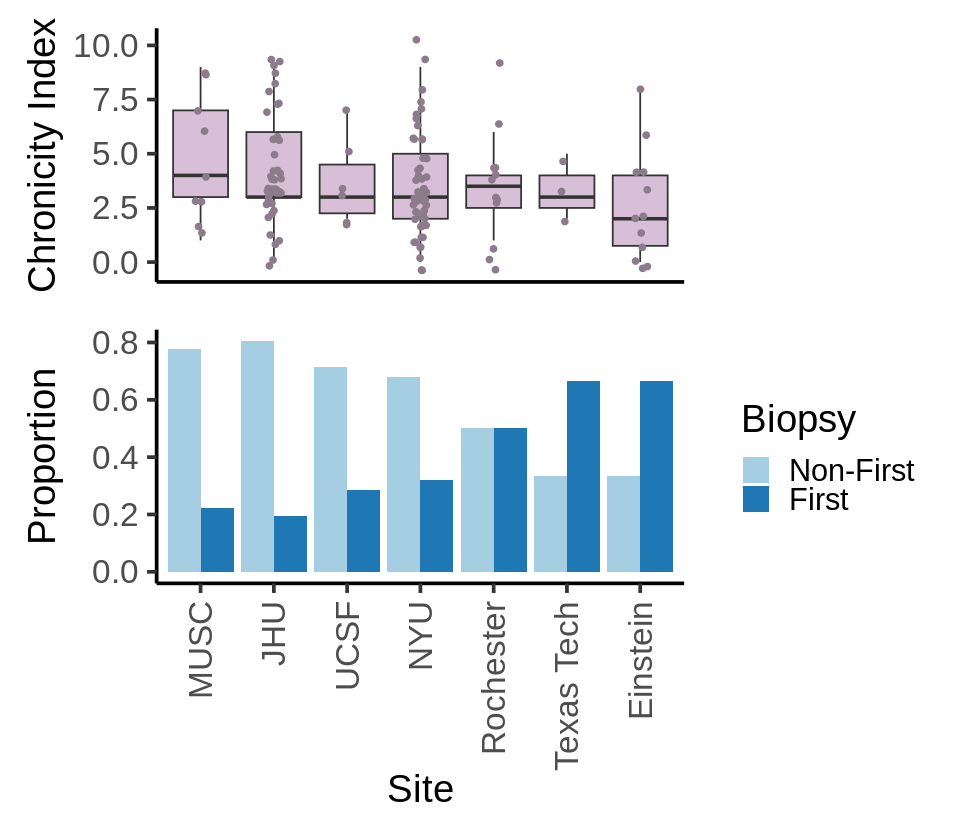

In [99]:
height = 7
width = 8
fig.size(height, width)
outplot = (p + theme(axis.text.x = element_blank(), axis.title.x = element_blank(),
                      axis.ticks.x = element_blank())) +barplot + plot_layout(ncol = 1)
outplot

ggsave(paste0(figdir, 'chronicity_site.png'), plot = outplot,  
       height = height, width = width, dpi = 500)
ggsave(paste0(figdir, 'chronicity_site.pdf'), plot = outplot,  
       height = height, width = width, dpi = 500, device = cairo_pdf)


In [9]:
test_df <- clinical_LN %>% 
               select(First_biop, Final_Chronicity) %>% 
               na.omit()

t.test(test_df %>% filter(First_biop == 0) %>% pull(Final_Chronicity),
       test_df %>% filter(First_biop == 1) %>% pull(Final_Chronicity))


	Welch Two Sample t-test

data:  test_df %>% filter(First_biop == 0) %>% pull(Final_Chronicity) and test_df %>% filter(First_biop == 1) %>% pull(Final_Chronicity)
t = 5.1689, df = 106.13, p-value = 1.114e-06
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 1.213412 2.723403
sample estimates:
mean of x mean of y 
 4.393939  2.425532 


In [10]:
test_df <- clinical_LN %>% 
               select(Responder_Status, Final_Chronicity) %>% 
               na.omit()

t.test(test_df %>% filter(Responder_Status == 1) %>% pull(Final_Chronicity),
       test_df %>% filter(Responder_Status == 2) %>% pull(Final_Chronicity))


	Welch Two Sample t-test

data:  test_df %>% filter(Responder_Status == 1) %>% pull(Final_Chronicity) and test_df %>% filter(Responder_Status == 2) %>% pull(Final_Chronicity)
t = 2.1259, df = 41.085, p-value = 0.03957
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.06539988 2.54558913
sample estimates:
mean of x mean of y 
 4.076923  2.771429 


In [11]:
test_df <- clinical_LN %>% 
               select(Pred_use, Final_Chronicity) %>% 
               na.omit()

t.test(test_df %>% filter(Pred_use == 0) %>% pull(Final_Chronicity),
       test_df %>% filter(Pred_use == 1) %>% pull(Final_Chronicity))


	Welch Two Sample t-test

data:  test_df %>% filter(Pred_use == 0) %>% pull(Final_Chronicity) and test_df %>% filter(Pred_use == 1) %>% pull(Final_Chronicity)
t = 1.7553, df = 56.525, p-value = 0.08463
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.128331  1.948075
sample estimates:
mean of x mean of y 
 4.414634  3.504762 


In [27]:
clinical <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/clinical_data_05042023.rds') %>% rename(Final_Site = Site)

In [96]:
library(ggpubr)


Attaching package: ‘ggpubr’


The following object is masked from ‘package:cowplot’:

    get_legend




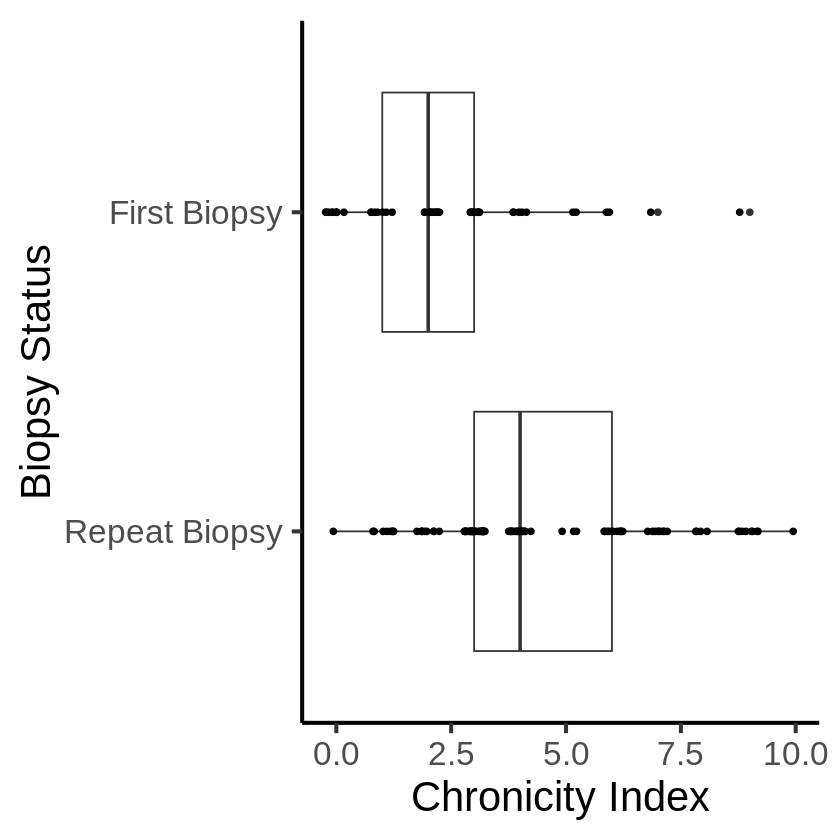

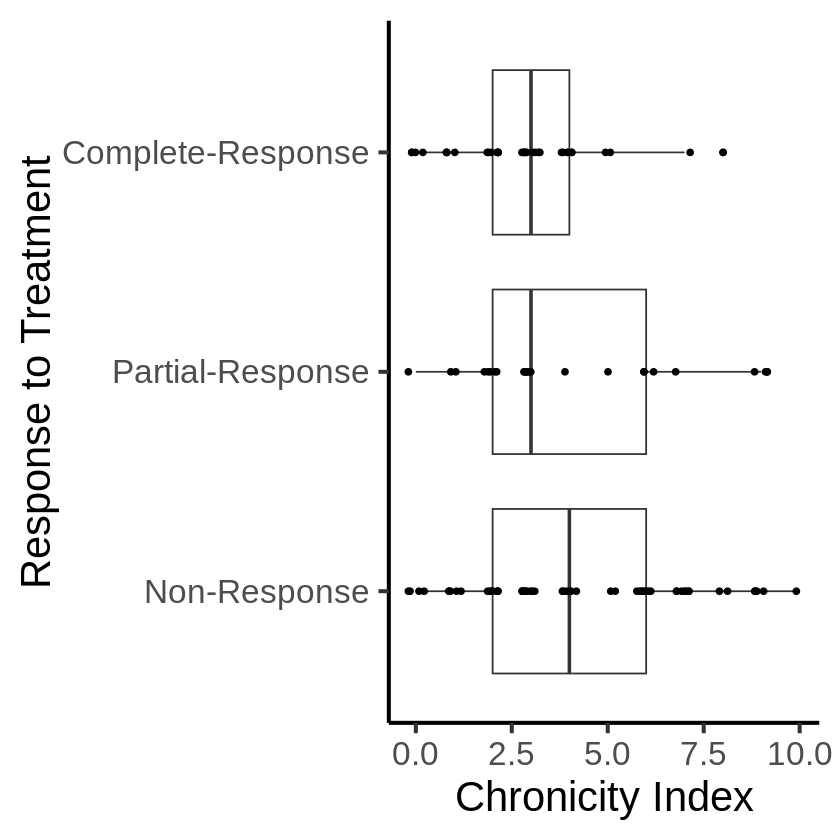

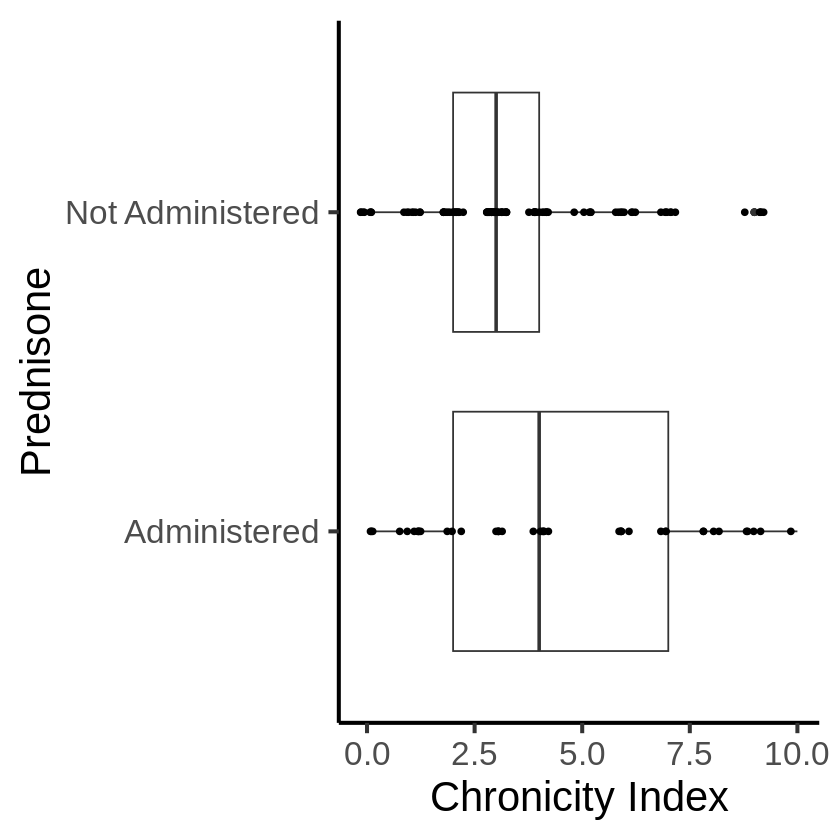

In [14]:
my_comparisons <- list(c("0", "1"))
p1 <- ggplot(clinical_LN %>% 
           select(First_biop, Final_Chronicity) %>% 
           na.omit(), aes(y = factor(First_biop), x = Final_Chronicity)) + 
    geom_boxplot() +
    geom_jitter(width = 0.25, height = 0) + 
    theme_classic(base_size = 25) + 
    scale_y_discrete(labels = c("Repeat Biopsy", "First Biopsy")) + 
    labs(y = "Biopsy Status", x = "Chronicity Index") 
    # ggpubr::stat_compare_means(label = "p.signif", method = "t.test", 
    #                            comparisons = my_comparisons, size = 6)

my_comparisons <- list(c("0", "1"),
                       c("1", "2"),
                       c("0", "2"))

p2 <- ggplot(clinical_LN %>% 
           select(Final_Chronicity, Responder_Status) %>% 
           na.omit(), aes(y = factor(Responder_Status), x = Final_Chronicity)) + 
    geom_boxplot() + 
    geom_jitter(width = 0.25, height = 0) + 
    theme_classic(base_size = 25) + 
    scale_y_discrete(labels = rev(c("Complete-Response", "Partial-Response", "Non-Response"))) + 
    labs(y = "Response to Treatment", x = "Chronicity Index") 
#     ggpubr::stat_compare_means(label = "p.signif", method = "t.test", 
#                                comparisons = my_comparisons, size = 6)

my_comparisons <- list(c("0", "1"))
p3 <- ggplot(clinical_LN %>% 
           select(Final_Chronicity, Pred_use) %>% 
           na.omit(), aes(y = factor(Pred_use), x = Final_Chronicity)) + 
    geom_boxplot() + 
    geom_jitter(width = 0.25, height = 0) + 
    theme_classic(base_size = 25) + 
    scale_y_discrete(labels = c("Administered", "Not Administered")) + 
    labs(y = "Prednisone", x = "Chronicity Index") 
    # ggpubr::stat_compare_means(label = "p.signif", method = "t.test", 
    #                            comparisons = my_comparisons, size = 6)

p4 <- cowplot::plot_grid(p1, p2, p3, nrow = 2, ncol = 2)
# cowplot::save_plot("/data/srlab/ssg34/SLE_kidney_v2/figures/extended_data/figure3/first_biop_clinical_plot.png",
#        p1,
#        base_height = 10,
#        base_width = 10)
# cowplot::save_plot("/data/srlab/ssg34/SLE_kidney_v2/figures/extended_data/figure3/treatment_response_clinical_plot.png",
#        p2,
#        base_height = 10,
#        base_width = 10)
# cowplot::save_plot("/data/srlab/ssg34/SLE_kidney_v2/figures/extended_data/figure3/pred_clinical_plot.png",
#        p3,
#        base_height = 10,
#        base_width = 10)
p1
p2
p3

In [ ]:
ylim(min(clinical_LN$Final_Chronicity %>% na.omit), max(clinical_LN$Final_Chronicity %>% na.omit) * 1.2)

In [147]:
my_comparisons <- list(c("0", "1"))
p1 <- ggplot(clinical_LN %>% 
           select(First_biop, Final_Chronicity) %>% 
           na.omit(), aes(x = factor(First_biop), y = Final_Chronicity)) + 
    geom_boxplot(fill = 'thistle', outlier.shape = NA) +
    geom_jitter(width = .1, height = .4, , col = 'thistle4')+
    theme_classic(base_size = 23) + 
    scale_x_discrete(labels = c("Repeat Biopsy", "First Biopsy")) + 
    labs(x = "Biopsy Status", y = "Chronicity Index") +
    theme(text = element_text(family = "Arial"),
          axis.text.x = element_text(angle = 90, hjust = 1,  vjust = 0.5),
          axis.text = element_text(size = labelfontsize))+
    ggpubr::stat_compare_means(label = "p.signif", method = "t.test", 
                               comparisons = my_comparisons, size = 6)+
    ylim(min(clinical_LN$Final_Chronicity %>% na.omit), max(clinical_LN$Final_Chronicity %>% na.omit) * 1.1)

my_comparisons <- list(c("0", "1"),
                       c("1", "2"),
                       c("0", "2"))

p2 <- ggplot(clinical_LN %>% 
           select(Final_Chronicity, Responder_Status) %>% 
           na.omit(), aes(x = factor(Responder_Status), y = Final_Chronicity)) + 
    geom_boxplot(fill = 'thistle', outlier.shape = NA) +
    geom_jitter(width = .1, height = .4, , col = 'thistle4')+
    theme_classic(base_size = 23) + 
    scale_x_discrete(labels = rev(c("Complete-Response", "Partial-Response", "Non-Response"))) + 
    labs(x = "Response to Treatment", y = "Chronicity Index")+
    theme(text = element_text(family = "Arial"),
          axis.text.x = element_text(angle = 90, hjust = 1,  vjust = 0.5),
          axis.text = element_text(size = labelfontsize),
        axis.title.y = element_blank(),   # Remove y-axis title
        axis.text.y = element_blank(),    # Remove y-axis labels
        axis.ticks.y = element_blank(), axis.line.y = element_blank())+
    ggpubr::stat_compare_means(label = "p.signif", method = "t.test", 
                               comparisons = my_comparisons, size = 6)+
    ylim(min(clinical_LN$Final_Chronicity %>% na.omit), max(clinical_LN$Final_Chronicity %>% na.omit) * 1.1)

my_comparisons <- list(c("0", "1"))
p3 <- ggplot(clinical_LN %>% 
           select(Final_Chronicity, Pred_use) %>% 
           na.omit(), aes(x = factor(Pred_use), y = Final_Chronicity)) + 
    geom_boxplot(fill = 'thistle', outlier.shape = NA) +
    geom_jitter(width = .1, height = .4, , col = 'thistle4')+
    theme_classic(base_size = 23) + 
    scale_x_discrete(labels = c("Administered", "Not Administered")) + 
    labs(x = "Prednisone", y = "Chronicity Index")+
    theme(text = element_text(family = "Arial"),
          axis.text.x = element_text(angle = 90, hjust = 1,  vjust = 0.5),
          axis.text = element_text(size = labelfontsize),
        axis.title.y = element_blank(),   # Remove y-axis title
        axis.text.y = element_blank(),    # Remove y-axis labels
        axis.ticks.y = element_blank(), axis.line.y = element_blank())+
    ggpubr::stat_compare_means(label = "p.signif", method = "t.test", 
                               comparisons = my_comparisons, size = 6)+
    ylim(min(clinical_LN$Final_Chronicity %>% na.omit), max(clinical_LN$Final_Chronicity %>% na.omit) * 1.1)


Warning message:
“Removed 5 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 6 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 6 rows containing missing values or values outside the scale range
(`geom_signif()`).”
Warning message:
“Removed 5 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 5 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 6 rows containing missing values or values outside the scale range
(`geom_signif()`).”
Warning message:
“Removed 7 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 7 rows containing missing values or values outside the scale range
(`geom_po

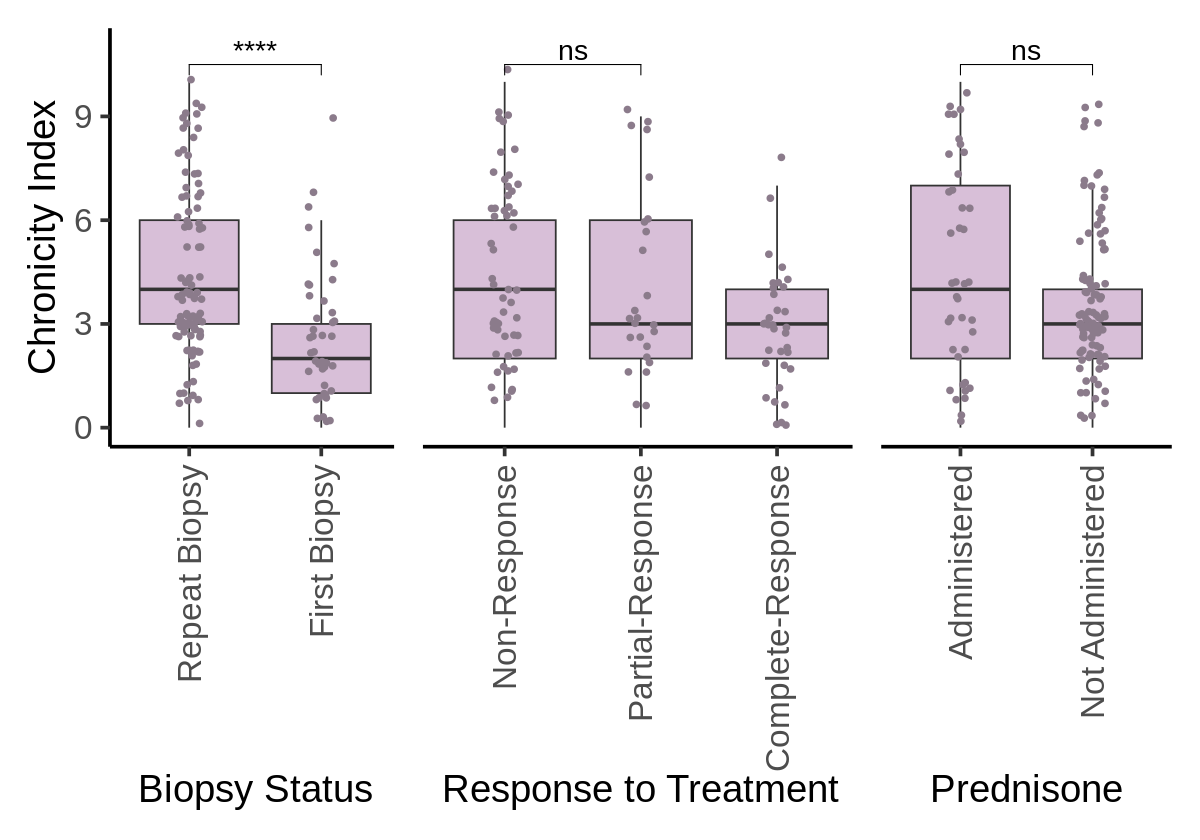

In [148]:
height = 7
width = 10
fig.size(height, width)
outplot = p1 +  plot_spacer() + p2 +  plot_spacer() + p3 + plot_layout(width = c(2, -.3, 3, -.3, 2))
outplot

ggsave(paste0(figdir, 'chronicity_clinicalboxplot.png'), plot = outplot,  
       height = height, width = width, dpi = 500)
ggsave(paste0(figdir, 'chronicity_clinicalboxplot.pdf'), plot = outplot,  
       height = height, width = width, dpi = 500, device = cairo_pdf)


Warning message:
“Removed 4 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 6 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 5 rows containing missing values or values outside the scale range
(`geom_point()`).”


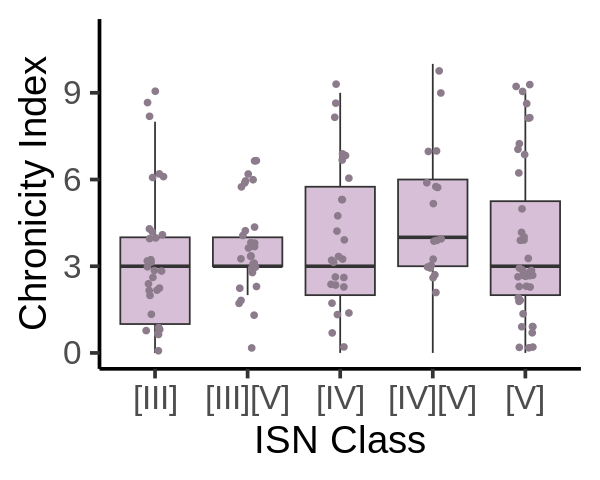

In [42]:
my_comparisons <- list(c("[III]", "[IV]"),
                       c("[III]", "[V]"),
                       c("[III]", "[III][V]"),
                       c("[IV]", "[IV][V]"))

isn_plot <- ggplot(clinical_LN %>% 
                   select(Final_ISN, Final_Chronicity) %>% 
                   na.omit(), aes(x = factor(Final_ISN), y = Final_Chronicity)) + 
    geom_boxplot(fill = 'thistle', outlier.shape = NA) +
    geom_jitter(width = .1, height = .4, , col = 'thistle4')+
    theme_classic(base_size = 23) + 
    # scale_x_discrete(labels = c("Repeat Biopsy", "First Biopsy")) + 
    labs(x = "ISN Class", y = "Chronicity Index") +
    theme(text = element_text(family = "Arial"),
          # axis.text.x = element_text(angle = 0, hjust = 1,  vjust = 0.5),
          axis.text = element_text(size = labelfontsize))+
    # ggpubr::stat_compare_means(label = "p.signif", method = "t.test", 
    #                            comparisons = my_comparisons, size = 6)+
    ylim(min(clinical_LN$Final_Chronicity %>% na.omit), max(clinical_LN$Final_Chronicity %>% na.omit) *1.1)


height = 4
width = 5
fig.size(height, width)
outplot = isn_plot
outplot

ggsave(paste0(figdir, 'chronicity_isnboxplot.png'), plot = outplot,  
       height = height, width = width, dpi = 500)
ggsave(paste0(figdir, 'chronicity_isnboxplot.pdf'), plot = outplot,  
       height = height, width = width, dpi = 500, device = cairo_pdf)


## output high/low chron and act samples

In [77]:
clinical %>% filter(Type == 'LN') %>% group_by(Final_ISN) %>% summarise(min_Chronicity = min(Final_Chronicity, na.rm = TRUE),
                                                  max_Chronicity = max(Final_Chronicity, na.rm = TRUE))

clinical %>% filter(Type == 'LN') %>% group_by(Final_ISN) %>% summarise(min_Chronicity = min(Final_Activity, na.rm = TRUE),
                                                  max_Chronicity = max(Final_Activity, na.rm = TRUE))


Final_ISN,min_Chronicity,max_Chronicity
<chr>,<int>,<int>
[III],0,9
[III][V],0,7
[IV],0,9
[IV][V],0,10
[V],0,9


Final_ISN,min_Chronicity,max_Chronicity
<chr>,<int>,<int>
[III],0,14
[III][V],0,9
[IV],0,16
[IV][V],1,18
[V],0,2


In [71]:
clinical %>%
  filter(Type == "LN") %>%
  group_by(Final_ISN) %>%
  slice_min(Final_Chronicity, with_ties = TRUE, na_rm = TRUE) %>%
  rename(min_Chronicity = Final_Chronicity) -> min_chronicity

clinical %>%
  filter(Type == "LN") %>%
  group_by(Final_ISN) %>%
  slice_max(Final_Chronicity, with_ties = TRUE, na_rm = TRUE) %>%
  rename(max_Chronicity = Final_Chronicity) -> max_chronicity

clinical %>%
  filter(Type == "LN") %>%
  group_by(Final_ISN) %>%
  slice_min(Final_Activity, with_ties = TRUE, na_rm = TRUE) %>%
  rename(min_Activity = Final_Activity) -> min_activity

clinical %>%
  filter(Type == "LN") %>%
  group_by(Final_ISN) %>%
  slice_max(Final_Activity, with_ties = TRUE, na_rm = TRUE) %>%
  rename(max_Activity = Final_Activity) -> max_activity

In [75]:
min_chronicity %>% select(AMP.ID, individual, min_Chronicity, Final_ISN)
max_chronicity %>% select(AMP.ID, individual, max_Chronicity, Final_ISN)

min_activity %>% select(AMP.ID, individual, min_Activity, Final_ISN)
max_activity %>% select(AMP.ID, individual, max_Activity, Final_ISN)

AMP.ID,individual,min_Chronicity,Final_ISN
<chr>,<chr>,<int>,<chr>
200-0143-V0,0143,0,[III]
200-1152-V0,1152,0,[III]
200-1659-V0,1659,0,[III]
200-0138-V0,0138,0,[III][V]
200-1240-V0,1240,0,[IV]
200-2850-V0,2850,0,[IV][V]
200-1158-V0,1158,0,[V]
200-1631-V0,1631,0,[V]
200-1635-V0,1635,0,[V]


AMP.ID,individual,max_Chronicity,Final_ISN
<chr>,<chr>,<int>,<chr>
200-0147-V0,0147,9,[III]
200-0849-V0,0849,9,[III]
200-0366-V0,0366,7,[III][V]
200-2811-V0,2811,7,[III][V]
200-0851-V0,0851,9,[IV]
200-2715-V0,2715,9,[IV]
200-3001-V0,3001,10,[IV][V]
200-1243-V0,1243,9,[V]
200-1258-V0,1258,9,[V]


AMP.ID,individual,min_Activity,Final_ISN
<chr>,<chr>,<int>,<chr>
200-0892-V0,0892,0,[III]
200-0138-V0,0138,0,[III][V]
200-2758-V0,2758,0,[IV]
200-1025-V0,1025,1,[IV][V]
200-1116-V0,1116,0,[V]
200-1148-V0,1148,0,[V]
200-1158-V0,1158,0,[V]
200-1218-V0,1218,0,[V]
200-1225-V0,1225,0,[V]


AMP.ID,individual,max_Activity,Final_ISN
<chr>,<chr>,<int>,<chr>
200-0856-V0,0856,14,[III]
200-1139-V0,1139,9,[III][V]
200-0142-V0,0142,16,[IV]
200-2822-V0,2822,18,[IV][V]
200-2836-V0,2836,2,[V]


## CHRONICITY ISG

In [23]:
clinical <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/clinical_data_05042023.rds') %>% rename(Final_Site = Site)

In [1]:
downsampled_pb <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/downsampled_norm_pseudobulk_10122024.rds')

In [13]:
arazi_isg_genes <- c(
  "BATF2", "IFI44L", "XAF1", "OASL", "IFI44",
  "OAS2", "TRIM6", "HES4", "OTOF", "IFI44L",
  "DDX60", "IFITM3", "IFIT3", "CXCL10", "SERPING1",
  "SPATS2L", "RSAD2", "LY6E", "OAS1", "IFIT1",
  "IFIT3", "OAS3", "OAS1", "OASL", "CMPK2",
  "HERC5", "OAS1", "MX1", "HERC6",
  "IFITM1", "TRIM5", "EIF2AK2", "AIM2", "MT1A",
  "MOV10", "CCL8", "HELZ2", "ZBP1", "WARS",
  "LAP3", "TNFSF10", "GBP1", "STAT1", "FBXO6",
  "PARP10", "OAS2", "TRIM22", "PARP10", "GBP3",
  "ZNF684", "CARD17", "GALM", "DHX58", "CEACAM1",
  "UBE2L6", "CEACAM1", "APOL6", "SOCS1", "DDX58",
  "UBE2L6", "TNFAIP6", "IDO1", "GBP6", "STAT2",
  "TIMM10", "STAT1", "PARP12", "PARP9", "GBP1",
  "GBP4", "IFIH1", "IRF7", "PARP14", "IFIT2",
  "IFI35", "STAT1", "IFIT5", "ZNFX1", "PHF11",
  "ACTA2", "SP140", "ABCA1", "TCN2", "ZC3HAV1",
  "HSH2D", "GBP2", "TRIM5", "RHBDF2", "TMEM140",
  "ADAR", "BTN3A1", "LGALS9", "NBN", "TYMP",
  "SRBD1", "NCOA7", "UNC93B1", "SP100", "DHRS9",
  "TRANK1", "TRIM5", "NT5C3A", "ASPRV1", "IRF9",
  "REC8", "RNF213", "ISG20", "DYNLT1", "TRIM56",
  "SP140", "TRIM38", "PSMB9", "CPT1B", "BST2",
  "NMI", "RBCK1", "TRAFD1", "TRIM21", "CARD16",
  "CHMP5", "TAP2", "SP110", "GADD45B", "TAP1"
)

In [14]:
sds <- data.frame()
for (gene in arazi_isg_genes) {
    sds <- sds %>% rbind(data.frame("Std" = sd(downsampled_pb[, gene]),
                                     "Gene" = gene))
}

In [21]:
genes <- sds %>% arrange(desc(Std)) %>% slice(1:20) %>% pull(Gene)

In [30]:
saveRDS(genes, '/data/srlab/ssg34/SLE_kidney_v2/data/pseudobulk_de/isg_genes.rds')

In [26]:
chron_isg_pb <- downsampled_pb %>% 
                    mutate(individual = str_remove(sample, "AMPSLEkid_cells_")) %>% 
                    select(c(genes, individual)) %>% 
                    left_join(clinical %>% select(individual, Final_Chronicity)) 
for (i in genes) {
    chron_isg_pb[, i] <- as.numeric(chron_isg_pb[, i])
}
chron_isg_pb$isg_score <- rowMeans(chron_isg_pb[, genes])

Joining, by = "individual"


In [29]:
cor.test(chron_isg_pb$Final_Chronicity, chron_isg_pb$isg_score)


	Pearson's product-moment correlation

data:  chron_isg_pb$Final_Chronicity and chron_isg_pb$isg_score
t = -0.99336, df = 140, p-value = 0.3222
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.24501083  0.08220001
sample estimates:
        cor 
-0.08366008 


In [28]:
ggplot(chron_isg_pb, aes(x = isg_score, y = Final_Chronicity)) +
    geom_point()

Warning message:
“Removed 44 rows containing missing values (`geom_point()`).”


ERROR: Error in value[[3L]](cond): could not open file '/tmp/538383.tmpdir/RtmprrpnJA/file1f73f753208aa.png'


plot without title

# Activity Correlations

In [2]:
clinical <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/clinical_data_05042023.rds') %>% rename(Final_Site = Site)

In [3]:
first_biop_pred <- readRDS("/data/srlab2/qxiao/AMP-SLE/data/clinical/df_pred_biop.rds") %>% 
                        mutate(individual = str_split(Subject_ID, '-')) %>% 
                        rowwise() %>% 
                        mutate(individual = unlist(individual)[2])

In [4]:
clinical_LN <- clinical %>% filter(Type == "LN")
clinical_LN <- clinical_LN %>% 
                select(Final_Chronicity, 
                       Final_Activity,
                       Final_ISN,
                       Age,
                       Sex,
                       Final_Site,
                       Race,
                       individual, 
                       Responder.Status) %>% 
                left_join(first_biop_pred %>% select(Pred_use, First_biop, individual)) %>% 
                mutate(Responder.Status = ifelse(Responder.Status %in% c("NR", "PR", "CR"), Responder.Status, NA)) %>% 
                left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                     Responder_Status = c(0, 1, 2))) %>% 
                mutate(Sex = ifelse(Sex == "Female", 0, 1))
clinical_LN <- fastDummies::dummy_cols(clinical_LN, 'Race')
clinical_LN <- fastDummies::dummy_cols(clinical_LN, 'Final_Site')
clinical_LN <- fastDummies::dummy_cols(clinical_LN, 'Final_ISN')
clinical_LN <- clinical_LN %>% select(-Responder.Status)

Joining with `by = join_by(individual)`
Joining with `by = join_by(Responder.Status)`


In [5]:
num_columns <- c('Final_Chronicity', 'Pred_use', 'First_biop',
                 'Age', 'Sex', 'Responder_Status')
cor_df <- data.frame()
for (i in num_columns) {
    df <- clinical_LN[, c("Final_Activity", i)] %>% na.omit()
    est <- cor.test(unlist(df[, "Final_Activity"]), unlist(df[, i]))$estimate ^ 2
    pval <- cor.test(unlist(df[, "Final_Activity"]), unlist(df[, i]))$p.value
    cor_df <- rbind(cor_df, 
                    data.frame("Final_Activity", i, est, pval))
}

In [6]:
model_df <- clinical_LN[, c(2, grep('Race', colnames(clinical_LN)))] %>% na.omit()
colnames(model_df) <- c('Final_Activity', 'Race', 'RaceA', 'RaceAB',
                        'RaceB', 'RaceBAI','RaceBW', 'RaceU', 'RaceW')
summary(lm(Final_Activity ~ RaceAB + RaceB + RaceBAI + RaceBW + RaceU + RaceW, data = model_df))
cor_df <- cor_df %>% rbind(c("Final_Activity", 'Race', 0.04397, 0.05568))


Call:
lm(formula = Final_Activity ~ RaceAB + RaceB + RaceBAI + RaceBW + 
    RaceU + RaceW, data = model_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.3182 -3.2664 -0.6812  2.2114 14.3188 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   5.1111     0.9484   5.389 2.95e-07 ***
RaceAB        1.8889     4.1341   0.457   0.6485    
RaceB        -1.4300     1.0650  -1.343   0.1816    
RaceBAI      -5.1111     4.1341  -1.236   0.2184    
RaceBW        8.8889     4.1341   2.150   0.0333 *  
RaceU        -1.3611     1.4996  -0.908   0.3656    
RaceW         0.2071     1.1258   0.184   0.8543    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.024 on 139 degrees of freedom
Multiple R-squared:  0.08353,	Adjusted R-squared:  0.04397 
F-statistic: 2.111 on 6 and 139 DF,  p-value: 0.05568


In [7]:
model_df <- clinical_LN[, c(2, grep('ISN', colnames(clinical_LN)))] %>% na.omit()
colnames(model_df) <- c('Final_Activity', 'FinalISN', 'FinalISNIII', 'FinalISNIIIV',
                        'FinalISNIV', 'FinalISNIVV', 'FinalISNV')
summary(lm(Final_Activity ~ FinalISNIIIV + FinalISNIV + FinalISNIVV + FinalISNV, data = model_df))
cor_df <- cor_df %>% rbind(c("Final_Activity", 'ISN', 0.5069, 2.2e-16))


Call:
lm(formula = Final_Activity ~ FinalISNIIIV + FinalISNIV + FinalISNIVV + 
    FinalISNV, data = model_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.1538 -1.1579 -0.1559  0.9063  9.9062 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)    4.0938     0.5108   8.014 3.81e-13 ***
FinalISNIIIV   0.4580     0.7409   0.618    0.537    
FinalISNIV     4.0601     0.7630   5.321 3.96e-07 ***
FinalISNIVV    4.0641     0.8369   4.856 3.14e-06 ***
FinalISNV     -3.6937     0.6854  -5.390 2.89e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.89 on 141 degrees of freedom
Multiple R-squared:  0.5205,	Adjusted R-squared:  0.5069 
F-statistic: 38.27 on 4 and 141 DF,  p-value: < 2.2e-16


In [8]:
model_df <- clinical_LN[, c(2, grep('Site', colnames(clinical_LN)))] %>% na.omit()
colnames(model_df) <- str_remove_all(colnames(model_df), "_")
colnames(model_df) <- str_remove_all(colnames(model_df), "-")
colnames(model_df) <- str_remove_all(colnames(model_df), " ")
summary(lm(FinalActivity ~ FinalSiteJHU + FinalSiteNYU, data = model_df))
cor_df <- cor_df %>% rbind(c("Final_Activity", 'Site', 0.0547, 0.06654))


Call:
lm(formula = FinalActivity ~ FinalSiteJHU + FinalSiteNYU, data = model_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.9434 -3.0435 -0.9434  2.0566 12.0566 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)    4.0638     0.5772   7.040 7.41e-11 ***
FinalSiteJHU  -1.0204     0.8208  -1.243   0.2158    
FinalSiteNYU   1.8796     0.7929   2.370   0.0191 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.957 on 143 degrees of freedom
Multiple R-squared:  0.08801,	Adjusted R-squared:  0.07525 
F-statistic:   6.9 on 2 and 143 DF,  p-value: 0.001378


In [8]:
colnames(cor_df) <- c("Variable1", "Variable2", "correlation", "pvalue")
cor_df <- cor_df %>% mutate(pvalue = as.numeric(pvalue))
cor_df$bfpval <- p.adjust(cor_df$pvalue, method = "bonferroni")

Warning message in geom_text(aes(label = label), size = 15, face = "bold"):
“Ignoring unknown parameters: `face`”
Warning message:
“Removed 6 rows containing missing values or values outside the scale range
(`geom_text()`).”


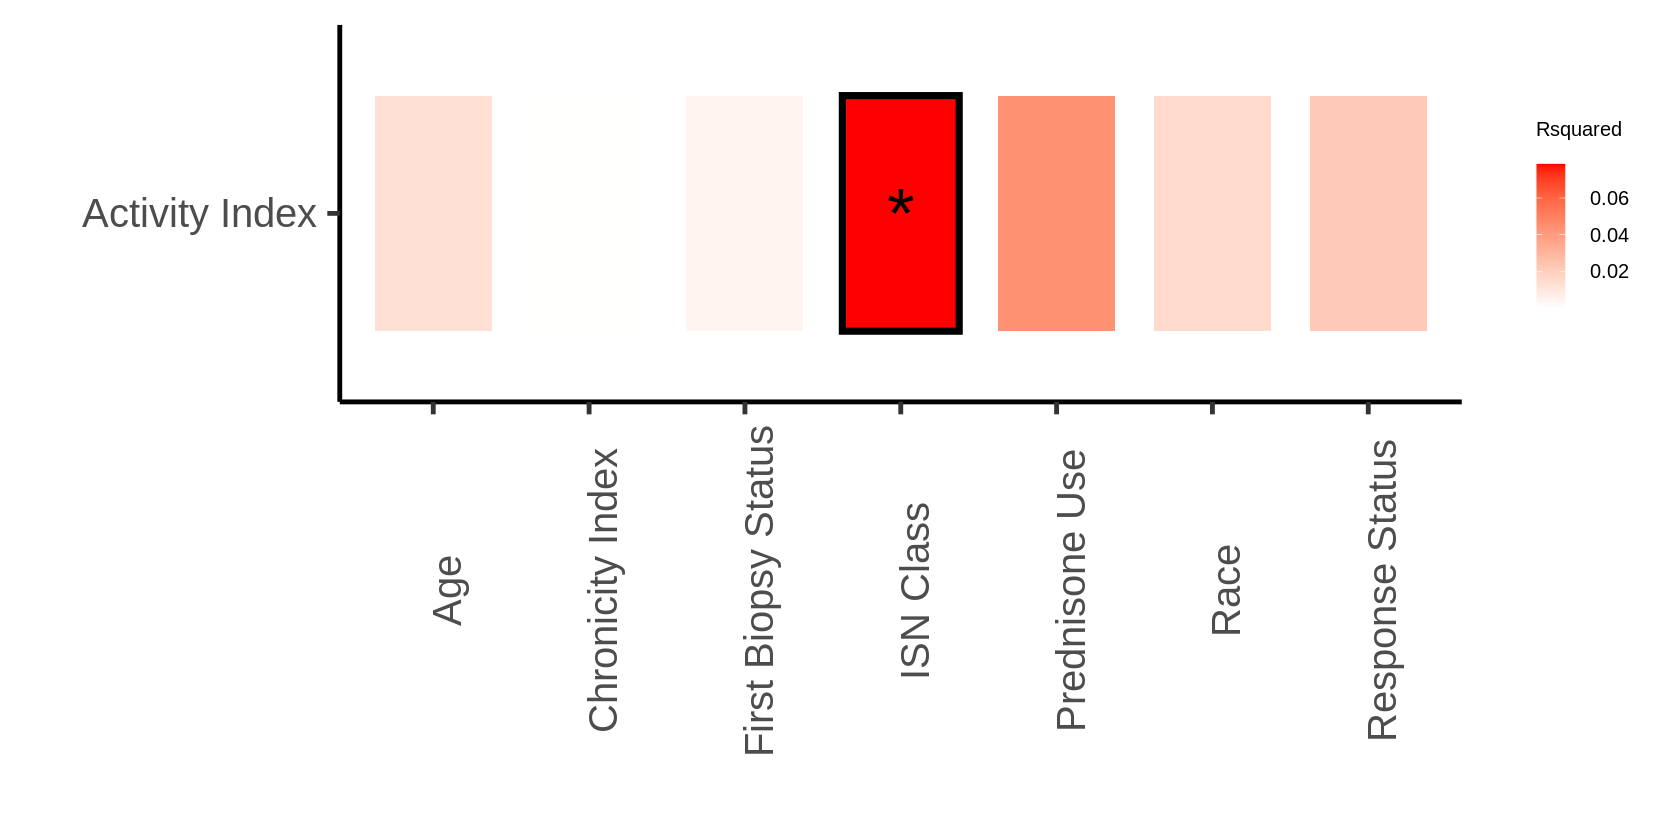

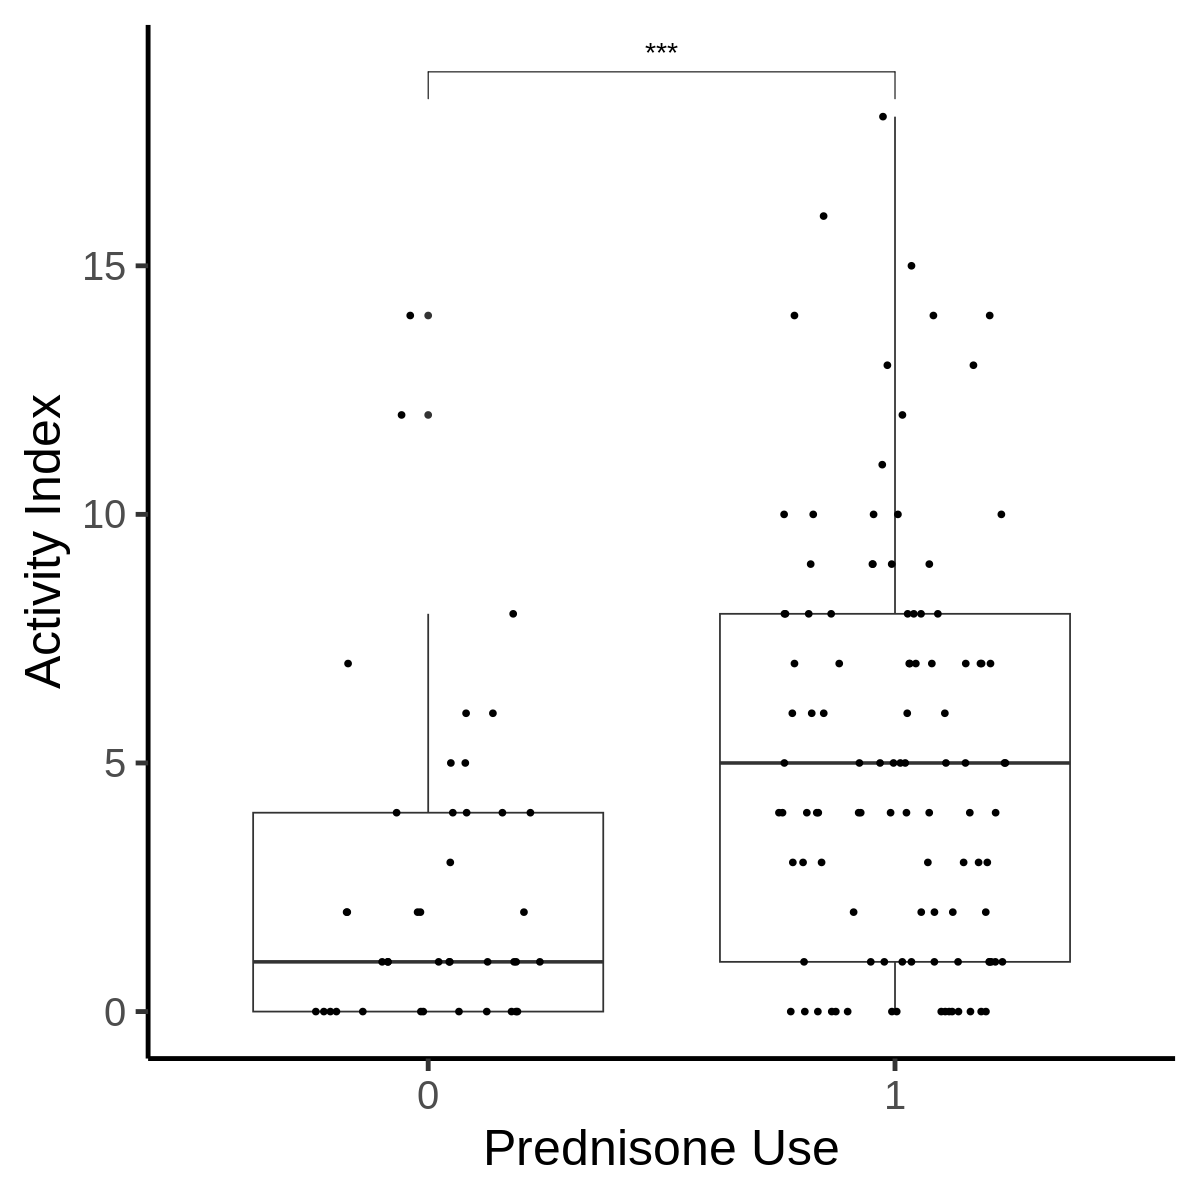

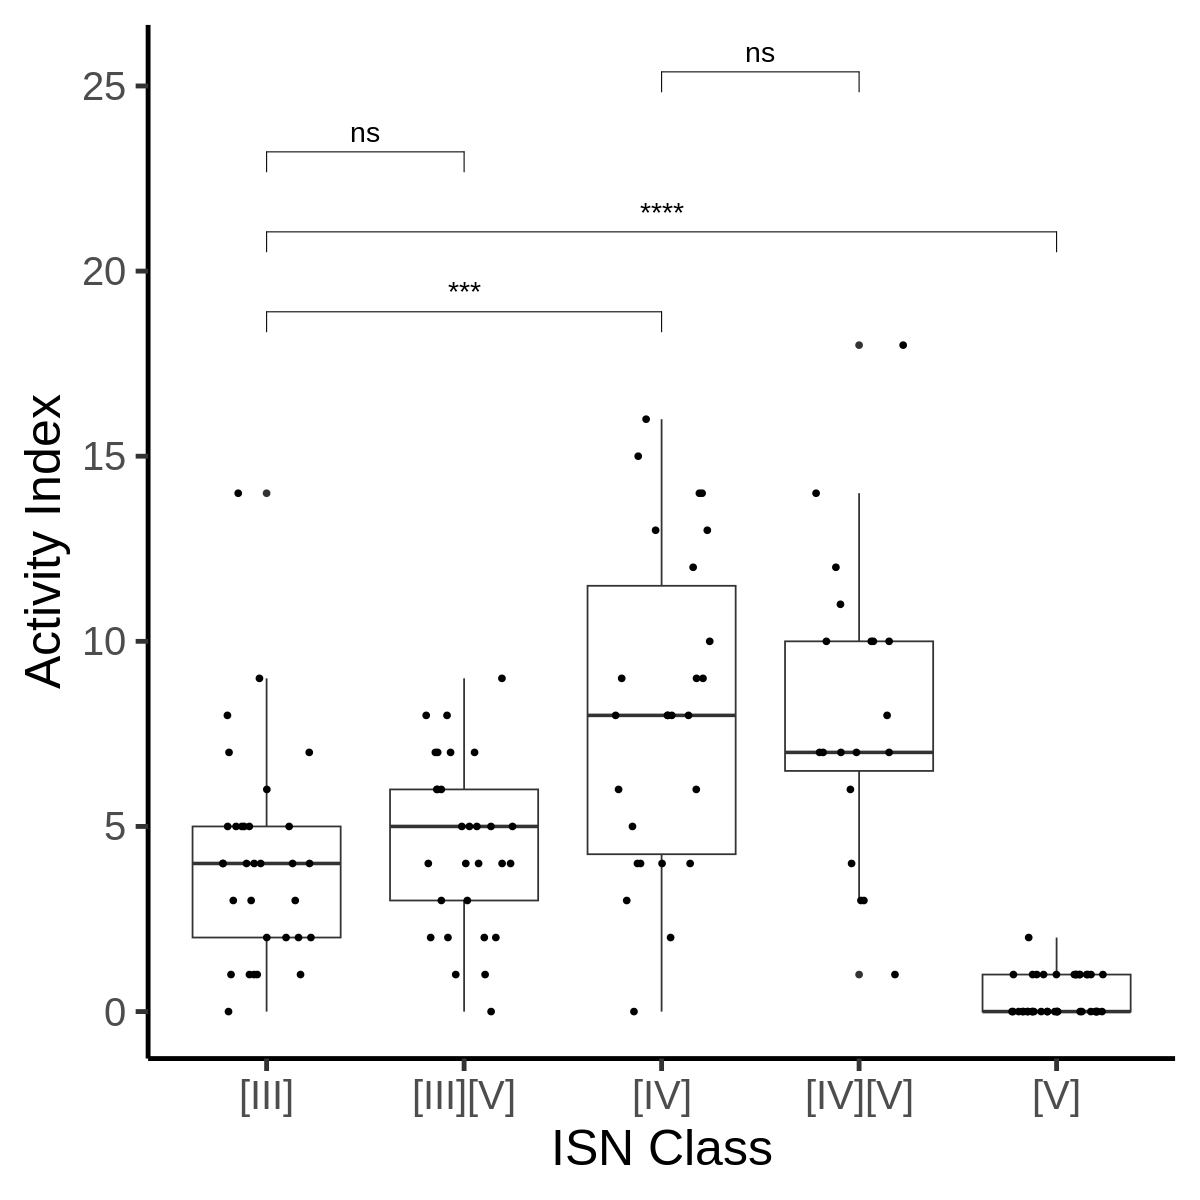

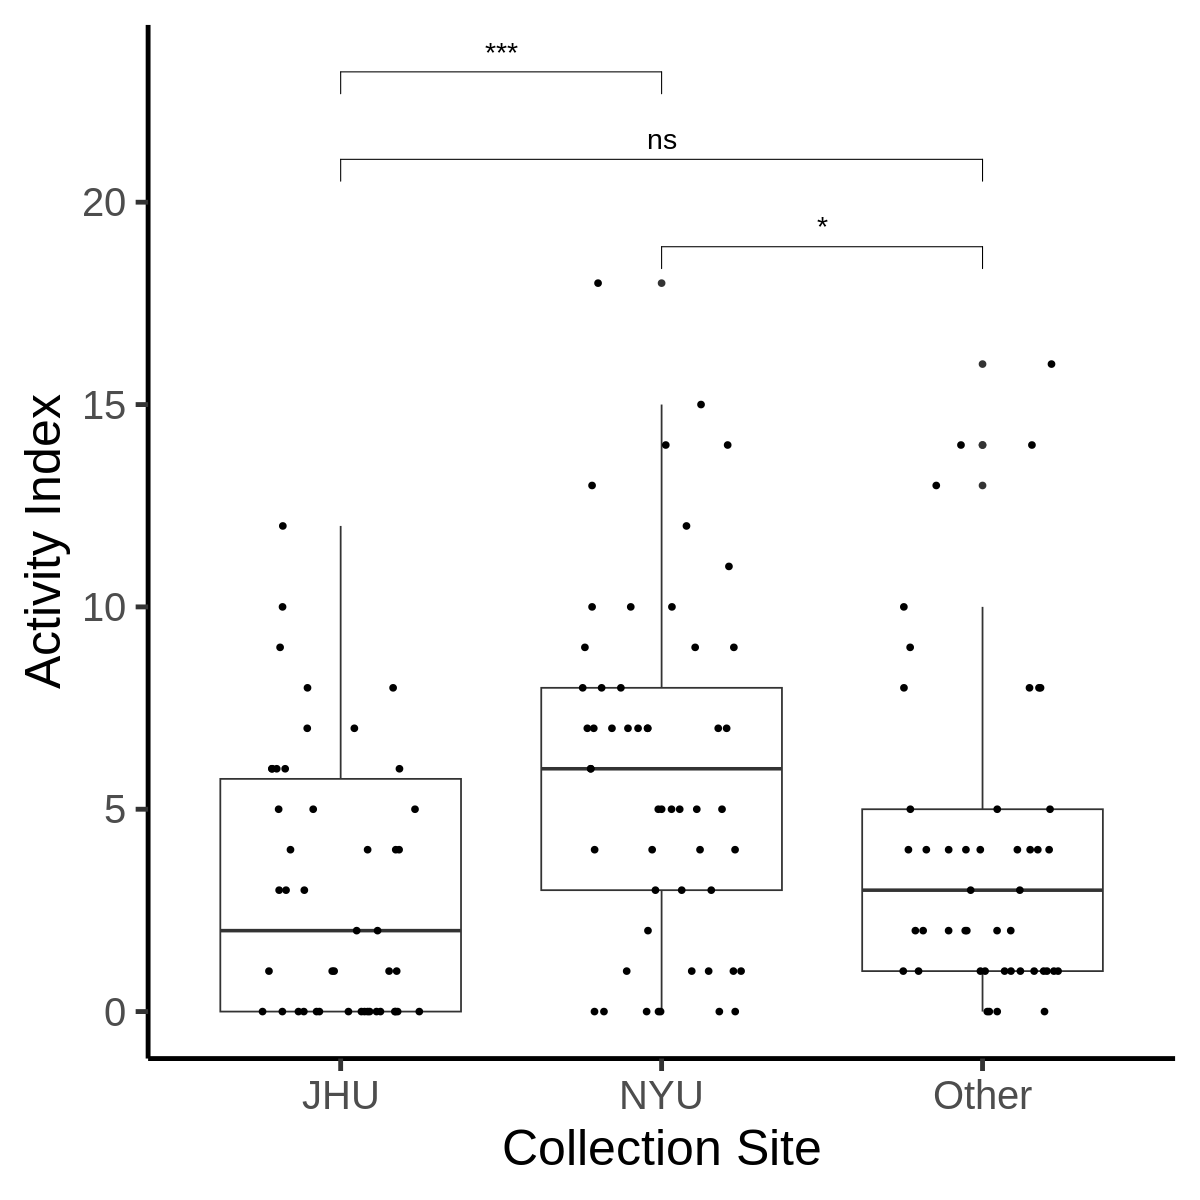

In [9]:
p <- ggplot(data = cor_df %>% mutate(label = ifelse(bfpval < 0.05, '*', NA)),
                       aes(y = Variable1, x = Variable2, fill = as.numeric(correlation))) + 
            geom_tile(width = 0.75, height = 0.75) +
            geom_tile(data = cor_df %>% filter(pvalue < 0.05),
                      color = "black", 
                      width = 0.75, 
                      height = 0.75,
                      linewidth = 2) +
            geom_text(aes(label = label), size = 15, face = "bold") +  
            scale_fill_gradient2(low = "white",
                                 high = "red") + 
            theme_classic(base_size = 30) + 
            labs(x = "", y = "", fill = "Rsquared") + 
            theme(legend.title = element_text(size = 12),
                  legend.text = element_text(size = 12),
                  axis.text.x = element_text(angle = 90),
                  text=element_text(family="Arial")) +
            scale_y_discrete(labels = c("Activity Index")) +
            scale_x_discrete(labels = c("Age", 
                                        'Chronicity Index',
                                        'First Biopsy Status', 
                                        'ISN Class',
                                        'Prednisone Use', 
                                        'Race',
                                        'Response Status', 
                                        'Sex', 
                                        'Site'))
fig.size(7, 14)
print(p)
# cowplot::save_plot("/data/srlab/ssg34/SLE_kidney_v2/figures/extended_data/figure4/correlation-plot.png",
#        p,
#        base_height = 7,
#        base_width = 14)
my_comparisons <- list(c("0", "1"))

pred_plot <- ggplot(clinical_LN %>% 
           select(Pred_use, Final_Activity) %>% 
           na.omit(), aes(x = factor(Pred_use), y = Final_Activity)) + 
    geom_boxplot() +
    geom_jitter(width = 0.25, height = 0) + 
    theme_classic(base_size = 30) + 
    labs(x = "Prednisone Use", y = "Activity Index") + 
    ggpubr::stat_compare_means(label = "p.signif", method = "t.test", 
                               comparisons = my_comparisons, size = 6) +
    theme(text=element_text(family="Arial"))
fig.size(10, 10)
print(pred_plot)
# cowplot::save_plot("/data/srlab/ssg34/SLE_kidney_v2/figures/extended_data/figure4/prednisone_clinical_plot.png",
#        pred_plot,
#        base_height = 10,
#        base_width = 10)

fig.size(8, 8)
my_comparisons <- list(c("[III]", "[IV]"),
                       c("[III]", "[V]"),
                       c("[III]", "[III][V]"),
                       c("[IV]", "[IV][V]"))
isn_plot <- ggplot(clinical %>% 
                   select(Final_ISN, Final_Activity) %>% 
                   na.omit(), aes(x = factor(Final_ISN), y = Final_Activity)) + 
            geom_boxplot() +
            geom_jitter(width = 0.25, height = 0) + 
            theme_classic(base_size = 30) + 
            labs(x = "ISN Class", y = "Activity Index") + 
            ggpubr::stat_compare_means(label = "p.signif", method = "t.test", 
                                       comparisons = my_comparisons, size = 6) + 
            theme(text=element_text(family="Arial"))
fig.size(10, 10)
print(isn_plot)

# cowplot::save_plot("/data/srlab/ssg34/SLE_kidney_v2/figures/extended_data/figure4/isn_clinical_plot.png",
#        isn_plot,
#        base_height = 10,
#        base_width = 10)

my_comparisons <- list(c("Other", "NYU"),
                       c("Other", "JHU"),
                       c("JHU", "NYU"))
site_plot <- ggplot(clinical %>% 
                   select(Final_Site, Final_Activity) %>% 
                   mutate(Final_Site = ifelse(Final_Site %in% c("JHU", "NYU"), Final_Site, "Other")) %>% 
                   na.omit(), aes(x = factor(Final_Site), y = Final_Activity)) + 
            geom_boxplot() +
            geom_jitter(width = 0.25, height = 0) + 
            theme_classic(base_size = 30) + 
            labs(x = "Collection Site", y = "Activity Index") + 
            ggpubr::stat_compare_means(label = "p.signif", method = "t.test", 
                                       comparisons = my_comparisons, size = 6) + 
            theme(text=element_text(family="Arial"))
fig.size(10, 10)
print(site_plot)
# cowplot::save_plot("/data/srlab/ssg34/SLE_kidney_v2/figures/extended_data/figure4/site_clinical_plot.png",
#        site_plot,
#        base_height = 10,
#        base_width = 10)

options(warn=0)

Warning message:
“Removed 13 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 16 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 11 rows containing missing values or values outside the scale range
(`geom_point()`).”


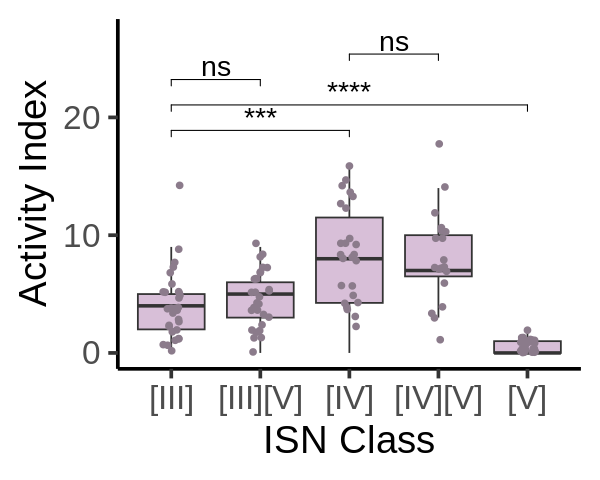

In [27]:
my_comparisons <- list(c("[III]", "[IV]"),
                       c("[III]", "[V]"),
                       c("[III]", "[III][V]"),
                       c("[IV]", "[IV][V]"))

isn_plot <- ggplot(clinical_LN %>% 
                   select(Final_ISN, Final_Activity) %>% 
                   na.omit(), aes(x = factor(Final_ISN), y = Final_Activity)) + 
    geom_boxplot(fill = 'thistle', outlier.shape = NA) +
    geom_jitter(width = .1, height = .4, , col = 'thistle4')+
    theme_classic(base_size = 23) + 
    # scale_x_discrete(labels = c("Repeat Biopsy", "First Biopsy")) + 
    labs(x = "ISN Class", y = "Activity Index") +
    theme(text = element_text(family = "Arial"),
          # axis.text.x = element_text(angle = 0, hjust = 1,  vjust = 0.5),
          axis.text = element_text(size = labelfontsize))+
    ggpubr::stat_compare_means(label = "p.signif", method = "t.test", 
                               comparisons = my_comparisons, size = 6)+
    ylim(min(clinical_LN$Final_Activity %>% na.omit), max(clinical_LN$Final_Activity %>% na.omit) *1.5)


height = 4
width = 5
fig.size(height, width)
outplot = isn_plot
outplot

ggsave(paste0(figdir, 'activity_isnboxplot.png'), plot = outplot,  
       height = height, width = width, dpi = 500)
ggsave(paste0(figdir, 'activity_isnboxplot.pdf'), plot = outplot,  
       height = height, width = width, dpi = 500, device = cairo_pdf)


In [5]:
clinical_LN <- clinical_LN %>% left_join(clinical_LN %>% 
                                            select(Final_Site) %>% 
                                            table() %>% data.frame() %>% 
                                            rename('Site' = '.') %>% 
                                            mutate(Final_Site = as.character(Site), 
                                                   Renamed_Site = ifelse(Freq < 20, "Other", Final_Site)))

Joining, by = "Final_Site"


In [11]:
qcd_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/qcd/Myeloid_clusterQCd_meta_harmonizedPCUMAPCellStateClusters_10042022.rds')
freq_table <- qcd_meta %>% 
                group_by(new_cluster_number) %>% 
                select(sample, new_cluster_number) %>% 
                table() %>% data.frame() %>% 
                pivot_wider(values_from = "Freq", names_from = 'new_cluster_number')
prop_table <- data.frame(sample = freq_table$sample, 
                         M0_Freq =  freq_table[, "0"] / rowSums(freq_table[, -1]),
                         M5_Freq = freq_table[, "5"] / rowSums(freq_table[, -1]),
                         M11_Freq = freq_table[, "11"] / rowSums(freq_table[, -1]))
prop_table <- prop_table[grep("cells", prop_table$sample), ]
prop_table <- prop_table %>% 
                mutate(individual = str_split(sample, '_')) %>% 
                rowwise() %>% 
                mutate(individual = unlist(individual)[3])
prop_table <- prop_table %>% 
                rename(M0_Freq = X0,
                       M5_Freq = X5,
                       M11_Freq = X11)

In [37]:
colnames(clinical_LN) <- str_remove_all(str_remove_all(colnames(clinical_LN), "\\["), "\\]")
activity_df <- prop_table %>% 
            left_join(clinical_LN %>% 
                        select(individual, Final_ISN, Final_ISN_IV, Final_ISN_IVV, 
                               Final_ISN_V, Pred_use, 
                               Final_Activity, Final_Site_JHU, Final_Site_NYU,
                               Race_A, Race_B, Race_W, First_biop), by = 'individual') %>% 
            na.omit()

activity_df$M11_Freq_resid_activity <- lm(M11_Freq ~ Pred_use + 
                                          Final_ISN_IV + Final_ISN_IVV + Final_ISN_V +
                                          Final_Site_JHU + Final_Site_NYU,
                                            activity_df)$resid

activity_df$M5_Freq_resid_activity <- lm(M5_Freq ~ Pred_use + 
                                          Final_ISN_IV + Final_ISN_IVV + Final_ISN_V +
                                          Final_Site_JHU + Final_Site_NYU,
                                            activity_df)$resid

activity_df$M11_Freq_resid_isn <- lm(M11_Freq ~ Pred_use + 
                                          Final_Activity + Pred_use + First_biop +
                                          Final_Site_JHU + Final_Site_NYU + 
                                          Race_A + Race_B + Race_W,
                                            activity_df)$resid

activity_df$M5_Freq_resid_isn <- lm(M5_Freq ~ Pred_use + 
                                          Final_Activity + Pred_use + First_biop +
                                          Final_Site_JHU + Final_Site_NYU + 
                                          Race_A + Race_B + Race_W,
                                            activity_df)$resid

In [17]:
cor.test(activity_df$M5_Freq, activity_df$Final_Activity)
cor.test(activity_df$M5_Freq_resid_activity, activity_df$Final_Activity)


	Pearson's product-moment correlation

data:  activity_df$M5_Freq and activity_df$Final_Activity
t = 6.0084, df = 139, p-value = 1.558e-08
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.3121807 0.5761271
sample estimates:
    cor 
0.45406 



	Pearson's product-moment correlation

data:  activity_df$M5_Freq_resid_activity and activity_df$Final_Activity
t = 2.3421, df = 139, p-value = 0.02059
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.03051893 0.34892116
sample estimates:
     cor 
0.194848 


In [18]:
cor.test(activity_df$M11_Freq, activity_df$Final_Activity)
cor.test(activity_df$M11_Freq_resid_activity, activity_df$Final_Activity)


	Pearson's product-moment correlation

data:  activity_df$M11_Freq and activity_df$Final_Activity
t = 5.2182, df = 139, p-value = 6.43e-07
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.2565889 0.5342971
sample estimates:
      cor 
0.4047334 



	Pearson's product-moment correlation

data:  activity_df$M11_Freq_resid_activity and activity_df$Final_Activity
t = 1.479, df = 139, p-value = 0.1414
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.04170191  0.28393809
sample estimates:
      cor 
0.1244683 


In [19]:
options(warn = -1)
fig.size(8, 8)
cluster_plot <- ggplot(activity_df, 
           aes(x = M5_Freq, y = Final_Activity)) + 
    geom_point(shape = 1, size = 4) + 
    geom_smooth(method = "lm", se = FALSE, color = "black") + 
    theme_classic(base_size = 25) + 
    labs(x = "Cluster 5 Proportion", 
         y = "Activity Index",
         title = "R = 0.454, p = 1.59e-08") + 
    theme(plot.title = element_text(hjust = 0.5),
          text=element_text(family="Arial"))

cowplot::save_plot("/data/srlab/ssg34/SLE_kidney_v2/figures/main_figures/figure5/activity_cluster_plot.png",
       cluster_plot,
       base_height = 10,
       base_width = 10)


cluster_plot_resid <- ggplot(activity_df, 
                       aes(x = M5_Freq_resid_activity, y =  Final_Activity)) + 
                geom_point(shape = 1, size = 4) + 
                geom_smooth(method = "lm", se = FALSE, color = "black") + 
                theme_classic(base_size = 25) + 
                labs(x = "Residual Cluster 5 Proportion", 
                     y = "Activity Index",
                     title = "R = 0.195, p = 0.02") + 
                theme(plot.title = element_text(hjust = 0.5),
                      text=element_text(family="Arial"))

cowplot::save_plot("/data/srlab/ssg34/SLE_kidney_v2/figures/main_figures/figure5/activity_cluster_resid_plot.png",
       cluster_plot_resid,
       base_height = 10,
       base_width = 10)
options(warn=0)

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


In [89]:
fig.size(8, 8)
my_comparisons <- list(c("[IV][V]", "[V]"),
                       c("[IV]", "[V]"))
p1 <- ggplot(activity_df, aes(x = factor(Final_ISN), y = M5_Freq)) + 
    geom_boxplot() +
    geom_jitter(width = 0.25, height = 0) + 
    theme_classic(base_size = 25) + 
    labs(x = "ISN Class", y = "Cluster 5 Frequency") + 
    ggpubr::stat_compare_means(label = "p.signif", method = "t.test", 
                               comparisons = my_comparisons, size = 6) + 
                theme(plot.title = element_text(hjust = 0.5),
                      text=element_text(family="Arial"))

cowplot::save_plot("/data/srlab/ssg34/SLE_kidney_v2/figures/main_figures/figure5/isn_cluster5_plot.png",
       p1,
       base_height = 10,
       base_width = 10)

p2 <- ggplot(activity_df, aes(x = factor(Final_ISN), y = resid_M5_isn)) + 
    geom_boxplot() +
    geom_jitter(width = 0.25, height = 0) + 
    theme_classic(base_size = 25) + 
    labs(x = "ISN Class", y = "Residual Cluster 5 Frequency") + 
    ggpubr::stat_compare_means(label = "p.signif", method = "t.test", 
                               comparisons = my_comparisons, size = 6) + 
                theme(plot.title = element_text(hjust = 0.5),
                      text=element_text(family="Arial"))

cowplot::save_plot("/data/srlab/ssg34/SLE_kidney_v2/figures/main_figures/figure5/isn_cluster5_resid_plot.png",
       p2,
       base_height = 10,
       base_width = 10)

my_comparisons <- list(c("[IV][V]", "[V]"),
                       c("[IV]", "[V]"))
p3 <- ggplot(activity_df, aes(x = factor(Final_ISN), y = M11_Freq)) + 
    geom_boxplot() +
    geom_jitter(width = 0.25, height = 0) + 
    theme_classic(base_size = 25) + 
    labs(x = "ISN Class", y = "Cluster 11 Frequency") + 
    ggpubr::stat_compare_means(label = "p.signif", method = "t.test", 
                               comparisons = my_comparisons, size = 6) + 
                theme(plot.title = element_text(hjust = 0.5),
                      text=element_text(family="Arial"))

cowplot::save_plot("/data/srlab/ssg34/SLE_kidney_v2/figures/main_figures/figure5/isn_cluster11_plot.png",
       p3,
       base_height = 10,
       base_width = 10)

p4 <- ggplot(activity_df, aes(x = factor(Final_ISN), y = resid_M11_isn)) + 
    geom_boxplot() +
    geom_jitter(width = 0.25, height = 0) + 
    theme_classic(base_size = 25) + 
    labs(x = "ISN Class", y = "Residual Cluster 11 Frequency") + 
    ggpubr::stat_compare_means(label = "p.signif", method = "t.test", 
                               comparisons = my_comparisons, size = 6) + 
                theme(plot.title = element_text(hjust = 0.5),
                      text=element_text(family="Arial"))

cowplot::save_plot("/data/srlab/ssg34/SLE_kidney_v2/figures/main_figures/figure5/isn_cluster11_resid_plot.png",
       p4,
       base_height = 10,
       base_width = 10)

[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE


# ISN CLASS IV and V Correlations

In [43]:
colnames(clinical_LN) <- gsub("\\[|\\]|\\(|\\)", "", colnames(clinical_LN))

In [45]:
cor_df <- data.frame()
num_columns <- c('Final_Chronicity', 'Final_Activity',
                 'Pred_use', 'First_biop',
                 'Age', 'Sex', 'Responder_Status')
for (i in num_columns) {
    df <- clinical_LN %>% 
            select('Final_ISN_IV', i) %>% 
            na.omit()
    null_model <- glm(Final_ISN_IV ~ 1, 
            family = 'binomial',
            data = df)
    form <- paste0('Final_ISN_IV ~ ', i)
    fitted_model <- glm(form, 
            family = 'binomial',
            data = df)
    pvalue <- anova(null_model, fitted_model, test = "LRT")[2, 5]
    pseudoR2 <- 1 - (fitted_model$deviance / fitted_model$null.deviance)
    cor_df <- rbind(cor_df, 
                    data.frame('Variable1' = 'Final_ISN_IV', 
                               'Variable2' = i, 
                               'PseudoR2' = pseudoR2, 
                               'pvalue' = pvalue))
}
df <- clinical_LN[, c('Final_ISN_IV', grep('Race', colnames(clinical_LN), value = TRUE))] %>% na.omit()
null_model <- glm(Final_ISN_IV ~ 1, data = df)
fitted_model <- glm(Final_ISN_IV ~ Race_A + Race_AB + Race_B + 
                                   Race_BAI + Race_BW + Race_U, data = df)
pvalue <- anova(null_model, fitted_model, test = "LRT")[2, 5]
pseudoR2 <- 1 - (fitted_model$deviance / fitted_model$null.deviance)
    cor_df <- rbind(cor_df, 
                    data.frame('Variable1' = 'Final_ISN_IV', 
                               'Variable2' = 'Race', 
                               'PseudoR2' = pseudoR2, 
                               'pvalue' = pvalue))
df <- clinical_LN[, c('Final_ISN_IV', grep('Race', colnames(clinical_LN), value = TRUE))] %>% na.omit()
null_model <- glm(Final_ISN_IV ~ 1, data = df)
fitted_model <- glm(Final_ISN_IV ~ Race_A + Race_AB + Race_B + 
                                   Race_BAI + Race_BW + Race_U, data = df)
pvalue <- anova(null_model, fitted_model, test = "LRT")[2, 5]
pseudoR2 <- 1 - (fitted_model$deviance / fitted_model$null.deviance)
cor_df <- rbind(cor_df, 
                    data.frame('Variable1' = 'Final_ISN_IV', 
                               'Variable2' = 'Race', 
                               'PseudoR2' = pseudoR2, 
                               'pvalue' = pvalue))
df <- clinical_LN[, c('Final_ISN_IV', grep('Site', colnames(clinical_LN), value = TRUE))] %>% na.omit()
colnames(df) <- str_remove_all(colnames(df), "-")
colnames(df) <- str_remove_all(colnames(df), " ")
null_model <- glm(Final_ISN_IV ~ 1, data = df, family = 'binomial')
fitted_model <- glm(Final_ISN_IV ~ Final_Site_CedarsSinai + Final_Site_Cincinnati + 
                           Final_Site_Einstein + Final_Site_JHU + 
                           Final_Site_Michigan + Final_Site_MUSC + 
                           Final_Site_Northwell + Final_Site_NYU + 
                           Final_Site_Rochester + Final_Site_TexasTech + 
                           Final_Site_UCLA + Final_Site_UCSD, data = df,
                           family = 'binomial')
pvalue <- anova(null_model, fitted_model, test = "LRT")[2, 5]
pseudoR2 <- 1 - (fitted_model$deviance / fitted_model$null.deviance)
cor_df <- rbind(cor_df, 
                    data.frame('Variable1' = 'Final_ISN_IV', 
                               'Variable2' = 'Site', 
                               'PseudoR2' = pseudoR2, 
                               'pvalue' = pvalue))

colnames(cor_df) <- c("Variable1", "Variable2", "correlation", "pvalue")
cor_df$bfpval <- p.adjust(cor_df$pvalue, method = 'bonferroni')

fig.size(5, 15)
correlation_plot <- ggplot(data = cor_df %>% mutate(label = ifelse(bfpval < 0.05, '*', NA)),
               aes(y = Variable1, x = Variable2, fill = as.numeric(correlation))) + 
                geom_tile(width = 0.75, height = 0.75) +
                geom_tile(data = cor_df %>% filter(pvalue < 0.05),
                          color = "black", 
                          width = 0.75, 
                          height = 0.75,
                          linewidth = 1) +
                geom_text(aes(label = label), size = 15, face = "bold") +  
                scale_fill_gradient2(low = "white",
                                     high = "red") + 
                theme_classic(base_size = 25) + 
                labs(x = "", y = "", fill = "pseudoR^2") + 
                theme(legend.title = element_text(size = 12),
                      legend.text = element_text(size = 12),
                      axis.text.x = element_text(angle = 90)) +
                scale_y_discrete(labels = c("ISN Class IV")) + 
                scale_x_discrete(labels = c("Age", 'Activity Index',
                                            'Chronicity Index',
                                            'First Biopsy Status', 
                                            'Prednisone Use', 'Race',
                                            'Responder Status', 
                                            'Sex', 'Site'))

Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(i)

  # Now:
  data %>% select(all_of(i))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”
Warning message in geom_text(aes(label = label), size = 15, face = "bold"):
“Ignoring unknown parameters: `face`”


In [46]:
cor_df <- data.frame()
num_columns <- c('Final_Chronicity', 'Final_Activity',
                 'Pred_use', 'First_biop',
                 'Age', 'Sex', 'Responder_Status')
for (i in num_columns) {
    df <- clinical_LN %>% 
            select(Final_ISN_V, i) %>% 
            na.omit()
    null_model <- glm(Final_ISN_V ~ 1, 
            family = 'binomial',
            data = df)
    form <- paste0('Final_ISN_V ~ ', i)
    fitted_model <- glm(form, 
            family = 'binomial',
            data = df)
    pvalue <- anova(null_model, fitted_model, test = "LRT")[2, 5]
    pseudoR2 <- 1 - (fitted_model$deviance / fitted_model$null.deviance)
    cor_df <- rbind(cor_df, 
                    data.frame('Variable1' = 'Final_ISN_V', 
                               'Variable2' = i, 
                               'PseudoR2' = pseudoR2, 
                               'pvalue' = pvalue))
}
df <- clinical_LN[, c('Final_ISN_V', grep('Race', colnames(clinical_LN), value = TRUE))] %>% na.omit()
null_model <- glm(Final_ISN_V ~ 1, data = df)
fitted_model <- glm(Final_ISN_V ~ Race_A + Race_AB + Race_B + 
                                   Race_BAI + Race_BW + Race_U, data = df)
pvalue <- anova(null_model, fitted_model, test = "LRT")[2, 5]
pseudoR2 <- 1 - (fitted_model$deviance / fitted_model$null.deviance)
    cor_df <- rbind(cor_df, 
                    data.frame('Variable1' = 'Final_ISN_V', 
                               'Variable2' = 'Race', 
                               'PseudoR2' = pseudoR2, 
                               'pvalue' = pvalue))

df <- clinical_LN[, c('Final_ISN_V', grep('Site', colnames(clinical_LN), value = TRUE))] %>% na.omit()
colnames(df) <- str_remove_all(colnames(df), "-")
colnames(df) <- str_remove_all(colnames(df), " ")
null_model <- glm(Final_ISN_V ~ 1, data = df, family = 'binomial')
fitted_model <- glm(Final_ISN_V ~ Final_Site_CedarsSinai + Final_Site_Cincinnati + 
                           Final_Site_Einstein + Final_Site_JHU + 
                           Final_Site_Michigan + Final_Site_MUSC + 
                           Final_Site_Northwell + Final_Site_NYU + 
                           Final_Site_Rochester + Final_Site_TexasTech + 
                           Final_Site_UCLA + Final_Site_UCSD, data = df,
                           family = 'binomial')
pvalue <- anova(null_model, fitted_model, test = "LRT")[2, 5]
pseudoR2 <- 1 - (fitted_model$deviance / fitted_model$null.deviance)
cor_df <- rbind(cor_df, 
                    data.frame('Variable1' = 'Final_ISN_V', 
                               'Variable2' = 'Site', 
                               'PseudoR2' = pseudoR2, 
                               'pvalue' = pvalue))

colnames(cor_df) <- c("Variable1", "Variable2", "correlation", "pvalue")
cor_df$bfpval <- p.adjust(cor_df$pvalue, method = 'bonferroni')

fig.size(5, 15)
p <- ggplot(data = cor_df %>% mutate(label = ifelse(bfpval < 0.05, '*', NA)),
               aes(y = Variable1, x = Variable2, fill = as.numeric(correlation))) + 
    geom_tile(width = 0.75, height = 0.75) +
    geom_tile(data = cor_df %>% filter(pvalue < 0.05),
              color = "black", 
              width = 0.75, 
              height = 0.75,
              linewidth = 1) +
    geom_text(aes(label = label), 
              size = 15, face = "bold") + 
    scale_fill_gradient2(low = "white",
                         high = "red") + 
    theme_classic(base_size = 25) + 
    labs(x = "", y = "", fill = "pseudoR^2") + 
    theme(legend.title = element_text(size = 12),
          legend.text = element_text(size = 12),
          axis.text.x = element_text(angle = 90)) +
    scale_y_discrete(labels = c("ISN Class V")) + 
    scale_x_discrete(labels = c("Age", 'Activity Index',
                                'Chronicity Index',
                                'First Biopsy Status', 
                                'Prednisone Use', 'Race',
                                'Responder Status', 
                                'Sex', 'Site'))
cowplot::save_plot("/data/srlab/ssg34/SLE_kidney_v2/figures/extended_data/figure4/isn_correlation-plot.png",
       p,
       base_height = 5,
       base_width = 15)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in geom_text(aes(label = label), size = 15, face = "bold"):
“Ignoring unknown parameters: `face`”
Warning message:
“Removed 7 rows containing missing values (`geom_text()`).”


In [50]:
my_comparisons <- list(c("NYU", "JHU"))

clinical_LN <- clinical_LN %>% 
                    mutate(Renamed_Site = ifelse(Final_Site %in% c("NYU", "JHU"), Final_Site, "Other"))
fig.size(4, 7)

p1 <- ggplot(clinical_LN %>% 
    select(Final_ISN, Renamed_Site) %>% 
    table() %>% prop.table(margin = 2) %>%
    data.frame(), aes(y = Renamed_Site, x = Final_ISN, fill = Freq)) + 
    geom_tile(width = 0.75, 
              height = 0.75) + 
    scale_fill_gradient2(low = "white", high = "red", name = "Proportion") +
    theme_classic(base_size = 20) + 
    labs(x = "ISN Class", y = "Site")

cowplot::save_plot("/data/srlab/ssg34/SLE_kidney_v2/figures/extended_data/figure4/isn_site_plot.png",
       p1,
       base_height = 10,
       base_width = 10)

p2 <- ggplot(clinical_LN %>% 
            select(Final_ISN, Race) %>% 
            table() %>% prop.table(margin = 2) %>%
            data.frame(), aes(x = Final_ISN, y = Race, fill = Freq)) + 
            geom_tile(width = 0.75, 
                      height = 0.75) + 
            scale_fill_gradient2(low = "white", high = "red", name = "Proportion") +
            theme_classic(base_size = 20) + 
            labs(x = "ISN Class", y = "Race")

cowplot::save_plot("/data/srlab/ssg34/SLE_kidney_v2/figures/extended_data/figure4/isn_race_plot.png",
       p2,
       base_height = 10,
       base_width = 10)


p3 <- ggplot(clinical_LN %>% 
            select(Final_ISN, Pred_use) %>% 
            table() %>% prop.table(margin = 2) %>%
            data.frame(), aes(x = Final_ISN, y = Pred_use, fill = Freq)) + 
            geom_tile(width = 0.75, 
                      height = 0.75) + 
            scale_fill_gradient2(low = "white", high = "red", name = "Proportion") +
            theme_classic(base_size = 20) +
            scale_y_discrete(labels = c("No", "Yes")) + 
            labs(x = "ISN Class", y = "Prednisone Use")

cowplot::save_plot("/data/srlab/ssg34/SLE_kidney_v2/figures/extended_data/figure4/isn_prednisone_plot.png",
       p3,
       base_height = 10,
       base_width = 10)

p4 <- ggplot(clinical_LN %>% 
        select(Final_ISN, First_biop) %>% 
        table() %>% prop.table(margin = 2) %>%
        data.frame(), aes(x = Final_ISN, y = First_biop, fill = Freq)) + 
        geom_tile(width = 0.75, 
                  height = 0.75) + 
        scale_fill_gradient2(low = "white", high = "red", name = "Proportion") +
        theme_classic(base_size = 20) +
        scale_y_discrete(labels = c("Repeat Biopsy", "First Biopsy")) + 
        labs(x = "ISN Class", y = "First Biopsy Status")

cowplot::save_plot("/data/srlab/ssg34/SLE_kidney_v2/figures/extended_data/figure4/isn_firstbiop_plot.png",
       p4,
       base_height = 10,
       base_width = 10)

In [20]:
qcd_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/qcd/Myeloid_clusterQCd_meta_harmonizedPCUMAPCellStateClusters_10042022.rds')
prop_table <- qcd_meta %>% filter(dataset == "scRNAseq") %>% 
                group_by(new_cluster_number) %>% 
                select(sample, new_cluster_number) %>% 
                table() %>% prop.table(margin = 1) %>% data.frame()
prop_table <- prop_table %>% 
                mutate(individual = str_split(sample, '_')) %>% 
                rowwise() %>% 
                mutate(individual = unlist(individual)[3])

In [24]:
colnames(clinical_LN) <- str_remove_all(str_remove_all(colnames(clinical_LN), "\\["), "\\]")
isn_df <- prop_table %>% 
                left_join(clinical_LN, by = 'individual') %>% 
                na.omit()

[1] FALSE
[1] FALSE


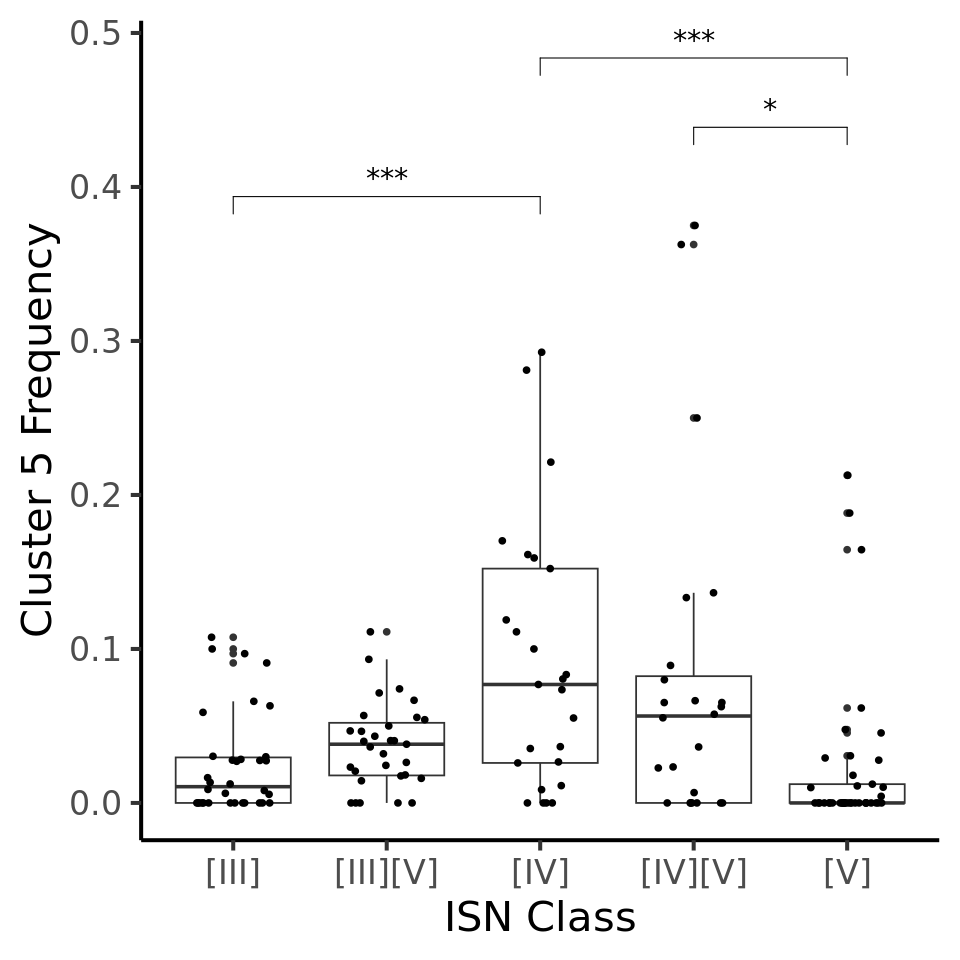

[1] FALSE


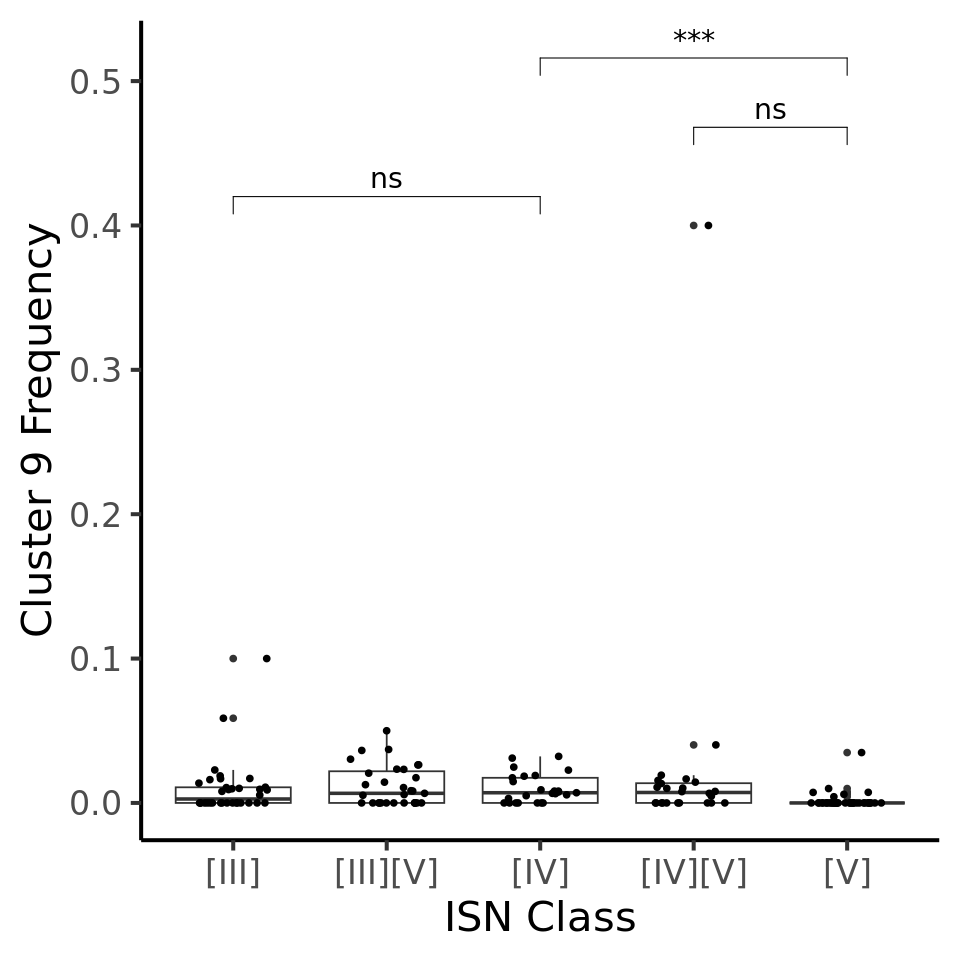

[1] FALSE


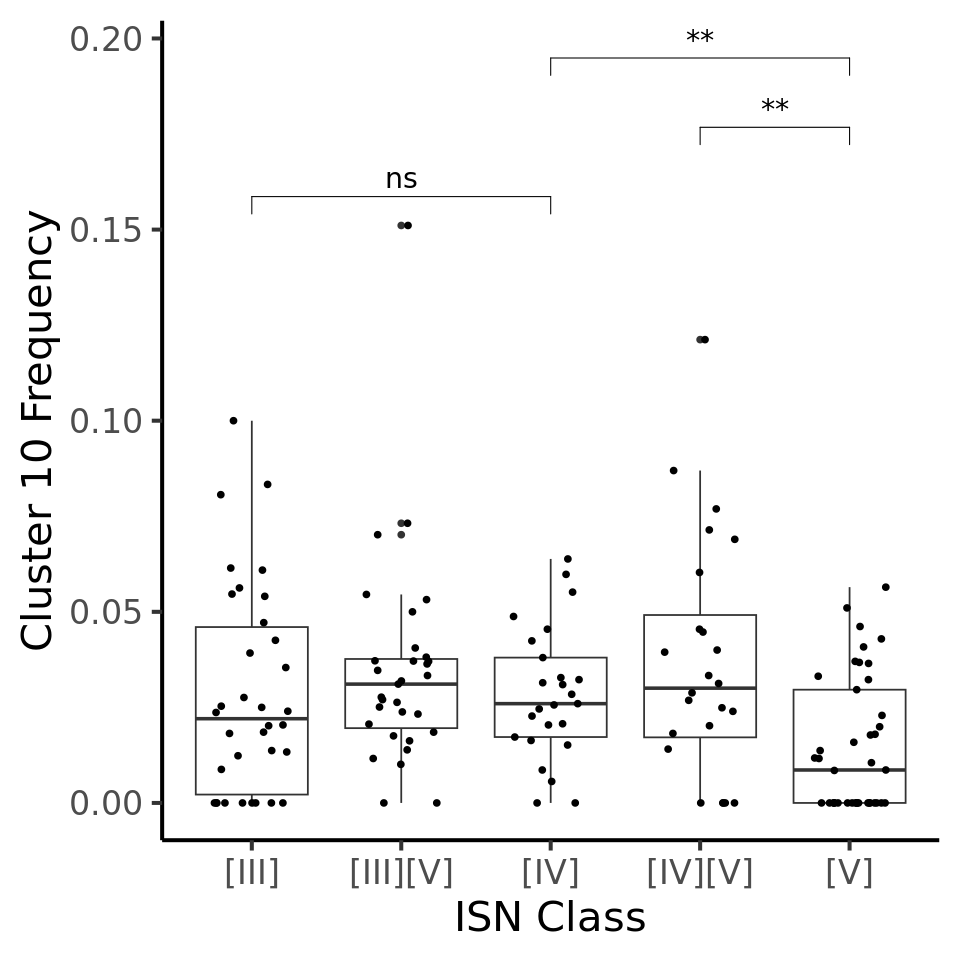

[1] FALSE


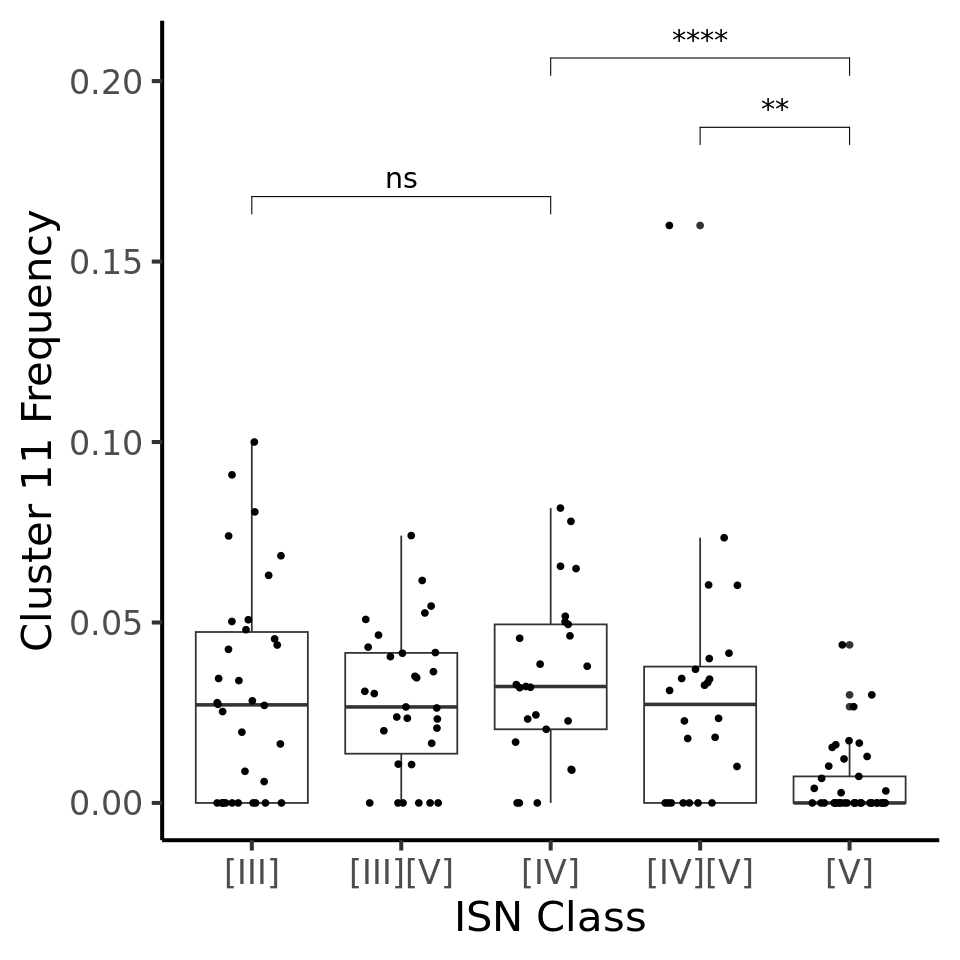

[1] FALSE


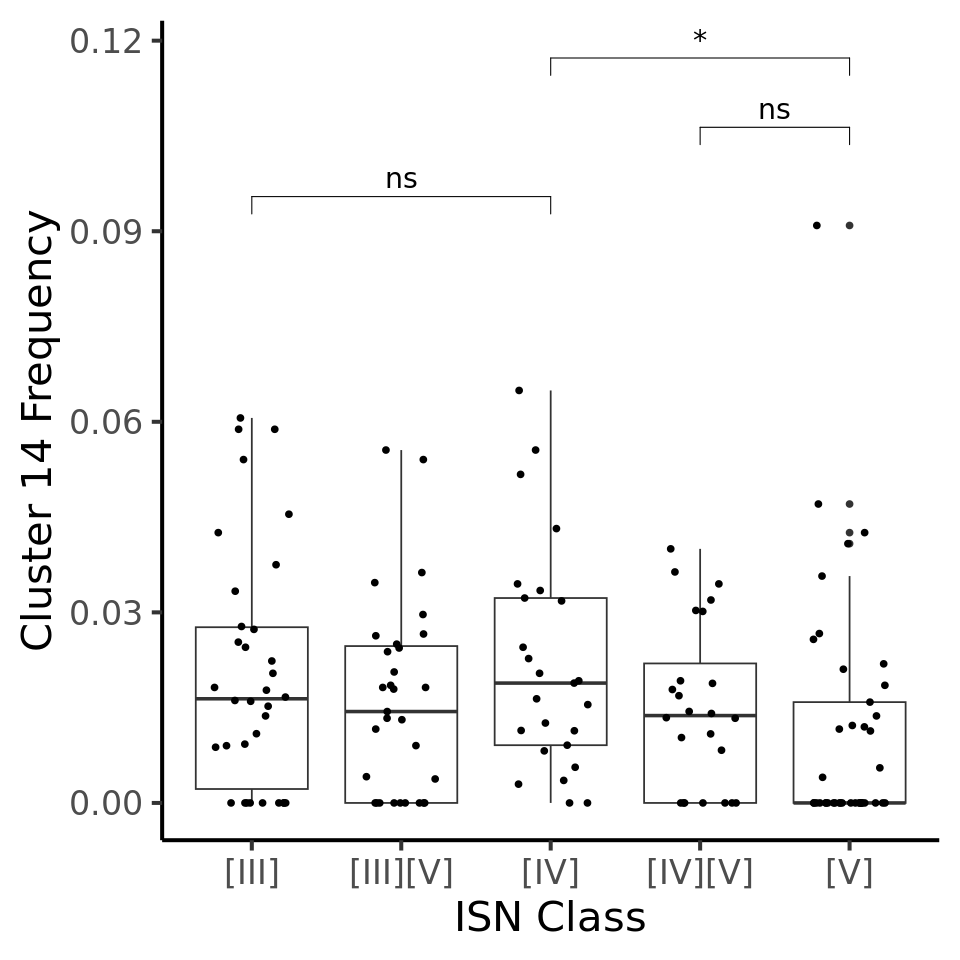

[1] FALSE


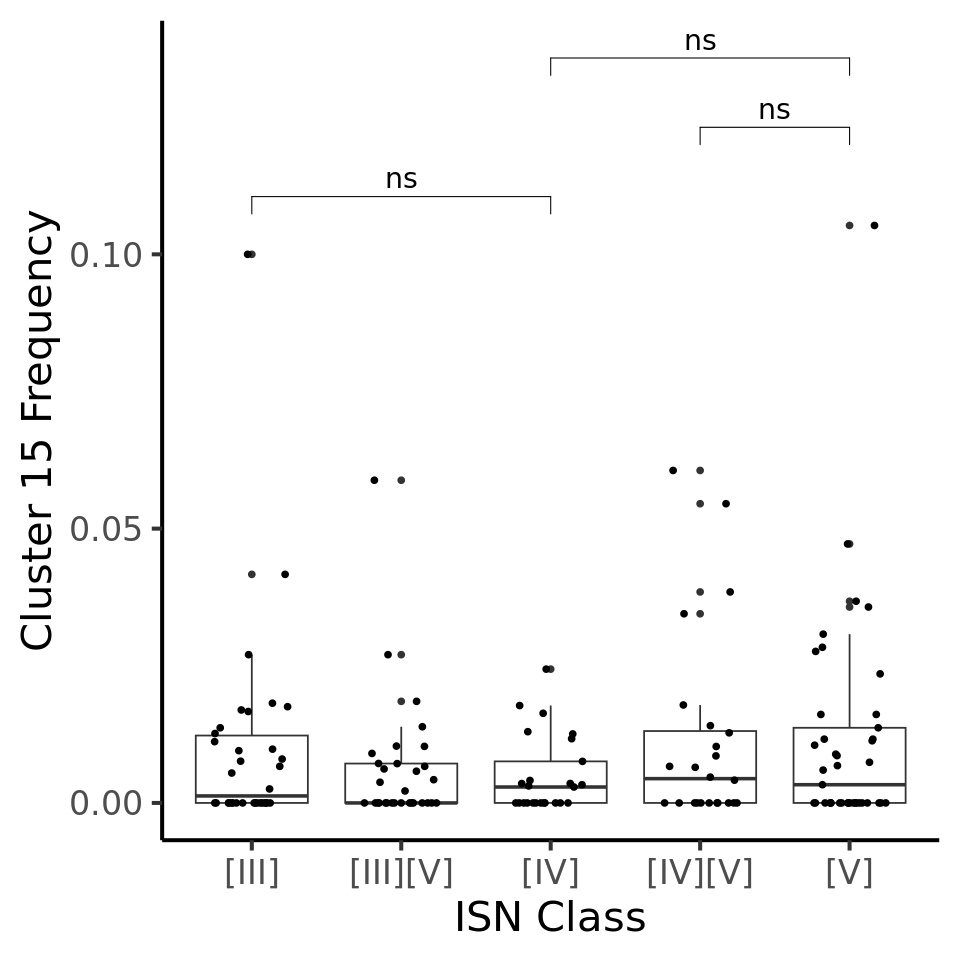

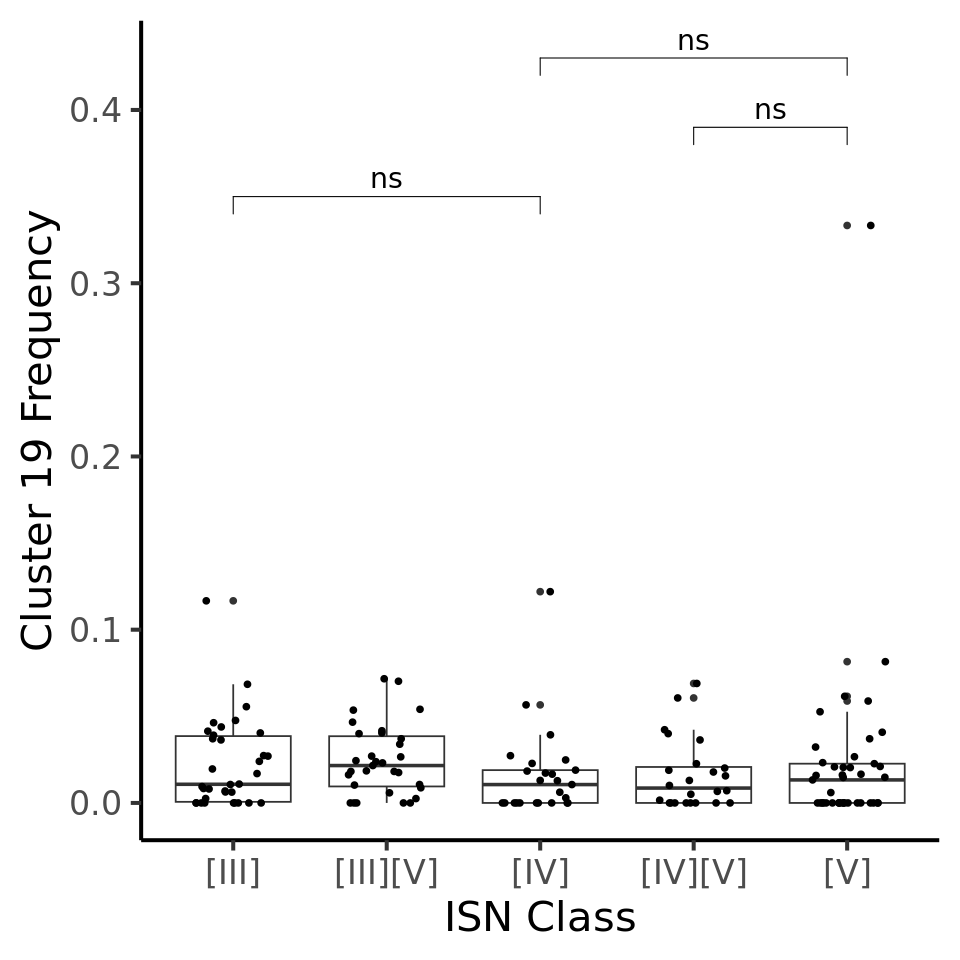

In [22]:
fig.size(8, 8)

my_comparisons <- list(c("[III]", "[IV]"),
                       c("[IV][V]", "[V]"),
                       c("[IV]", "[V]"))
ggplot(prop_table %>% 
        filter(new_cluster_number == 5), aes(x = factor(Final_ISN), y = Freq)) + 
    geom_boxplot() +
    geom_jitter(width = 0.25, height = 0) + 
    theme_classic(base_size = 25) + 
    labs(x = "ISN Class", y = "Cluster 5 Frequency") + 
    ggpubr::stat_compare_means(label = "p.signif", method = "t.test", 
                               comparisons = my_comparisons, size = 6)

ggplot(prop_table %>% 
        filter(new_cluster_number == 11), aes(x = factor(Final_ISN), y = Freq)) + 
    geom_boxplot() +
    geom_jitter(width = 0.25, height = 0) + 
    theme_classic(base_size = 25) + 
    labs(x = "ISN Class", y = "Cluster 11 Frequency") + 
    ggpubr::stat_compare_means(label = "p.signif", method = "t.test", 
                               comparisons = my_comparisons, size = 6)

# TABLE 1

In [6]:
clinical_LN <- clinical %>% filter(Type == "LN") 

In [218]:
write.table(clinical_LN %>% pull(AMP.Subject_ID), "/data/srlab/ssg34/SLE_kidney_v2/data/all_lupus_samples.txt",sep = "\t", 
            quote = FALSE, col.names = FALSE, row.names = FALSE)

In [79]:
clinical_control <- clinical %>% filter(Type != "LN") %>% filter(individual %in% all_immune_meta$individual)

In [ ]:
med_use <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/meds_scRNA_kidney.csv') %>% mutate(individual = gsub("SLE", "", patientID))

In [ ]:
saveRDS(clinical_LN, '/data/srlab/ssg34/SLE_kidney_v2/data/LN_clinicaldata_05232023.rds')

In [545]:
saveRDS(clinical_control, '/data/srlab/ssg34/SLE_kidney_v2/data/control_clinicaldata_05232023.rds')

In [2]:
clinical_LN <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/LN_clinicaldata_05232023.rds')
clinical_control <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/control_clinicaldata_05232023.rds')

In [544]:
clinical_LN <- fastDummies::dummy_cols(clinical_LN, "Race")

In [563]:
clinical_LN <- fastDummies::dummy_cols(clinical_LN, "Ethnicity")

In [546]:
clinical_control <- fastDummies::dummy_cols(clinical_control, "Race")

In [564]:
clinical_control <- fastDummies::dummy_cols(clinical_control, "Ethnicity")

In [569]:
t.test(clinical_LN %>% pull("Ethnicity_Hispanic or Latino"), clinical_LN %>% filter(Final_ISN %in% c("[V]")) %>% pull("Ethnicity_Hispanic or Latino"))


	Welch Two Sample t-test

data:  clinical_LN %>% pull("Ethnicity_Hispanic or Latino") and clinical_LN %>% filter(Final_ISN %in% c("[V]")) %>% pull("Ethnicity_Hispanic or Latino")
t = 0.85978, df = 66.807, p-value = 0.393
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.08505967  0.21377722
sample estimates:
mean of x mean of y 
0.2838710 0.2195122 


In [573]:
t.test(clinical_LN %>% pull("Ethnicity_Hispanic or Latino"), clinical_control %>% pull("Ethnicity_Hispanic or Latino"))


	Welch Two Sample t-test

data:  clinical_LN %>% pull("Ethnicity_Hispanic or Latino") and clinical_control %>% pull("Ethnicity_Hispanic or Latino")
t = 5.0812, df = 109.69, p-value = 1.552e-06
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.1528199 0.3482553
sample estimates:
 mean of x  mean of y 
0.28387097 0.03333333 


In [572]:
t.test(clinical_LN %>% pull("Ethnicity_Hispanic or Latino"), clinical_LN %>% filter(Final_ISN %in% c("[IV][V]", "[III][V]")) %>% pull("Ethnicity_Hispanic or Latino"))


	Welch Two Sample t-test

data:  clinical_LN %>% pull("Ethnicity_Hispanic or Latino") and clinical_LN %>% filter(Final_ISN %in% c("[IV][V]", "[III][V]")) %>% pull("Ethnicity_Hispanic or Latino")
t = -0.59078, df = 91.273, p-value = 0.5561
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.1893262  0.1025227
sample estimates:
mean of x mean of y 
0.2838710 0.3272727 


In [585]:
med_clinical_ln <- clinical_LN %>% select('CS_above10', 'MMF', 'CYC', 'AZA', 'TAC', 'MTX', 'BEL', 'HCQ', 'Final_ISN')

In [586]:
med_clinical_ln

CS_above10,MMF,CYC,AZA,TAC,MTX,BEL,HCQ,Final_ISN
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>
1,1,0,0,0,0,0,1,[III]
0,0,0,1,0,0,0,1,[III]
0,0,0,0,0,0,0,1,[III][V]
1,0,0,0,0,0,0,0,[III][V]
0,0,0,0,0,0,0,0,[V]
1,0,0,1,0,0,0,0,[V]
1,1,0,0,0,0,0,1,[IV]
0,0,0,0,0,0,0,1,[III]
0,1,0,0,0,0,0,1,[III]


In [578]:
colnames(clinical_LN)

[1] "AMP.ID"                        "Final_Site"                   
 [3] "Clinical.Response.at.12.weeks" "Clinical.Response.at.26.weeks"
 [5] "Clinical.Response.at.52.weeks" "Responder.Status"             
 [7] "Type"                          "Sex"                          
 [9] "Age"                           "Race"                         
[11] "Ethnicity"                     "ISN"                          
[13] "Activity"                      "Chronicity"                   
[15] "sample"                        "processing.date"              
[17] "processing.batch"              "XTR.WTA.batch"                
[19] "LCSET.lib.construction.batch"  "DASH.batch"                   
[21] "our.photo.length.mm"           "yield"                        
[23] "cells.loaded"                  "cDNA.yield.ng.uL"             
[25] "index"                         "seq.submission.date"          
[27] "Novaseq.num"                   "Flow.cell"                    
[29] "Lane.num"                      "Rituximab.stop.date"          
[31] "biopsy.length.from.site.mm"    "Age.at.1st.nephritis.episode" 
[33] "dsdna"                         "ana"                          
[35] "antism"                        "antirnp"                      
[37] "antiro"                        "antila"                       
[39] "c3"                            "c4"                           
[41] "ch50"                          "individual"                   
[43] "AMP.Subject_ID"                "Central_ISN"                  
[45] "Central_Activity"              "Central_Chronicity"           
[47] "Final_ISN"                     "Final_Chronicity"             
[49] "Final_Activity"                "patientID"                    
[51] "visit"                         "visit_date"                   
[53] "condition"                     "HCQ"                          
[55] "CS"                            "CS_pulse"                     
[57] "CS_dose"                       "CS_dose_all"                  
[59] "CS_above10"                    "MMF"                          
[61] "CYC"                           "AZA"                          
[63] "TAC"                           "MTX"                          
[65] "BEL"                           "Sex_numeric"                  
[67] "Race_[A]"                      "Race_[A][B]"                  
[69] "Race_[B]"                      "Race_[B][AI]"                 
[71] "Race_[B][W]"                   "Race_[U]"                     
[73] "Race_[W]"                      "Ethnicity_Hispanic or Latino" 
[75] "Ethnicity_Not Hispanic"

# UNIFIED DE

In [5]:
tnk_de <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/TNK_case_control_differential_expression_120722023.rds')
tnk_de <- tnk_de %>% na.omit() 
tnk_de <- tnk_de %>% filter(LRP < 0.05/nrow(tnk_de)) %>% select(Beta, gene, SE) %>% mutate(cell_type = "T/NK")
myeloid_de <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/Myeloid_case_control_differential_expression_120722023.rds')
myeloid_de <- myeloid_de %>% na.omit() 
myeloid_de <- myeloid_de %>% filter(LRP < 0.05/nrow(myeloid_de)) %>% select(Beta, gene, SE) %>% mutate(cell_type = "Myeloid")

In [6]:
de_df <- rbind(tnk_de, myeloid_de)

In [16]:
intersect(tnk_de %>% pull(gene), myeloid_de %>% pull(gene))

[1] "ISG15"      "IFI6"       "SMAP2"      "IFI44L"     "TXNIP"     
 [6] "ARHGEF2"    "RGS1"       "RAB29"      "PDIA6"      "RPS27A"    
[11] "NAT8"       "CXCR4"      "CYTIP"      "STAT1"      "SPATS2L"   
[16] "EEF1B2"     "PARP14"     "GPR171"     "RPL9"       "HNRNPDL"   
[21] "HMGB2"      "RPS14"      "HLA-A"      "PPP1R10"    "FKBP5"     
[26] "PHACTR2"    "ARMT1"      "SYTL3"      "TOMM7"      "BLVRA"     
[31] "SAMD9L"     "AP1S1"      "PDIA4"      "SARAF"      "SLA"       
[36] "LY6E"       "KLF9"       "CELF2"      "OPTN"       "ANAPC16"   
[41] "DDIT4"      "STIP1"      "RPS3"       "ZBTB16"     "BTG1"      
[46] "AC025164.1" "DYNLL1"     "EPSTI1"     "TPT1"       "NFKBIA"    
[51] "AL627171.1" "GABPB1-IT1" "SOCS1"      "PER1"       "SSH2"      
[56] "MRPL27"     "LGALS3BP"   "PSTPIP2"    "BST2"       "WFDC2"     
[61] "CEBPB"      "EVA1C"      "RBM3"       "TSC22D3"

In [20]:
genes <- c("CXCR4", "FKBP5", "ZBTB16", "NFKBIA", "KLF9", 
           "ISG15", "STAT1", "LY6E", "BST2", "PARP14")

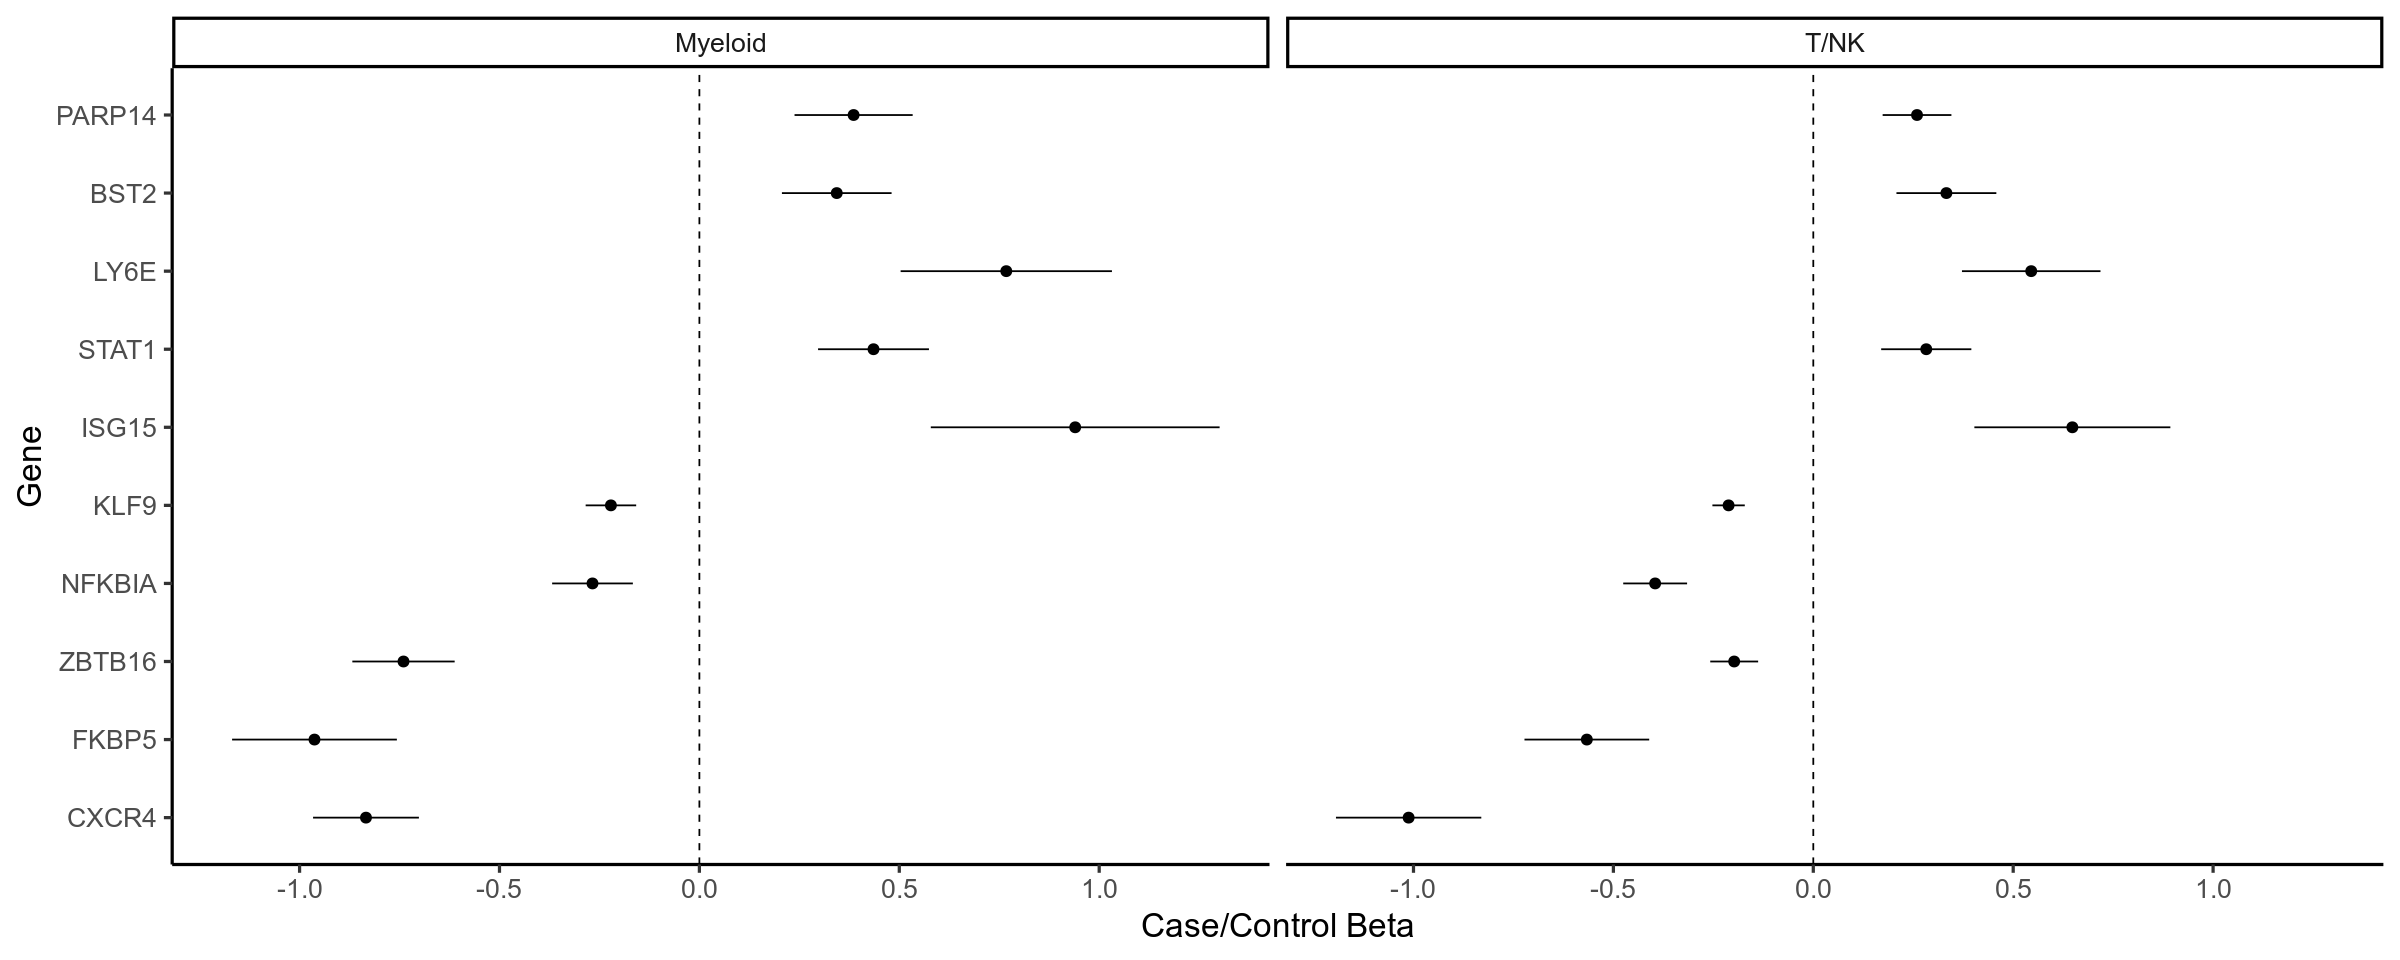

In [21]:
fig.size(8, 20)
ggplot(de_df %>% filter(gene %in% genes) %>% arrange(Beta), aes(x = Beta, y = gene)) + 
    geom_pointrange(aes(xmin = Beta - 1.96 * SE, xmax = Beta + 1.96 * SE)) + 
    facet_grid(cols = vars(cell_type)) + 
    theme_classic(base_size = 20) + 
    geom_vline(aes(xintercept = 0), linetype = "dashed") + 
    scale_y_discrete(limits = genes) + labs(x = "Case/Control Beta", y = "Gene")

# Supplementary Table: CNA correlations

## CASE/CONTROL

In [40]:
case_control_supplementary_table <- data.frame()

### T/NK

In [41]:
meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/case_control/sc_meta.csv')
ncorr <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/case_control/sc_ncorr.csv', header = FALSE)
meta$ncorr <- ncorr$V1
ci_summary <- meta %>% 
                select(new_cluster_number, cell, ncorr) %>% 
                group_by(new_cluster_number) %>% 
                summarize(MEAN.CNA.CORRELATION = round(mean(ncorr), 3),
                          CNA.CORRELATION.CI = paste0("(", round(mean(ncorr) - 1.96 * sd(ncorr) / sqrt(length(cell)), 3),
                          ", ", round(mean(ncorr) + 1.96 * sd(ncorr) / sqrt(length(cell)), 3), ")")) %>% 
                mutate(CELL.TYPE = "T/NK") %>% 
                rename(CLUSTER = new_cluster_number)

In [42]:
case_control_supplementary_table <- case_control_supplementary_table %>% rbind(ci_summary)

### MYELOID

In [43]:
meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/myeloid/case_control/sc_meta.csv')
ncorr <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/myeloid/case_control/sc_ncorr.csv', header = FALSE)
meta$ncorr <- ncorr$V1
ci_summary <- meta %>% 
                select(new_cluster_number, cell, ncorr) %>% 
                group_by(new_cluster_number) %>% 
                summarize(MEAN.CNA.CORRELATION = round(mean(ncorr), 3),
                          CNA.CORRELATION.CI = paste0("(", round(mean(ncorr) - 1.96 * sd(ncorr) / sqrt(length(cell)), 3),
                          ", ", round(mean(ncorr) + 1.96 * sd(ncorr) / sqrt(length(cell)), 3), ")")) %>% 
                mutate(CELL.TYPE = "MYELOID") %>% 
                rename(CLUSTER = new_cluster_number)

In [44]:
case_control_supplementary_table <- case_control_supplementary_table %>% rbind(ci_summary)

### LOH

In [45]:
meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/case_control/sc_meta.csv')
ncorr <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/case_control/sc_ncorr.csv', header = FALSE)
meta$ncorr <- ncorr$V1
ci_summary <- meta %>% 
                select(final_annotation, cell, ncorr) %>% 
                group_by(final_annotation) %>% 
                summarize(MEAN.CNA.CORRELATION = round(mean(ncorr), 3),
                          CNA.CORRELATION.CI = paste0("(", round(mean(ncorr) - 1.96 * sd(ncorr) / sqrt(length(cell)), 3),
                          ", ", round(mean(ncorr) + 1.96 * sd(ncorr) / sqrt(length(cell)), 3), ")")) %>% 
                mutate(CELL.TYPE = "LOH",
                       CLUSTER = str_extract(final_annotation, "(?<=LOH)\\d")) %>% 
                select(-final_annotation)

In [46]:
case_control_supplementary_table <- case_control_supplementary_table %>% rbind(ci_summary)

### DN

In [47]:
meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/DN/case_control/sc_meta.csv')
ncorr <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/DN/case_control/sc_ncorr.csv', header = FALSE)
meta$ncorr <- ncorr$V1
ci_summary <- meta %>% 
                select(final_annotation, cell, ncorr) %>% 
                group_by(final_annotation) %>% 
                summarize(MEAN.CNA.CORRELATION = round(mean(ncorr), 3),
                          CNA.CORRELATION.CI = paste0("(", round(mean(ncorr) - 1.96 * sd(ncorr) / sqrt(length(cell)), 3),
                          ", ", round(mean(ncorr) + 1.96 * sd(ncorr) / sqrt(length(cell)), 3), ")")) %>% 
                mutate(CELL.TYPE = "DN",
                       CLUSTER = str_extract(final_annotation, "(?<=DN)\\d")) %>% 
                select(-final_annotation)

In [48]:
case_control_supplementary_table <- case_control_supplementary_table %>% rbind(ci_summary)

### INTL

In [49]:
meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/case_control/sc_meta.csv')
ncorr <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/case_control/sc_ncorr.csv', header = FALSE)
meta$ncorr <- ncorr$V1
ci_summary <- meta %>% 
                select(final_annotation, cell, ncorr) %>% 
                group_by(final_annotation) %>% 
                summarize(MEAN.CNA.CORRELATION = round(mean(ncorr), 3),
                          CNA.CORRELATION.CI = paste0("(", round(mean(ncorr) - 1.96 * sd(ncorr) / sqrt(length(cell)), 3),
                          ", ", round(mean(ncorr) + 1.96 * sd(ncorr) / sqrt(length(cell)), 3), ")")) %>% 
                mutate(CELL.TYPE = "INTL/STROMAL",
                       CLUSTER = str_extract(final_annotation, "(?<=INTL)\\d")) %>% 
                select(-final_annotation)

In [50]:
case_control_supplementary_table <- case_control_supplementary_table %>% rbind(ci_summary)

### PT

In [51]:
meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/case_control/sc_meta.csv')
ncorr <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/case_control/sc_ncorr.csv', header = FALSE)
meta$ncorr <- ncorr$V1
ci_summary <- meta %>% 
                select(final_annotation, cell, ncorr) %>% 
                group_by(final_annotation) %>% 
                summarize(MEAN.CNA.CORRELATION = round(mean(ncorr), 3),
                          CNA.CORRELATION.CI = paste0("(", round(mean(ncorr) - 1.96 * sd(ncorr) / sqrt(length(cell)), 3),
                          ", ", round(mean(ncorr) + 1.96 * sd(ncorr) / sqrt(length(cell)), 3), ")")) %>% 
                mutate(CELL.TYPE = "PT",
                       CLUSTER = str_extract(final_annotation, "(?<=PT)\\d")) %>% 
                select(-final_annotation)

In [52]:
case_control_supplementary_table <- case_control_supplementary_table %>% rbind(ci_summary)

### GLOM

In [53]:
meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/GLOM/case_control/sc_meta.csv')
ncorr <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/GLOM/case_control/sc_ncorr.csv', header = FALSE)
meta$ncorr <- ncorr$V1
ci_summary <- meta %>% 
                select(final_annotation, cell, ncorr) %>% 
                group_by(final_annotation) %>% 
                summarize(MEAN.CNA.CORRELATION = round(mean(ncorr), 3),
                          CNA.CORRELATION.CI = paste0("(", round(mean(ncorr) - 1.96 * sd(ncorr) / sqrt(length(cell)), 3),
                          ", ", round(mean(ncorr) + 1.96 * sd(ncorr) / sqrt(length(cell)), 3), ")")) %>% 
                mutate(CELL.TYPE = "GLOM",
                       CLUSTER = str_extract(final_annotation, "(?<=GLOM)\\d")) %>% 
                select(-final_annotation)

In [54]:
case_control_supplementary_table <- case_control_supplementary_table %>% rbind(ci_summary)

### ALL Cells Downsampled

In [55]:
meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/downsampled_tissue/case_control/sc_meta.csv')
ncorr <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/downsampled_tissue/case_control/sc_ncorr.csv', header = FALSE)
meta$ncorr <- ncorr$V1
ci_summary <- meta %>% 
                select(cell.type, cell, ncorr) %>% 
                group_by(cell.type) %>% 
                summarize(MEAN.CNA.CORRELATION = round(mean(ncorr), 3),
                          CNA.CORRELATION.CI = paste0("(", round(mean(ncorr) - 1.96 * sd(ncorr) / sqrt(length(cell)), 3),
                          ", ", round(mean(ncorr) + 1.96 * sd(ncorr) / sqrt(length(cell)), 3), ")")) %>% 
                mutate(CELL.TYPE = "TISSUE") %>% 
                rename(CLUSTER = cell.type)

In [56]:
case_control_supplementary_table <- case_control_supplementary_table %>% rbind(ci_summary)

In [57]:
write.csv(case_control_supplementary_table, 
          '/data/srlab/ssg34/SLE_kidney_v2/tables/Supplementary Table 1.csv',
          quote = FALSE,
          row.names = FALSE)

## CHRONICITY

In [59]:
chronicity_supplementary_table <- data.frame()

### T/NK

In [60]:
meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/chronicity/sc_meta.csv')
ncorr <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/chronicity/sc_conditional_ncorr.csv', header = FALSE)
meta$ncorr <- ncorr$V1
ci_summary <- meta %>% 
                select(new_cluster_number, cell, ncorr) %>% 
                group_by(new_cluster_number) %>% 
                summarize(MEAN.CNA.CORRELATION = round(mean(ncorr), 3),
                          CNA.CORRELATION.CI = paste0("(", round(mean(ncorr) - 1.96 * sd(ncorr) / sqrt(length(cell)), 3),
                          ", ", round(mean(ncorr) + 1.96 * sd(ncorr) / sqrt(length(cell)), 3), ")")) %>% 
                mutate(CELL.TYPE = "T/NK") %>% 
                rename(CLUSTER = new_cluster_number)

In [61]:
chronicity_supplementary_table <- chronicity_supplementary_table %>% rbind(ci_summary)